# Clean dataset

In [ ]:
import os
import cv2
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

def clean_image_folder(folder):
    def load_and_check_image(file_path):
        img = None
        try:
            img = cv2.imread(file_path)
        except Exception as e:
            img = None
            
        if img is None:
            print(file_path)
        return file_path

    file_paths = [os.path.join(folder, file_name) for file_name in os.listdir(folder) if os.path.isfile(os.path.join(folder, file_name))]
    
    with ThreadPoolExecutor() as executor:
        tasks = [executor.submit(load_and_check_image, file_path) for file_path in file_paths]
        for task in tqdm(as_completed(tasks), total=len(tasks), desc="Cleaning up images"):
            task.result()


In [ ]:
!ls -la training/zillow46k/source | wc -l

In [ ]:
clean_image_folder("./training/zillow46k/target/")

In [ ]:
clean_image_folder("./training/zillow46k/source/")

In [ ]:
# remove bad prompt.json entries
import json
# load labels from json
prompts = []
dspath = "./training/zillow46k"
prompt_fpath = os.path.join(dspath, "prompt.json")
with open(prompt_fpath) as f:
    for label in f.read().splitlines():
        label_dict = json.loads(label)
        assert os.path.basename(label_dict['source']) == os.path.basename(label_dict['target'])
        prompts.append(label_dict)
        

In [ ]:
target_fpaths = []
src_fpaths = []

clean_prompts = []

for prompt in prompts:
    src_path = os.path.join(dspath, prompt['source'])
    src_fpaths.append(src_path)
    target_path = os.path.join(dspath, prompt['target'])
    target_fpaths.append(target_path)
    if os.path.exists(src_path) and os.path.exists(target_path):        
        clean_prompts.append(prompt)
    
    

In [ ]:
print(f'deleted {len(prompts) - len(clean_prompts)} prompts')
print(f'kept {len(clean_prompts)}')

In [ ]:
import json

def write_jsonl(dict_arr, fpath):
    with open(fpath, 'w') as f:
        for d in dict_arr:
            f.write(json.dumps(d) + '\n')


In [ ]:
write_jsonl(clean_prompts, prompt_fpath)

In [ ]:
!wc -l test.json

# Testing

In [1]:
from share import *
import config

import cv2
import einops
import gradio as gr
import numpy as np
import torch
import random

from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from cldm.model import create_model, load_state_dict
from cldm.ddim_hacked import DDIMSampler



model = create_model('./models/cldm_v15.yaml').cpu()
model.load_state_dict(load_state_dict('checkpoints/epoch=02-step=16991.ckpt', location='cuda'))
model = model.cuda()
ddim_sampler = DDIMSampler(model)



/home/ubuntu/anaconda3/envs/control/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


logging improved.
No module 'xformers'. Proceeding without it.
ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [./models/cldm_v15.yaml]
Loaded state_dict from [checkpoints/epoch=02-step=16991.ckpt]


In [2]:


def process(input_image, 
            prompt, 
            a_prompt='best quality, extremely detailed', 
            n_prompt='longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality',
            num_samples=1, 
            image_resolution=512, 
            ddim_steps=20, 
            guess_mode=False, 
            strength=1.0, 
            scale=9.0, 
            seed=12315124, 
            eta=0):
    with torch.no_grad():
        img = resize_image(HWC3(input_image), image_resolution)
        H, W, C = img.shape
        

        control = torch.from_numpy(img).float().cuda() / 255.0
        control = torch.stack([control for _ in range(num_samples)], dim=0)
        control = einops.rearrange(control, 'b h w c -> b c h w').clone()

        if seed == -1:
            seed = random.randint(0, 65535)
        seed_everything(seed)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)]}
        un_cond = {"c_concat": None if guess_mode else [control], "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)]}
        shape = (4, H // 8, W // 8)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=True)

        model.control_scales = [strength * (0.825 ** float(12 - i)) for i in range(13)] if guess_mode else ([strength] * 13)  # Magic number. IDK why. Perhaps because 0.825**12<0.01 but 0.826**12>0.01
        samples, intermediates = ddim_sampler.sample(ddim_steps, num_samples,
                                                     shape, cond, verbose=False, eta=eta,
                                                     unconditional_guidance_scale=scale,
                                                     unconditional_conditioning=un_cond)
        # print(samples, intermediates)
        # print(samples.shape, intermediates.shape)
        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        x_samples = model.decode_first_stage(samples)
        x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

        results = [x_samples[i] for i in range(num_samples)]
    return results, samples, intermediates


In [5]:
from test_dataset import MyDataset
dataset = MyDataset()


In [6]:
sample = dataset[0]
input_image = sample['jpg']
control = sample['hint']
prompt = sample['txt']

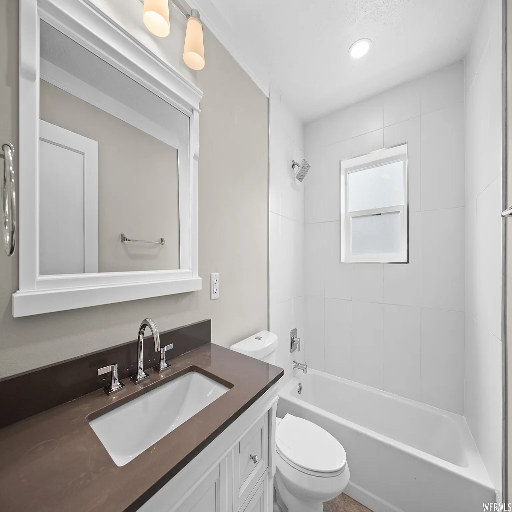

In [7]:
from PIL import Image
def target_to_pil(np_img):
    return Image.fromarray(np.uint8(127.5 * (np_img + 1)))
def source_to_pil(np_img):
    return Image.fromarray(np.uint8(255 * np_img))
source_to_pil(control)

In [8]:
sample['source_filename']

'source/33.png'

In [22]:
import os
num_samples = 5
strengths = [1.0, 0.8]
guidances = [3, 6]
experiment_name = "controlnet_zillow46k_epoch2_17ksteps"
experiment_path = os.path.join("test", experiment_name)
outdir = os.path.join(experiment_path)
os.makedirs(outdir, exist_ok=True)


In [23]:
import os
def get_step_from_filename(filename):
    parts = filename.split('.')
    step_part = parts[0].split('-')[-1]  # extract the part containing the step number
    step = int(step_part.split('=')[-1])
    return step


chkpt_dir = f"./checkpoints/"
chkpts = os.listdir(chkpt_dir)
ckpt_steps = list(map(get_step_from_filename, chkpts))
print(f'found {len(chkpts)} checkpoints for experiment {experiment_name} (min step: {min(ckpt_steps)}, max step: {max(ckpt_steps)})')



found 3 checkpoints for experiment controlnet_zillow46k_epoch2_17ksteps (min step: 5663, max step: 16991)


In [24]:
chkpts = ['epoch=02-step=16991.ckpt']

In [25]:
len(dataset)

50

In [26]:
i = 0
for ckpt_fname in chkpts:
    ckpt_fpath = os.path.join(chkpt_dir, ckpt_fname)
    step_num = get_step_from_filename(ckpt_fname)
    
    for sample in dataset:
        expected_result = sample['jpg']
        control = sample['hint']
        prompt = sample['txt']
        fname = sample['source_filename'].replace('source/', '').replace('.png', '')
        source_to_pil(control).save(os.path.join(outdir, f'{i}.png'))
        
        for strength in strengths:
            for guidance in guidances:
                respath = os.path.join(outdir, f'{i}_strh{strength}_gs{guidance}_step{step_num}.png')
                if os.path.exists(respath):
                    continue

                results, samples, intermediates = process(
                    np.uint8(255 * control), 
                    prompt,
                    strength=strength,
                    scale=guidance,
                    ddim_steps=20)

                result = Image.fromarray(results[0])
                result.save(respath)
        i += 1
            

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.55it/s]


tensor([[[[ 0.8926,  0.0825, -0.0777,  ...,  1.4078,  1.6542, -0.2447],
          [ 0.6467,  0.1193, -0.0508,  ...,  0.3916,  0.2261, -0.1945],
          [ 0.7904,  0.1367,  0.1499,  ...,  0.6905,  1.3297,  0.5329],
          ...,
          [ 0.2210,  0.3362, -0.0826,  ..., -0.1681,  0.8902, -0.3530],
          [-0.2476,  0.1721, -0.3891,  ..., -1.2018, -1.0986, -0.1256],
          [ 0.3432, -0.4970, -0.2643,  ..., -0.1060,  0.8713,  1.4640]],

         [[-0.1187, -0.5923,  0.8652,  ...,  0.5639, -0.3005,  0.7323],
          [-0.4607, -0.4892,  0.4617,  ...,  0.2117, -0.0552,  0.7240],
          [-0.4117, -0.4020,  0.7456,  ...,  1.1733, -0.1458,  0.6262],
          ...,
          [-0.3375, -0.7755, -0.9615,  ...,  0.1853, -0.4731,  0.7010],
          [-0.9118, -0.0454, -0.4715,  ...,  0.1988, -0.9401,  0.7531],
          [-0.7398, -0.4640, -0.7594,  ...,  1.9239,  1.1504,  1.2453]],

         [[ 0.4563,  0.0109, -0.4995,  ...,  0.7738,  0.0356, -1.1306],
          [ 1.0254,  0.0628, -

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 1.0222e+00,  2.3907e-01, -3.6419e-01,  ...,  1.4639e+00,
            1.9055e+00, -9.8846e-01],
          [ 6.4108e-01, -1.4192e-02, -1.2193e-03,  ...,  4.6477e-01,
            2.8366e-01, -2.1512e-01],
          [ 9.5442e-01,  2.0250e-01,  3.4382e-02,  ...,  4.6668e-01,
            9.1213e-01, -1.3028e-01],
          ...,
          [ 5.2176e-01,  1.1061e+00,  2.5267e-01,  ..., -4.2164e-01,
            1.8825e+00, -7.3336e-01],
          [-1.0322e-01,  7.6264e-01,  3.6305e-01,  ..., -1.1508e+00,
           -1.6677e+00, -1.0918e+00],
          [ 8.9836e-01,  1.0819e+00,  7.9335e-01,  ...,  4.5077e-02,
            6.6531e-01,  4.9221e-01]],

         [[ 1.2101e-01, -6.1909e-01,  7.1287e-01,  ...,  3.1820e-01,
           -9.0897e-01,  8.3810e-01],
          [-6.7604e-01, -9.9111e-02,  5.3372e-01,  ...,  1.9205e-02,
           -5.2263e-02,  8.9239e-01],
          [-3.3021e-01, -4.4356e-01,  9.8698e-01,  ...,  1.1353e+00,
           -7.1337e-01,  6.6569e-01],
          ...,
     

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.61it/s]


tensor([[[[ 8.8034e-01,  1.8384e-01,  3.5651e-02,  ...,  1.3080e+00,
            1.6649e+00, -1.3409e-01],
          [ 7.1330e-01,  1.9082e-01,  1.2523e-01,  ...,  2.9532e-01,
            1.6629e-01, -9.0851e-02],
          [ 7.9517e-01,  2.0470e-01,  2.4732e-01,  ...,  6.1205e-01,
            1.2697e+00,  6.1340e-01],
          ...,
          [ 1.8611e-01,  1.0923e-01, -3.3171e-01,  ..., -1.2973e-01,
            7.2819e-01, -3.1766e-01],
          [-3.9259e-01,  1.2602e-01, -3.2820e-01,  ..., -1.3589e+00,
           -1.0965e+00,  1.9485e-01],
          [ 3.2583e-01, -4.4224e-01, -1.4551e-02,  ..., -4.3031e-02,
            7.2022e-01,  1.7567e+00]],

         [[-1.9896e-01, -5.6346e-01,  7.2602e-01,  ...,  5.3823e-01,
           -3.1456e-01,  6.7042e-01],
          [-4.0139e-01, -5.2723e-01,  3.3531e-01,  ...,  1.0150e-01,
           -4.7347e-03,  6.9959e-01],
          [-4.6082e-01, -4.6424e-01,  7.2271e-01,  ...,  1.1379e+00,
           -2.2785e-01,  5.9838e-01],
          ...,
     

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.35it/s]


tensor([[[[ 1.1063,  0.2534,  0.0243,  ...,  1.6641,  1.9036, -0.5026],
          [ 0.7753,  0.1981,  0.0622,  ...,  0.4796,  0.3636, -0.1395],
          [ 0.9638,  0.2486,  0.2604,  ...,  0.5493,  1.2008,  0.3206],
          ...,
          [ 0.3703,  0.1477, -0.3074,  ..., -0.4174,  1.2459, -0.7053],
          [-0.5488,  0.1936, -0.1770,  ..., -1.3469, -1.4999, -0.4685],
          [ 0.5365, -0.3094,  0.4856,  ..., -0.1284,  0.6602,  1.6212]],

         [[ 0.0306, -0.7972,  0.8511,  ...,  0.5042, -0.5419,  0.9286],
          [-0.6093, -0.4562,  0.2927,  ...,  0.2790, -0.2146,  1.0117],
          [-0.4286, -0.5637,  0.9543,  ...,  1.1978, -0.4708,  0.8315],
          ...,
          [-0.6251, -0.4950, -0.6711,  ..., -0.2173, -1.2695,  1.0116],
          [-0.7146, -0.1153, -0.7088,  ...,  0.4494, -0.9457,  0.8315],
          [-0.1657, -0.3112,  0.1070,  ...,  2.6914,  1.9517,  1.3273]],

         [[ 0.5646,  0.2855, -0.6075,  ...,  0.7491, -0.0565, -1.4824],
          [ 1.0426, -0.0678, -

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 1.3750e+00,  1.1741e+00,  9.6452e-01,  ...,  1.2031e+00,
            1.0135e+00,  7.9334e-01],
          [ 1.1780e+00,  9.9683e-01,  8.4493e-01,  ...,  6.8168e-01,
            6.0848e-01,  5.7565e-01],
          [ 1.2214e+00,  1.0813e+00,  9.3509e-01,  ...,  9.8908e-01,
            1.0534e+00,  6.3414e-01],
          ...,
          [ 5.1743e-02,  4.3672e-01, -4.1709e-01,  ..., -6.7253e-01,
            8.0773e-02, -6.6051e-01],
          [-3.8477e-01,  9.3755e-02, -9.5367e-02,  ..., -2.7304e+00,
           -1.7453e+00,  5.0534e-01],
          [ 8.9377e-01, -4.2864e-01,  2.8656e-01,  ...,  1.5134e+00,
            5.2563e-02,  2.0153e+00]],

         [[ 6.4978e-01,  4.8248e-01,  7.7230e-01,  ...,  3.1741e-01,
            1.0161e-01,  4.8640e-01],
          [ 6.5154e-01,  3.8903e-01,  3.6737e-01,  ..., -1.2573e-01,
            2.5001e-01,  4.7075e-01],
          [ 4.9246e-01,  2.7221e-01,  6.7863e-01,  ...,  3.7276e-01,
            4.5835e-02,  5.3280e-01],
          ...,
     

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s]


tensor([[[[ 1.3016e+00,  1.7701e+00,  1.0895e+00,  ...,  1.0444e+00,
            7.8581e-01,  1.8082e+00],
          [ 1.7356e+00,  1.4378e+00,  1.1906e+00,  ...,  1.0460e+00,
            9.4684e-01,  8.8499e-01],
          [ 1.4354e+00,  1.5051e+00,  1.3381e+00,  ...,  1.4595e+00,
            6.4255e-01,  5.8764e-01],
          ...,
          [ 1.1100e-01,  1.1781e+00, -7.1591e-01,  ..., -2.1406e-01,
           -2.8843e-01, -1.1047e+00],
          [-5.8265e-01,  2.3500e-01,  1.1276e-01,  ..., -2.6496e+00,
           -1.3694e+00, -2.4897e-01],
          [ 9.5303e-01,  6.5574e-01,  2.0658e-01,  ...,  1.0984e+00,
            5.4985e-02,  2.3712e+00]],

         [[ 8.4425e-01,  5.7960e-01,  1.0956e+00,  ...,  4.1669e-01,
            2.9041e-01,  4.9506e-01],
          [ 7.3670e-01,  5.0452e-01,  4.1578e-01,  ...,  4.5734e-01,
            1.3301e-01,  3.3299e-01],
          [ 6.5488e-01,  1.1969e-02,  6.4281e-01,  ..., -2.4752e-01,
            2.9302e-01,  5.4523e-01],
          ...,
     

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:04<00:00,  4.98it/s]
Global seed set to 12315124


tensor([[[[ 1.3271,  1.0849,  0.9789,  ...,  1.1247,  0.9872,  0.7003],
          [ 1.1022,  0.9683,  0.8307,  ...,  0.7689,  0.6946,  0.5720],
          [ 1.1289,  1.0080,  0.8699,  ...,  0.8649,  1.0590,  0.6748],
          ...,
          [ 0.0060,  0.3361, -0.4637,  ..., -0.3586,  0.1802, -1.0386],
          [-0.4874,  0.0540, -0.2547,  ..., -2.2508, -1.4043,  0.2060],
          [ 0.7927, -0.7037,  0.1160,  ...,  1.1276, -0.1064,  1.4060]],

         [[ 0.5845,  0.4293,  0.6323,  ...,  0.1653,  0.0146,  0.3618],
          [ 0.5211,  0.3220,  0.2657,  ..., -0.1852,  0.0811,  0.3096],
          [ 0.4086,  0.3173,  0.5371,  ...,  0.3139, -0.1075,  0.3271],
          ...,
          [ 0.0112, -0.2310, -1.2549,  ..., -0.1541, -0.0251, -0.2735],
          [-0.4619,  0.2138, -0.1928,  ..., -0.0778, -0.8994, -0.4390],
          [-0.5150, -0.3029, -0.2291,  ..., -0.2408, -1.3802, -0.3201]],

         [[-0.0240,  0.0254,  0.1221,  ...,  0.3979,  0.2385,  0.2704],
          [-0.0117,  0.5434, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.17it/s]


tensor([[[[ 1.4528,  1.6299,  1.0034,  ...,  1.1851,  0.8895,  1.4122],
          [ 1.4798,  1.3602,  1.3890,  ...,  1.2199,  0.8299,  0.8526],
          [ 1.6043,  1.6326,  0.7128,  ...,  1.2014,  0.6894,  0.6364],
          ...,
          [-0.0998,  0.8236, -0.4511,  ..., -0.5165, -0.6190, -1.5011],
          [ 0.2968,  0.0410,  0.2566,  ..., -2.8989, -1.7820,  0.2927],
          [ 0.4165,  1.2212, -0.1700,  ...,  1.8722,  0.1415,  2.3999]],

         [[ 0.7368,  0.6977,  0.8268,  ...,  0.5723,  0.1331,  0.4400],
          [ 0.7556,  0.7574,  0.4846,  ...,  0.5785,  0.1192,  0.3032],
          [ 0.7132,  0.0591,  0.4686,  ..., -0.2151,  0.3118,  0.5139],
          ...,
          [-0.6245, -0.1252, -0.1152,  ..., -0.4892,  0.0649, -0.8226],
          [ 0.8162,  0.0677, -0.1919,  ...,  0.0742, -1.1570,  0.2193],
          [-1.2848, -0.2959,  0.2541,  ...,  1.2360, -0.7653, -0.0044]],

         [[-0.4414,  0.2469, -0.0691,  ...,  0.0386,  0.4225,  0.1932],
          [ 0.0054,  0.8010,  

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:04<00:00,  4.90it/s]
Global seed set to 12315124


tensor([[[[ 1.2101,  1.0293,  1.0117,  ...,  1.1530,  1.0585,  0.8540],
          [ 0.9529,  0.3904,  0.6577,  ...,  1.1311,  0.7150,  0.4255],
          [ 0.7865,  0.9570,  0.5543,  ...,  0.9074,  0.7513,  0.0271],
          ...,
          [ 0.1001,  0.6899, -0.4183,  ..., -0.3529,  0.8931,  0.6722],
          [-0.5350,  0.3906,  0.0197,  ..., -0.6104, -0.0428, -0.0207],
          [ 0.5336, -0.4655,  0.5186,  ...,  0.4009, -0.1298,  1.4052]],

         [[ 0.7184,  0.5517,  0.5319,  ...,  0.3794,  0.2953,  0.5166],
          [ 0.0688,  0.9938,  0.2853,  ...,  0.1423,  0.4001,  0.3115],
          [ 0.5022, -0.0513,  0.9273,  ..., -0.1158,  0.3397,  0.7304],
          ...,
          [-0.0815,  0.0085, -1.4081,  ...,  0.5004,  0.5973, -0.0244],
          [-0.3646,  0.5216, -0.0079,  ...,  0.0100, -0.5558,  0.9013],
          [-0.0039, -0.1244,  0.3244,  ..., -0.6928,  1.1576,  0.0221]],

         [[-0.5766,  0.4491,  0.2037,  ...,  0.0394,  0.3403,  0.3108],
          [ 0.0593, -0.4789,  

DDIM Sampler: 100%|██████████| 20/20 [00:04<00:00,  4.94it/s]
Global seed set to 12315124


tensor([[[[ 1.3456,  1.0782,  1.1532,  ...,  1.2445,  1.1808,  1.0568],
          [ 1.2502,  0.4567,  0.7093,  ...,  1.5067,  1.0581,  0.5469],
          [ 0.8329,  1.1785,  0.9197,  ...,  0.8982,  0.6569,  0.0182],
          ...,
          [ 0.2073,  0.7833, -0.7224,  ..., -0.6525,  0.2819,  0.3919],
          [-0.4833,  0.4520, -0.3382,  ..., -0.6887, -0.1126, -0.0480],
          [ 0.6207, -0.4469,  0.6952,  ...,  0.6369, -0.2165,  1.9406]],

         [[ 0.7596,  0.6826,  0.6544,  ...,  0.4417,  0.5296,  0.5194],
          [ 0.1050,  0.9724,  0.1743,  ...,  0.3247,  0.5345,  0.2839],
          [ 0.7091, -0.1286,  0.9001,  ..., -0.2825,  0.4427,  0.7080],
          ...,
          [ 0.5241,  0.0764, -0.4429,  ...,  0.3433,  1.1894,  0.0438],
          [-0.3220,  1.1428,  0.1187,  ...,  0.2267, -0.8379,  1.0550],
          [ 0.2115,  0.0488,  0.7055,  ..., -0.7358,  1.3562,  0.0411]],

         [[-0.6750,  0.5393,  0.1945,  ..., -0.2747,  0.4525,  0.2214],
          [ 0.1061, -0.6924,  

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 1.1511,  0.9909,  0.9545,  ...,  1.1941,  1.0639,  0.7817],
          [ 0.9142,  0.3972,  0.6457,  ...,  1.0419,  0.6145,  0.3805],
          [ 0.8789,  0.9570,  0.4940,  ...,  0.8623,  0.6705,  0.0610],
          ...,
          [ 0.1228,  0.6618, -0.4040,  ..., -0.0832,  0.8940,  0.7080],
          [-0.5844,  0.3007,  0.0590,  ..., -0.7168, -0.0251,  0.1395],
          [ 0.5417, -0.5078,  0.4083,  ...,  0.2992, -0.0445,  1.3802]],

         [[ 0.6412,  0.4901,  0.4592,  ...,  0.2893,  0.2092,  0.4456],
          [ 0.0239,  0.9320,  0.2201,  ..., -0.0071,  0.3078,  0.2501],
          [ 0.4164, -0.0806,  0.9017,  ...,  0.0026,  0.3045,  0.6226],
          ...,
          [-0.1765, -0.0333, -1.5554,  ...,  0.5264,  0.7483, -0.1394],
          [-0.4264,  0.3646, -0.1641,  ..., -0.1008, -0.6052,  0.9128],
          [-0.1676, -0.2744,  0.1022,  ..., -0.7835,  1.0127,  0.0341]],

         [[-0.5358,  0.4563,  0.2342,  ...,  0.1802,  0.3405,  0.3246],
          [ 0.0716, -0.4177,  

DDIM Sampler: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s]


tensor([[[[ 1.2671,  1.0886,  1.0707,  ...,  1.3350,  1.1977,  0.9609],
          [ 1.1158,  0.5059,  0.6077,  ...,  1.4003,  0.9264,  0.4490],
          [ 0.8296,  1.1036,  0.7842,  ...,  0.9658,  0.7810,  0.0345],
          ...,
          [ 0.2589,  0.1498, -0.7376,  ..., -0.8570,  0.6145,  0.6880],
          [-0.4043,  0.5129, -0.4546,  ..., -0.3536, -0.0766,  0.0394],
          [ 0.6123, -0.1968,  0.6055,  ...,  0.4391,  0.0167,  1.8279]],

         [[ 0.6913,  0.6072,  0.6055,  ...,  0.4524,  0.4051,  0.5272],
          [ 0.1218,  1.0113,  0.1836,  ...,  0.1191,  0.5087,  0.3025],
          [ 0.5975, -0.0496,  0.9822,  ..., -0.3501,  0.3805,  0.7286],
          ...,
          [ 0.7786,  0.0477, -0.5708,  ...,  0.5801,  1.0108,  0.0049],
          [-0.3954,  0.5919, -0.0676,  ...,  0.0154, -0.7898,  1.0984],
          [ 0.3870, -0.0696,  0.9566,  ..., -0.9232,  1.2429,  0.0434]],

         [[-0.6575,  0.5188,  0.2031,  ..., -0.1137,  0.4243,  0.2624],
          [ 0.0685, -0.6540, -

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:04<00:00,  4.65it/s]


tensor([[[[ 2.3731e-01,  2.1225e-01, -2.1475e-01,  ...,  5.2250e-01,
            3.7500e-01, -4.8423e-01],
          [ 6.7480e-02,  4.0590e-01, -3.2815e-01,  ..., -5.3184e-01,
           -2.0552e-01, -6.8300e-01],
          [ 1.8755e-02,  6.3055e-02, -5.0630e-01,  ..., -7.6671e-02,
           -1.7079e-02, -3.1361e-01],
          ...,
          [-3.3359e-01,  1.6892e+00, -4.8744e-01,  ..., -1.9988e+00,
           -1.2112e+00,  8.2201e-01],
          [-1.0223e+00,  1.3034e+00, -3.9563e-01,  ..., -2.4021e+00,
           -2.9646e+00, -1.5609e-01],
          [ 3.1150e-01,  5.8786e-01, -1.8100e-01,  ..., -9.1504e-02,
            3.5601e-03,  1.3311e+00]],

         [[ 1.2096e-01,  1.0779e-01,  7.3953e-01,  ...,  9.0340e-02,
            2.1547e-01,  4.9922e-01],
          [-2.1066e-02,  3.6966e-01,  6.5830e-01,  ...,  1.3388e-01,
            2.4295e-01,  3.3657e-01],
          [-3.4721e-01,  5.6795e-01,  1.1440e+00,  ...,  8.0311e-01,
            5.1218e-01,  2.2730e-01],
          ...,
     

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:04<00:00,  4.52it/s]


tensor([[[[ 0.2497,  0.1017, -0.1673,  ...,  0.5136,  0.4906, -0.7558],
          [-0.0931,  0.2966, -0.0584,  ..., -0.7042, -0.3182, -0.9422],
          [ 0.0176,  0.0747, -0.8091,  ..., -0.0762, -0.2190, -0.3504],
          ...,
          [-0.6095,  1.5463, -0.8921,  ..., -1.9259, -0.7888,  1.5834],
          [-1.4793,  1.3156, -0.1677,  ..., -3.1001, -3.0899, -0.4870],
          [ 0.1915,  0.4045, -1.3637,  ..., -0.8340, -0.4618,  1.0462]],

         [[ 0.2640, -0.1650,  0.8849,  ...,  0.0397,  0.3876,  0.5628],
          [ 0.0892,  0.4406,  0.9228,  ...,  0.1981,  0.2719,  0.4040],
          [-0.2343,  0.5610,  1.2933,  ...,  0.9534,  0.7136,  0.2074],
          ...,
          [ 0.6069, -0.0242, -0.5419,  ...,  0.0322,  1.1166, -0.0269],
          [ 0.5109,  0.0103,  0.1059,  ..., -0.2732, -1.8781,  0.1776],
          [ 0.4841, -0.1290, -0.5920,  ...,  2.7061,  1.5721,  0.3856]],

         [[ 0.8644, -0.7222, -0.1226,  ...,  0.4101,  0.4945, -0.0240],
          [ 0.9693, -0.1964,  

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  2.90it/s]


tensor([[[[ 0.2669,  0.3018, -0.3038,  ...,  0.9063,  0.6015,  0.2692],
          [ 0.1577,  0.4850, -0.4277,  ..., -0.3898, -0.2324, -0.6167],
          [ 0.0162,  0.1284, -0.4168,  ..., -0.0115,  0.1651, -0.2491],
          ...,
          [-0.2180,  1.7203, -0.3966,  ..., -0.7682, -0.0654,  0.1661],
          [-0.8904,  1.3637, -0.2515,  ..., -2.6957, -2.6160,  0.5257],
          [ 0.4869,  0.5023, -0.1586,  ...,  0.8192, -0.3660,  1.4405]],

         [[ 0.0125,  0.0797,  0.6576,  ..., -0.1129, -0.3771,  0.4317],
          [-0.1679,  0.3202,  0.4294,  ..., -0.0172,  0.1593,  0.1399],
          [-0.4217,  0.4203,  0.9393,  ...,  0.6214,  0.3454,  0.1727],
          ...,
          [ 0.3528, -0.0805, -0.6585,  ..., -0.2571,  0.1613,  0.2895],
          [ 0.1380, -0.1483, -0.2415,  ...,  0.0720, -1.5223, -0.0297],
          [ 0.2091, -0.4216, -0.5778,  ...,  1.1825, -0.0953,  0.2685]],

         [[ 0.4991, -0.6135, -0.1109,  ...,  0.3622,  0.2335,  0.4043],
          [ 0.9525, -0.2927, -

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:04<00:00,  4.53it/s]


tensor([[[[ 0.2954,  0.1908, -0.1586,  ...,  0.8634,  0.6404,  0.2782],
          [ 0.0576,  0.4777, -0.4519,  ..., -0.5971, -0.4075, -0.8165],
          [-0.0435,  0.1834, -0.6825,  ..., -0.0553,  0.0344, -0.3074],
          ...,
          [-0.4585,  1.7177, -0.6449,  ..., -1.5121,  0.6639,  0.2503],
          [-1.2306,  1.3971, -0.1570,  ..., -3.0857, -3.2643,  0.6330],
          [ 0.2855,  0.3352, -0.8162,  ...,  0.7997, -0.9300,  1.1528]],

         [[ 0.1684, -0.1748,  0.7277,  ..., -0.0487, -0.3427,  0.6477],
          [-0.0361,  0.3657,  0.6242,  ...,  0.0339,  0.2568,  0.1837],
          [-0.2826,  0.6202,  1.2306,  ...,  0.9605,  0.5966,  0.3388],
          ...,
          [ 0.5331, -0.0493, -0.4471,  ...,  0.2583,  0.6069,  0.5887],
          [ 0.3266, -0.0992,  0.0655,  ...,  0.1827, -1.1821, -0.0986],
          [ 0.5130, -0.3386, -0.5835,  ...,  1.7518,  0.3833,  0.5177]],

         [[ 0.7281, -0.6969, -0.0568,  ...,  0.3878,  0.2688,  0.4432],
          [ 1.0325, -0.2697, -

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.33it/s]


tensor([[[[ 5.4960e-01,  2.6944e-01,  1.8109e-02,  ...,  1.5129e+00,
            1.7850e+00,  1.1567e+00],
          [ 3.0707e-01,  4.6033e-01, -2.4349e-01,  ...,  9.8189e-01,
            9.5457e-01,  9.1696e-01],
          [ 3.2406e-01, -3.9993e-01,  3.2739e-01,  ...,  1.3910e+00,
            1.7145e+00,  1.3088e+00],
          ...,
          [ 4.5789e-01, -1.4021e-02, -6.1008e-01,  ...,  1.8738e-01,
            6.4635e-01, -4.5134e-02],
          [-1.1654e+00,  5.7510e-01, -1.3926e+00,  ...,  2.2044e-01,
            4.8804e-01,  4.1011e-01],
          [ 1.1899e+00, -9.5465e-01,  3.1173e-01,  ...,  1.0953e+00,
            7.8680e-01,  1.4426e-01]],

         [[ 1.5274e-01,  3.7921e-01,  4.0132e-01,  ...,  6.7590e-01,
            2.8617e-01,  8.5638e-01],
          [ 2.1112e-01,  9.3170e-01,  2.5371e-01,  ...,  3.6805e-01,
            2.8180e-01,  1.0110e+00],
          [ 2.1224e-01,  3.4868e-01,  1.0077e+00,  ...,  6.6975e-01,
            1.4454e-01,  1.1030e+00],
          ...,
     

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:04<00:00,  4.92it/s]


tensor([[[[ 4.9859e-01,  2.2326e-01,  5.2309e-01,  ...,  1.7857e+00,
            1.9538e+00,  1.2105e+00],
          [ 5.7580e-01,  1.0227e+00,  2.4854e-01,  ...,  1.6022e+00,
            9.1988e-01,  9.1841e-01],
          [ 7.8919e-01, -4.8550e-01,  8.7801e-01,  ...,  1.3719e+00,
            1.6722e+00,  9.9412e-01],
          ...,
          [-1.4850e-01, -6.4327e-01, -3.9624e-01,  ..., -1.9715e-01,
            3.8386e-01, -3.8936e-02],
          [-1.4349e+00,  1.2674e-01, -1.8842e+00,  ...,  6.3463e-01,
            6.7371e-01,  4.1805e-01],
          [ 4.2089e-01, -1.7074e+00,  1.9054e-01,  ...,  1.5657e+00,
            8.3953e-01, -2.9428e-02]],

         [[ 3.0528e-01,  1.1722e-01,  1.9178e-01,  ...,  9.4719e-01,
            4.7884e-01,  1.1633e+00],
          [ 1.5744e-01,  1.3244e+00,  1.3118e-01,  ...,  5.7440e-01,
            4.4876e-01,  1.1562e+00],
          [ 1.1670e-01,  5.4615e-02,  1.1928e+00,  ...,  9.6621e-01,
            1.5180e-01,  1.4969e+00],
          ...,
     

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:04<00:00,  4.85it/s]


tensor([[[[ 0.3106, -0.0679, -0.1507,  ...,  1.4224,  1.5842,  1.0976],
          [ 0.2006,  0.1690, -0.4688,  ...,  1.0124,  0.9852,  0.7443],
          [ 0.1101, -0.2244, -0.0372,  ...,  1.4306,  1.4427,  0.9900],
          ...,
          [ 0.4066,  0.0663, -0.7100,  ...,  0.9965,  1.0603,  0.2364],
          [-1.0408,  0.7136, -1.4104,  ..., -0.1475,  0.7335,  0.3452],
          [ 0.8722, -1.0314,  0.3865,  ...,  1.0624,  0.7063,  0.1843]],

         [[ 0.2469,  0.4287,  0.6355,  ...,  0.3542,  0.0933,  0.3968],
          [ 0.3287,  0.6817,  0.4360,  ...,  0.0441,  0.0533,  0.3929],
          [ 0.3029,  0.5359,  0.9357,  ...,  0.3346, -0.0752,  0.3756],
          ...,
          [ 0.9112, -0.9461, -1.4812,  ...,  0.1496, -0.5629, -0.5458],
          [-0.5887, -0.0935, -0.7670,  ...,  0.0789, -0.5973, -0.4964],
          [-0.0412, -0.5467, -0.9956,  ...,  0.0887, -0.5092, -0.4498]],

         [[ 0.0149, -0.1838,  0.0839,  ...,  0.2409, -1.1059, -0.3995],
          [ 0.2000,  0.4166, -

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:05<00:00,  3.58it/s]


tensor([[[[ 0.4907,  0.3104,  0.0888,  ...,  1.7709,  1.9392,  1.2740],
          [ 0.4411,  0.7266, -0.3812,  ...,  1.2514,  0.9106,  0.8588],
          [ 0.4449, -0.4744,  0.4384,  ...,  1.5287,  1.9156,  1.4145],
          ...,
          [-0.4523, -0.7340, -0.6564,  ...,  0.0135,  0.5146, -0.0123],
          [-1.7888, -0.0431, -1.6638,  ...,  0.4352,  0.7053,  0.3642],
          [ 0.4856, -1.2783,  0.3541,  ...,  1.4075,  0.8183,  0.2837]],

         [[ 0.2362,  0.3781,  0.3861,  ...,  0.8461,  0.3606,  1.0150],
          [ 0.2878,  0.9913,  0.2299,  ...,  0.4432,  0.2535,  1.1509],
          [ 0.2053,  0.3418,  1.1208,  ...,  0.8141,  0.1194,  1.2770],
          ...,
          [-1.4435, -1.3960, -1.9487,  ...,  0.5853, -0.3534, -0.3567],
          [-1.5260, -0.2799, -1.5710,  ...,  0.1497, -0.7289, -0.4064],
          [-0.8892, -1.0141, -1.1819,  ...,  0.5650, -0.6697, -0.3754]],

         [[ 0.2467,  0.1310,  0.3934,  ...,  0.2039, -1.1830, -0.4939],
          [ 0.6357,  0.7035, -

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.61it/s]
Global seed set to 12315124


tensor([[[[ 0.2737,  1.3366,  0.3865,  ...,  1.4264,  0.3674,  0.3493],
          [-0.2897,  0.8491,  0.3413,  ...,  1.0465,  0.6533,  0.8265],
          [ 0.2659,  1.4006,  0.5056,  ...,  0.9478,  1.4075,  0.8583],
          ...,
          [ 1.1862,  0.5023, -0.4464,  ..., -0.3280, -0.1174, -1.0776],
          [-0.7965,  0.0027, -0.5599,  ..., -1.9472, -1.6332,  0.4710],
          [ 0.3683, -0.6656,  0.6153,  ...,  0.8834, -0.2793,  1.1271]],

         [[-0.0542,  0.1094,  0.3270,  ...,  0.6293,  1.1255,  0.8645],
          [-0.1612,  0.2446,  0.1501,  ...,  0.3930,  0.2634,  0.3551],
          [ 0.2199,  0.1867,  0.4454,  ...,  0.5645, -0.1761,  0.4996],
          ...,
          [ 0.4736,  0.5431, -1.2282,  ..., -0.1078,  0.2154, -0.1859],
          [-0.3070, -1.1993, -1.0077,  ...,  0.0123, -0.8083, -0.6120],
          [-1.1177, -1.0137,  0.1223,  ..., -0.0439, -0.9208, -0.5744]],

         [[ 0.5408, -0.2163,  0.2953,  ..., -0.6719,  0.0250, -0.0500],
          [-1.1949, -0.2932,  

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[-0.0327,  1.5677,  0.4500,  ...,  1.8174,  0.1768, -0.0623],
          [-0.6453,  1.3328,  0.7338,  ...,  1.8261,  0.9698,  1.0692],
          [-0.0829,  1.9070,  0.7060,  ...,  1.0506,  1.8389,  0.8268],
          ...,
          [ 1.9018,  0.7759, -0.5000,  ..., -0.4181, -0.3535, -0.8174],
          [-0.9485,  0.0126, -0.4973,  ..., -1.4552, -1.3253,  0.0984],
          [-0.1037, -0.6172,  0.7294,  ...,  0.3799, -0.4634,  0.4106]],

         [[ 0.1868, -0.0057,  0.3448,  ...,  1.1213,  1.8283,  1.0699],
          [-0.0579,  0.3650,  0.1293,  ...,  0.5166,  0.6032,  0.5133],
          [ 0.4930,  0.0561,  0.4372,  ...,  0.7500, -0.3928,  0.5025],
          ...,
          [ 0.4086,  0.6763, -1.3943,  ...,  0.2581,  0.6860,  0.2119],
          [-0.5552, -1.4136, -1.1776,  ...,  0.2257, -0.2433, -0.1925],
          [-1.2782, -0.8853,  0.2970,  ...,  0.3736, -0.4961, -0.2407]],

         [[ 0.1942, -0.0040,  0.4368,  ..., -0.9968, -0.0677, -0.1960],
          [-1.1711, -0.2872,  

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.62it/s]
Global seed set to 12315124


tensor([[[[ 0.2261,  1.1181,  0.2708,  ...,  1.4337,  0.8390,  0.6260],
          [-0.2301,  0.8608,  0.0148,  ...,  0.9517,  0.4919,  0.5998],
          [ 0.2438,  1.1369,  0.3320,  ...,  0.9211,  1.2537,  0.8154],
          ...,
          [ 1.0309,  0.3404, -0.5478,  ..., -0.0810, -0.0733, -0.6548],
          [-0.8751,  0.1089, -0.6031,  ..., -1.8468, -1.5191,  0.6098],
          [ 0.2599, -0.6783,  0.5459,  ...,  0.7403, -0.1552,  0.8359]],

         [[ 0.0355,  0.1340,  0.3215,  ...,  0.3522,  0.3413,  0.6375],
          [ 0.0229,  0.1016,  0.0813,  ...,  0.2475,  0.2059,  0.4353],
          [ 0.1480,  0.2150,  0.4172,  ...,  0.5692, -0.0302,  0.5442],
          ...,
          [ 0.4049,  0.5638, -1.2498,  ..., -0.2747, -0.1906, -0.4706],
          [-0.3477, -1.1699, -0.9491,  ...,  0.1400, -0.7093, -0.7108],
          [-0.8998, -0.9524,  0.0663,  ..., -0.0961, -1.3052, -0.9535]],

         [[ 0.5300, -0.1888,  0.2251,  ..., -0.3967,  0.1510,  0.2158],
          [-0.5791, -0.1453,  

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


tensor([[[[ 3.9912e-01,  1.4506e+00,  4.5971e-01,  ...,  1.6479e+00,
            2.5091e-01, -9.4935e-04],
          [-5.1591e-01,  1.6426e+00,  8.4219e-01,  ...,  1.6622e+00,
            9.4351e-01,  1.1173e+00],
          [ 2.5605e-01,  1.7199e+00,  6.7689e-01,  ...,  9.5435e-01,
            1.6738e+00,  8.4248e-01],
          ...,
          [ 4.0016e-01,  1.0219e+00, -6.6309e-01,  ...,  9.5741e-02,
           -6.3378e-02, -8.8079e-01],
          [-1.5124e+00,  3.2031e-01, -6.1727e-01,  ..., -1.1933e+00,
           -1.2510e+00,  8.7931e-01],
          [ 3.6239e-01, -6.3272e-01,  6.4517e-01,  ...,  3.3481e-01,
           -2.7710e-01,  5.0849e-01]],

         [[ 2.8094e-01,  2.9426e-02,  2.5946e-01,  ...,  7.2304e-01,
            1.6026e+00,  1.0107e+00],
          [ 2.1275e-01,  4.2970e-02, -1.5977e-03,  ...,  5.1789e-01,
            3.4900e-01,  3.4841e-01],
          [ 1.2903e-01, -8.9123e-03,  4.6083e-01,  ...,  5.3142e-01,
           -3.3068e-01,  3.9620e-01],
          ...,
     

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.62it/s]
Global seed set to 12315124


tensor([[[[ 5.2582e-01, -1.6075e-02, -3.7360e-01,  ...,  1.6066e+00,
            1.4850e+00,  1.1592e+00],
          [-6.8005e-02,  4.1174e-01, -6.1375e-01,  ...,  1.3367e+00,
            1.0135e+00,  9.0683e-01],
          [ 2.9235e-02, -5.9209e-02, -1.9731e-01,  ...,  1.3951e+00,
            1.5947e+00,  1.2916e+00],
          ...,
          [ 8.8118e-01,  7.5160e-01,  3.4607e-01,  ..., -1.0387e-01,
            4.3447e-01, -5.3840e-01],
          [-2.3262e-01,  9.5035e-01, -1.2261e-01,  ..., -1.6953e+00,
           -1.4954e+00,  1.6823e+00],
          [ 1.2520e+00,  1.8379e-01,  2.5851e-01,  ...,  2.2091e+00,
            4.3464e-01,  2.4238e+00]],

         [[ 4.6294e-01,  5.3422e-01,  1.0593e+00,  ...,  7.1307e-01,
            6.8305e-01,  1.0778e+00],
          [ 6.3849e-01,  7.0394e-01,  5.4227e-01,  ...,  2.8200e-01,
            1.0260e+00,  1.1479e+00],
          [-8.4496e-02,  9.5403e-01,  1.0702e+00,  ...,  6.8751e-01,
            7.7543e-01,  1.0577e+00],
          ...,
     

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]


tensor([[[[-0.4636,  0.8797, -0.6623,  ...,  1.3395,  1.6617,  1.3784],
          [-1.4420, -0.0505, -0.5918,  ...,  1.4245,  1.1823,  0.9476],
          [-1.2559,  0.5789, -0.1610,  ...,  1.3760,  1.5940,  1.1110],
          ...,
          [ 0.8287,  0.5853,  1.0540,  ...,  1.2453,  0.8678,  1.2625],
          [ 0.0364,  1.8055,  0.6513,  ..., -0.2855, -1.0995,  1.5326],
          [ 1.8206,  2.1066,  0.2515,  ...,  2.4070,  0.7518,  0.7598]],

         [[-0.0128,  0.5395,  0.6680,  ...,  1.4054,  0.9396,  1.3598],
          [-0.0645,  1.2109,  0.7493,  ...,  0.8313,  1.6656,  1.7150],
          [ 0.6068,  1.2711,  1.0113,  ...,  0.8756,  0.7435,  1.6825],
          ...,
          [ 0.4790, -0.0168,  0.7251,  ..., -0.6089,  1.2457,  0.6894],
          [-0.4512,  1.1652,  0.7028,  ..., -0.3624, -0.0032,  0.7951],
          [ 1.0740,  1.0441, -0.0103,  ...,  0.1456, -1.5497,  0.6830]],

         [[-0.1392, -0.8113, -0.2058,  ...,  0.7773,  0.7786, -1.3097],
          [-2.9314, -1.1416, -

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


tensor([[[[ 0.4842,  0.0416, -0.3478,  ...,  0.8225,  0.6073,  0.8453],
          [-0.3478,  0.5662, -0.5321,  ...,  0.5291,  0.0612,  0.5547],
          [ 0.1788, -0.2445, -0.1727,  ...,  0.7074,  0.7068,  0.8503],
          ...,
          [ 0.5369,  0.1484, -0.2882,  ...,  0.3376,  0.4826, -0.5207],
          [-0.4186,  0.3454, -0.6347,  ..., -1.0257, -0.6215,  0.8448],
          [ 0.7663, -0.7729,  1.2879,  ...,  1.1116,  0.1482,  0.7958]],

         [[ 0.3772,  0.4457,  0.9751,  ...,  0.1681, -0.4633,  0.3411],
          [ 0.5478,  0.7364,  0.5897,  ..., -0.3029, -0.4614,  0.3454],
          [-0.6862,  0.9504,  1.0905,  ...,  0.3470, -0.4648,  0.2666],
          ...,
          [-0.0015, -0.5809, -0.9526,  ..., -0.2405, -0.2483, -0.3816],
          [-0.7222, -0.2834, -0.3513,  ..., -0.2439, -0.6324, -0.5692],
          [-0.3411, -0.8748, -0.9872,  ..., -0.2571, -1.2475, -0.5559]],

         [[ 0.3134, -1.0416, -0.2323,  ...,  0.6109, -0.3173, -0.0709],
          [-1.0477, -0.1453, -

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]


tensor([[[[ 0.8579, -0.1384, -0.7040,  ...,  1.9360,  1.7555,  1.3134],
          [-0.5206,  0.7062, -1.1793,  ...,  1.5825,  0.8891,  0.9064],
          [-0.1189, -0.3558, -0.2311,  ...,  1.6642,  1.7312,  1.3625],
          ...,
          [ 0.2636,  0.4198, -0.2945,  ...,  0.3748,  0.1388, -0.3178],
          [-1.3053,  0.0910, -1.2499,  ..., -1.4469, -1.2854,  0.7865],
          [ 1.0429, -0.5831,  1.0833,  ...,  2.4946,  0.1506,  1.6369]],

         [[ 0.5136,  0.6138,  0.9010,  ...,  1.2971,  0.6986,  1.2177],
          [ 1.0171,  0.6777,  0.6589,  ...,  0.5617,  1.1718,  1.3546],
          [-0.6241,  1.3016,  1.2432,  ...,  0.7290,  1.2680,  1.2008],
          ...,
          [ 0.0723, -0.1195, -0.9149,  ...,  0.5238,  0.5332,  0.1276],
          [-0.5914,  0.5840, -0.6638,  ...,  0.1342, -1.0226,  0.3197],
          [-0.2030, -0.7538, -0.4661,  ..., -0.1090, -1.1566,  0.4796]],

         [[ 0.3228, -1.0887, -0.3015,  ...,  0.7083, -0.3082, -0.8661],
          [-1.5999, -0.1841, -

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]


tensor([[[[ 5.5023e-01,  1.5095e-01,  4.1672e-02,  ...,  1.4344e+00,
            1.1223e+00,  6.9815e-01],
          [ 3.4981e-01,  3.7782e-01,  1.9392e-01,  ...,  6.1658e-01,
            7.7861e-01,  6.6630e-01],
          [ 1.5078e-01,  4.3085e-01,  2.7783e-01,  ...,  1.1525e+00,
            1.2746e+00,  7.6771e-01],
          ...,
          [-2.4329e-02,  8.9448e-02, -5.3881e-01,  ..., -6.7371e-01,
           -4.4030e-01, -1.2353e+00],
          [-8.4116e-01,  1.9077e-01, -1.2287e+00,  ..., -2.2272e+00,
           -2.1095e+00,  4.3908e-01],
          [ 5.1395e-01, -8.1432e-01,  3.0906e-01,  ...,  1.3824e+00,
           -1.8817e-01,  1.7624e+00]],

         [[ 3.5576e-01,  4.7103e-01,  8.5769e-01,  ...,  3.5305e-01,
            1.2268e-01,  3.2208e-01],
          [ 4.9339e-01,  8.3400e-01,  7.5184e-01,  ..., -3.8396e-02,
            1.3444e-01,  9.6525e-02],
          [ 6.0673e-01,  4.7218e-01,  7.0384e-01,  ...,  2.5653e-01,
           -5.9945e-02,  2.4558e-01],
          ...,
     

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


tensor([[[[ 5.9865e-01,  2.7153e-01,  1.5324e-01,  ...,  1.0028e+00,
            1.1034e+00,  9.8942e-01],
          [ 5.7953e-01,  8.0700e-01,  6.2048e-01,  ...,  1.9429e-01,
            8.7222e-01,  8.5331e-01],
          [-1.6423e-01,  7.2130e-01,  2.2194e-01,  ...,  8.5706e-01,
            1.0988e+00,  8.8964e-01],
          ...,
          [-8.3395e-02,  3.6117e-01, -1.5678e-01,  ..., -1.5978e+00,
           -6.8683e-01, -1.2369e+00],
          [-1.1537e+00,  7.8249e-01, -1.0647e+00,  ..., -2.7789e+00,
           -1.8788e+00,  6.5646e-01],
          [ 9.3008e-01, -1.2470e+00,  3.9365e-01,  ...,  1.5227e+00,
           -4.1851e-01,  1.7917e+00]],

         [[ 2.5103e-01,  5.2550e-01,  4.6074e-01,  ...,  7.0212e-01,
            1.6955e-01,  3.8059e-01],
          [ 5.6232e-01,  1.2509e+00,  8.1251e-01,  ...,  5.1733e-01,
            2.1083e-01,  2.6927e-01],
          [ 7.9822e-01,  2.3935e-01,  6.8538e-01,  ...,  3.6173e-04,
           -1.9155e-02,  2.5124e-01],
          ...,
     

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 0.4437, -0.0157, -0.0628,  ...,  1.3663,  1.0396,  0.6338],
          [ 0.1046,  0.1202, -0.0205,  ...,  0.7984,  0.8105,  0.6177],
          [ 0.2397,  0.2371,  0.1584,  ...,  0.9550,  1.1963,  0.7220],
          ...,
          [ 0.1045,  0.5433, -0.1293,  ..., -0.2961, -0.2269, -1.0535],
          [-0.8430,  0.5142, -0.9486,  ..., -1.9661, -1.7437,  0.5168],
          [ 0.9352, -1.0328,  0.4105,  ...,  1.2572, -0.1487,  1.5449]],

         [[ 0.4262,  0.4929,  0.8956,  ...,  0.1678, -0.0440,  0.1833],
          [ 0.4515,  0.7228,  0.6234,  ..., -0.1622, -0.0763,  0.0399],
          [ 0.5710,  0.5552,  0.7640,  ...,  0.1193, -0.3009,  0.0583],
          ...,
          [-0.1088, -0.4813, -0.9802,  ..., -0.6628, -0.3202, -0.4690],
          [-1.0663, -0.0596, -0.7103,  ..., -0.1089, -1.5801, -1.0260],
          [-0.5803, -0.8375, -0.6832,  ..., -0.4666, -1.3043, -0.9765]],

         [[ 0.2081, -0.3475, -0.0951,  ...,  0.2491,  0.1716,  0.2670],
          [-0.3424,  0.2931, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


tensor([[[[ 0.7696,  0.1529, -0.0444,  ...,  1.5406,  1.1006,  0.7940],
          [ 0.4573,  0.3623,  0.3162,  ...,  0.4756,  0.7074,  0.7382],
          [-0.0169,  0.5733,  0.2308,  ...,  1.2204,  1.4214,  0.8588],
          ...,
          [ 0.0877,  0.6513, -0.0129,  ..., -1.6334, -0.9849, -1.4210],
          [-0.7460,  1.1481, -0.7580,  ..., -2.3855, -1.9688,  0.5453],
          [ 0.9400, -1.0658,  0.4483,  ...,  1.5709, -0.4906,  1.7898]],

         [[ 0.3508,  0.4843,  0.8566,  ...,  0.4610,  0.1640,  0.2727],
          [ 0.5273,  1.0832,  0.8715,  ...,  0.0644,  0.3013,  0.0212],
          [ 0.8075,  0.5428,  0.7945,  ...,  0.2878, -0.0186,  0.2407],
          ...,
          [-0.4427, -0.4874, -0.9860,  ..., -0.8419, -0.6174, -0.8174],
          [-1.3510, -0.2034, -0.8581,  ...,  0.3894, -1.6260, -0.7411],
          [-0.7781, -1.0123, -0.6582,  ...,  0.7494, -0.5511, -0.4599]],

         [[ 0.4762, -0.3985, -0.1868,  ...,  0.5681,  0.2958,  0.4133],
          [-0.3272,  0.5963, -

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 1.6160,  1.1482,  1.2358,  ...,  1.2252,  1.0518,  0.8790],
          [ 1.0920,  1.0654,  1.1448,  ...,  0.7354,  1.0229,  0.6858],
          [ 0.6569,  1.1241,  0.6816,  ...,  1.1044,  1.4799,  1.0569],
          ...,
          [ 0.2067, -0.8640, -0.7459,  ..., -0.0328, -0.0308, -1.0344],
          [-0.9528,  0.7616, -0.0794,  ..., -1.9070, -1.5203,  0.7591],
          [ 0.8826, -0.7609,  0.0711,  ...,  1.1608, -0.2390,  1.1793]],

         [[ 0.4338,  0.3524,  0.2360,  ...,  0.4414,  0.3191,  0.6101],
          [ 0.3803,  0.3919,  0.4081,  ...,  0.1721,  0.1157,  0.5657],
          [ 0.4366,  0.4579,  0.5663,  ...,  0.5082,  0.2122,  0.5017],
          ...,
          [ 0.5509, -0.4405, -1.2418,  ...,  0.4946,  1.1202,  0.2895],
          [-1.0071,  0.0617, -0.0533,  ...,  0.2386, -0.1060, -0.0111],
          [ 0.5906,  0.2301, -0.8530,  ...,  0.1259, -1.3037, -0.2064]],

         [[-0.1256,  0.1554,  0.2984,  ...,  0.0116,  0.1270,  0.2901],
          [-0.0267,  0.1008,  

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 2.0058,  1.2266,  1.4314,  ...,  1.6250,  1.0076,  1.0162],
          [ 1.2377,  1.3029,  1.3716,  ...,  0.8167,  1.6032,  0.8328],
          [ 0.6835,  1.1968,  0.7135,  ...,  1.3736,  1.4728,  1.2289],
          ...,
          [ 0.4132, -0.9906, -0.8261,  ..., -0.0906, -0.1642, -0.9878],
          [-1.1106,  0.9066,  0.0850,  ..., -2.0323, -1.6128,  0.6075],
          [ 1.1574, -0.5313, -0.6725,  ...,  1.3778, -0.1434,  1.4078]],

         [[ 0.5256,  0.4147,  0.1486,  ...,  0.4261,  0.5630,  0.7973],
          [ 0.4157,  0.5276,  0.4535,  ...,  0.2994, -0.0062,  0.8520],
          [ 0.5294,  0.5092,  0.7512,  ...,  0.7385, -0.0475,  0.5817],
          ...,
          [ 0.8304, -0.3866, -1.3380,  ...,  0.8060,  1.4405,  0.6381],
          [-1.1534,  0.1952,  0.0950,  ...,  0.5101,  0.0937,  0.3951],
          [ 0.5998,  0.6674, -1.1510,  ...,  0.4343, -1.0591,  0.0308]],

         [[-0.0836,  0.1302,  0.4586,  ..., -0.0685,  0.0365,  0.4522],
          [ 0.1102, -0.0460,  

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 1.4567,  1.1176,  1.1799,  ...,  1.2280,  1.1211,  0.8323],
          [ 1.0591,  0.9775,  0.9260,  ...,  0.8231,  0.9129,  0.6909],
          [ 0.7578,  1.0201,  0.7159,  ...,  1.1234,  1.4275,  0.9233],
          ...,
          [ 0.1929, -0.9162, -0.6516,  ..., -0.0044, -0.0178, -1.1261],
          [-0.9371,  0.7406, -0.3070,  ..., -1.9086, -1.5562,  0.8160],
          [ 0.7603, -0.8412,  0.1189,  ...,  1.2124, -0.2747,  1.2450]],

         [[ 0.4173,  0.3494,  0.3313,  ...,  0.3164,  0.1660,  0.4936],
          [ 0.3140,  0.3714,  0.2888,  ..., -0.0532,  0.0638,  0.4181],
          [ 0.3226,  0.3728,  0.4844,  ...,  0.3862,  0.0740,  0.3998],
          ...,
          [ 0.3624, -0.4920, -1.3393,  ...,  0.4600,  1.1414,  0.2965],
          [-1.0694,  0.0387, -0.2488,  ...,  0.2549, -0.1262, -0.0580],
          [ 0.4103, -0.0247, -0.8167,  ...,  0.0951, -1.2907, -0.2660]],

         [[-0.1346,  0.1412,  0.2401,  ...,  0.1726,  0.1894,  0.2722],
          [ 0.0064,  0.3065,  

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


tensor([[[[ 1.8809,  1.2276,  1.4509,  ...,  1.3631,  1.1880,  1.0696],
          [ 1.2749,  1.2101,  1.4302,  ...,  0.6574,  1.2359,  0.8149],
          [ 0.6698,  1.2273,  0.7573,  ...,  1.2445,  1.7673,  1.2520],
          ...,
          [ 0.3413, -0.9568, -0.8046,  ..., -0.3808, -0.0083, -0.8971],
          [-1.1612,  0.9381, -0.0852,  ..., -2.0287, -1.5100,  0.4908],
          [ 1.0826, -0.8537,  0.1864,  ...,  1.4764, -0.0189,  1.7600]],

         [[ 0.5155,  0.3044,  0.1987,  ...,  0.5359,  0.4360,  0.7198],
          [ 0.4415,  0.4522,  0.4580,  ...,  0.2814,  0.0118,  0.6532],
          [ 0.3524,  0.4316,  0.5574,  ...,  0.6994,  0.0066,  0.4600],
          ...,
          [ 0.5968, -0.5928, -1.4923,  ...,  0.7549,  1.0071,  0.8014],
          [-1.2501,  0.0978, -0.2466,  ...,  0.4306, -0.6280,  0.0384],
          [ 0.6157,  0.1674, -1.0573,  ...,  0.2935, -0.6467, -0.1873]],

         [[-0.0839,  0.2260,  0.4715,  ...,  0.0531,  0.0709,  0.3282],
          [-0.0143,  0.1526,  

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 0.9121,  0.8647,  1.6140,  ...,  1.3690,  1.2708,  0.8392],
          [ 1.0138,  0.8497,  0.9583,  ...,  1.3443,  1.0459,  0.6394],
          [ 1.0853,  1.1496,  1.0750,  ...,  1.2934,  1.5652,  0.9089],
          ...,
          [ 0.3647,  0.7736,  0.2694,  ...,  0.0405,  0.3091, -0.2226],
          [ 0.0385,  0.7802, -0.3880,  ..., -1.0140, -0.8020,  0.3082],
          [-0.2717, -0.3838,  0.9711,  ...,  0.3837,  0.1135,  0.4523]],

         [[ 0.2578,  0.5137,  0.0636,  ...,  0.4370,  0.3386,  0.5364],
          [ 0.2285,  0.0993,  0.7239,  ..., -0.0329,  0.2985,  0.5543],
          [ 0.1418, -0.1002,  0.0535,  ...,  0.1711,  0.3171,  0.5709],
          ...,
          [-0.3891, -0.0839, -0.6897,  ..., -0.1182,  0.0048, -0.3986],
          [ 0.0559, -0.1074,  0.2649,  ..., -0.3144, -0.5894, -0.5036],
          [-1.0632,  0.7873, -0.2605,  ..., -0.2562, -0.8342, -0.6780]],

         [[ 0.0929,  0.1664,  0.4879,  ...,  0.2054,  0.3751,  0.2423],
          [ 0.1325,  0.4497, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 0.4324,  1.0665,  1.9810,  ...,  1.5630,  1.5132,  1.2161],
          [ 1.5615,  1.1827,  1.0875,  ...,  1.6868,  1.1510,  1.0304],
          [ 1.3000,  1.4091,  1.4426,  ...,  1.4507,  1.5663,  0.7153],
          ...,
          [ 0.3005,  0.7397,  0.6391,  ..., -0.0596,  0.2862, -0.1251],
          [ 0.1177,  1.1720, -0.1761,  ..., -1.0504, -0.9091,  0.2087],
          [-0.5483, -0.3420,  1.0747,  ...,  0.3942,  0.0651,  0.4000]],

         [[ 0.2857,  0.8436,  0.1384,  ...,  0.7194,  0.6541,  0.6535],
          [ 0.4682,  0.0256,  1.1896,  ...,  0.1485,  0.3797,  0.8250],
          [ 0.1084,  0.0253,  0.0318,  ...,  0.0347,  0.3557,  1.0237],
          ...,
          [-0.5078,  0.0618, -0.7724,  ..., -0.0732,  0.0362, -0.4434],
          [ 0.2350, -0.1659,  0.4871,  ..., -0.4483, -0.6171, -0.5871],
          [-1.1276,  1.1689, -0.2615,  ..., -0.4235, -0.8053, -0.7566]],

         [[-0.3511,  0.5378,  0.3391,  ...,  0.2565,  0.5702,  0.0868],
          [ 0.7249,  0.0950, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 0.9307,  0.5876,  0.9529,  ...,  0.7165,  0.5798,  0.9207],
          [ 0.6039,  0.9562,  0.1615,  ...,  0.3948,  0.1338,  0.6922],
          [ 0.5476,  0.6696,  0.6983,  ...,  0.8281,  0.7687,  0.9673],
          ...,
          [ 0.4583,  0.6536, -0.6482,  ...,  0.1439,  0.2897, -0.3465],
          [-0.2965,  0.6877, -0.2627,  ..., -1.1432, -0.8545,  0.4928],
          [ 0.3111, -0.7536,  1.2725,  ...,  0.3375, -0.0926,  0.1585]],

         [[ 0.4855,  0.5518,  0.1478,  ..., -0.3382, -0.3686,  0.2811],
          [ 0.2297, -0.0637,  0.7572,  ..., -0.7081, -0.3758,  0.2353],
          [ 0.0587,  0.5601, -0.0173,  ..., -0.1698, -0.4118,  0.2007],
          ...,
          [-0.2353, -0.4282, -0.8998,  ..., -0.4198, -0.5075, -0.5406],
          [-0.0957,  0.4468, -0.1553,  ..., -0.5219, -0.7726, -0.6386],
          [-0.8516,  0.0582, -0.0484,  ..., -0.6099, -1.3598, -0.7641]],

         [[ 0.3102, -0.3061,  0.4884,  ...,  0.5190, -0.0030,  0.1211],
          [-0.2086,  0.5299, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


tensor([[[[ 0.9749,  0.8834,  2.0777,  ...,  1.6425,  1.5218,  1.1585],
          [ 1.2382,  1.1205,  1.0580,  ...,  1.4125,  1.2908,  0.6012],
          [ 1.3683,  1.5377,  1.3300,  ...,  1.4599,  1.6850,  0.9203],
          ...,
          [ 0.2137,  0.8078,  0.3654,  ..., -0.0686,  0.3731, -0.0900],
          [ 0.0685,  1.0326, -0.4752,  ..., -1.1723, -0.9102,  0.1733],
          [-0.3543, -0.4027,  1.1153,  ...,  0.5770,  0.0722,  0.5805]],

         [[ 0.3423,  0.7611,  0.0438,  ...,  0.5996,  0.5111,  0.6035],
          [ 0.3101,  0.0917,  1.0213,  ...,  0.0696,  0.2581,  0.6760],
          [ 0.1735, -0.1254,  0.0086,  ...,  0.1064,  0.2876,  0.7882],
          ...,
          [-0.3871,  0.3805, -0.8223,  ..., -0.0857, -0.1444, -0.4733],
          [ 0.2980, -0.1524,  0.5242,  ..., -0.4152, -0.7943, -0.5993],
          [-1.0359,  1.1865, -0.2025,  ..., -0.4708, -0.8419, -0.8369]],

         [[-0.0720,  0.3193,  0.3956,  ...,  0.2960,  0.4658,  0.2347],
          [ 0.4922,  0.2169, -

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 1.0560,  0.5939,  0.4848,  ...,  0.8435,  1.1001,  0.8235],
          [ 0.5669,  0.6024,  0.3962,  ...,  0.2780,  0.3710,  0.4238],
          [ 1.3548, -0.0789, -0.0182,  ...,  0.7590,  1.0760,  0.5413],
          ...,
          [-0.2115,  0.3536, -0.1080,  ...,  0.0929,  0.1686, -0.9792],
          [-0.2408,  0.9439, -0.3106,  ..., -1.4466, -1.2804,  0.2494],
          [ 0.9485, -0.2422,  0.8159,  ...,  0.6763, -0.6835,  0.4806]],

         [[ 0.4309,  0.4977,  0.4195,  ...,  0.7602,  0.6908,  1.0184],
          [ 0.5931,  0.3753,  0.1538,  ...,  0.7291,  0.5659,  0.8754],
          [-0.1433,  0.7067,  0.5214,  ...,  0.7958,  0.5252,  0.9185],
          ...,
          [-0.5114, -0.6705, -0.4863,  ..., -0.2140, -0.0884, -0.6560],
          [-0.2529,  0.6621,  0.2356,  ..., -0.8373, -0.8861, -0.8330],
          [ 0.1764, -0.0793,  0.0554,  ..., -0.8837, -1.7374, -0.7912]],

         [[-0.2717,  0.0301,  0.0154,  ...,  0.3221, -0.2472,  0.2263],
          [ 0.1082,  0.5557,  

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 1.3035,  0.6782,  0.6288,  ...,  0.7209,  0.8391,  0.8968],
          [ 0.5199,  1.0490,  0.5787,  ...,  0.0979,  0.3059,  0.1849],
          [ 1.6583, -0.2829, -0.0307,  ...,  0.9276,  1.2745,  0.4877],
          ...,
          [-0.3022,  0.5113,  0.2092,  ...,  0.5064, -0.5277, -1.2538],
          [-0.0695,  1.1816, -0.3263,  ..., -1.3634, -1.3888, -0.6316],
          [ 1.2228, -0.3330,  1.0792,  ..., -0.5587, -1.3154, -0.4705]],

         [[ 0.4628,  0.7653,  0.4689,  ...,  1.1375,  0.9525,  1.3013],
          [ 0.7457,  0.4612,  0.3150,  ...,  1.0202,  0.7976,  1.0442],
          [-0.2749,  1.1782,  0.6570,  ...,  1.0357,  0.7261,  0.9269],
          ...,
          [-0.5518, -0.7776, -0.4871,  ...,  0.1877, -1.0754, -1.3258],
          [-0.3901,  0.8676,  0.0436,  ..., -0.9611, -1.4429, -1.2735],
          [ 0.1567, -0.0445,  0.0628,  ..., -1.4177, -1.3912, -1.2507]],

         [[-0.3962,  0.1372, -0.1034,  ...,  0.4752, -0.6086,  0.2706],
          [ 0.2658,  0.8753,  

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]
Global seed set to 12315124


tensor([[[[ 0.9103,  0.5052,  0.4079,  ...,  1.0830,  1.0852,  0.8281],
          [ 0.4791,  0.5579,  0.3589,  ...,  0.3960,  0.4082,  0.4196],
          [ 1.2268, -0.0586, -0.0079,  ...,  0.8661,  1.1290,  0.6605],
          ...,
          [-0.1403,  0.3536, -0.1854,  ..., -0.0412,  0.1101, -0.4918],
          [-0.3154,  0.9780, -0.2221,  ..., -1.2075, -1.0071,  0.2578],
          [ 0.8604, -0.2209,  0.7378,  ...,  0.7479, -0.5807,  0.2109]],

         [[ 0.3803,  0.4070,  0.4704,  ...,  0.7288,  0.5902,  0.8843],
          [ 0.5370,  0.3582,  0.1622,  ...,  0.4274,  0.5682,  0.7521],
          [-0.0737,  0.6133,  0.5251,  ...,  0.8375,  0.4898,  0.7734],
          ...,
          [-0.5203, -0.5435, -0.4866,  ..., -0.6134, -0.2622, -0.8853],
          [-0.3617,  0.4972,  0.3501,  ..., -0.8721, -0.7622, -0.8908],
          [ 0.2030, -0.1775, -0.0114,  ..., -0.9517, -1.6408, -0.9218]],

         [[-0.1321, -0.0789, -0.0096,  ...,  0.3432, -0.0123,  0.1802],
          [ 0.0394,  0.5070,  

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


tensor([[[[ 1.0847,  0.5138,  0.3888,  ...,  0.8296,  0.8594,  0.7700],
          [ 0.4331,  0.8070,  0.4666,  ...,  0.1901,  0.2564,  0.1221],
          [ 1.5395, -0.3709, -0.0473,  ...,  0.8375,  1.2158,  0.5858],
          ...,
          [-0.3560,  0.7406,  0.1123,  ...,  0.1491,  0.2324, -1.0105],
          [-0.0911,  1.1316, -0.1974,  ..., -1.8458, -1.5534,  0.7978],
          [ 1.1717, -0.2268,  1.0297,  ...,  1.0469, -0.2599,  0.9860]],

         [[ 0.4439,  0.5188,  0.4938,  ...,  1.0790,  0.9160,  1.1834],
          [ 0.7337,  0.5046,  0.2178,  ...,  0.7212,  0.7062,  0.9726],
          [-0.1436,  0.9940,  0.6390,  ...,  0.9690,  0.7217,  0.9289],
          ...,
          [-0.5741, -0.6914, -0.4524,  ...,  0.2110,  0.9225, -0.3033],
          [-0.3705,  0.6805,  0.3379,  ..., -0.5918, -0.7083, -0.7147],
          [ 0.1965, -0.0965,  0.0101,  ..., -0.5015, -2.0737, -0.5674]],

         [[-0.3431, -0.1457, -0.0978,  ...,  0.4089, -0.4247,  0.2430],
          [ 0.1804,  0.8236,  

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 1.5417,  1.8811,  0.1328,  ...,  1.4004,  1.1977,  2.8658],
          [ 1.3183,  1.6828,  0.3340,  ...,  0.6225,  0.6334,  1.4934],
          [ 1.1945,  1.4836,  0.0304,  ...,  0.8266,  1.4118,  2.4932],
          ...,
          [-0.6212,  1.6448,  0.4442,  ...,  0.4238,  0.7478, -0.5790],
          [ 1.3134,  0.9504,  0.4657,  ..., -1.4680,  0.7089, -0.4588],
          [ 1.8223,  0.6088,  1.1521,  ..., -0.2057,  0.5894, -0.3576]],

         [[ 1.0251,  0.6058,  0.0923,  ...,  1.0921,  1.1686, -0.1558],
          [ 1.6021,  0.7932,  0.1544,  ...,  0.4842,  0.6610, -0.3192],
          [ 1.2411,  0.6629,  0.0943,  ...,  1.1439,  0.9610, -0.1769],
          ...,
          [ 0.3861,  0.8167,  0.3118,  ...,  0.0527, -0.0438,  0.2068],
          [ 1.5880,  2.6870,  0.1106,  ...,  0.3975, -0.2406,  0.0546],
          [ 2.8789,  1.8225,  0.4856,  ...,  0.2669, -0.1343,  0.2521]],

         [[-0.1229,  0.3474, -0.5900,  ...,  0.4231,  1.2004,  0.2146],
          [-0.0376,  0.6916, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 2.1888e+00,  2.8159e+00,  1.0525e-02,  ...,  1.5440e+00,
            1.3870e+00,  3.8455e+00],
          [ 1.4847e+00,  1.9296e+00,  4.5553e-01,  ...,  1.2118e+00,
            7.4008e-01,  1.5569e+00],
          [ 1.4167e+00,  1.8329e+00, -2.1583e-01,  ...,  1.1880e+00,
            1.5045e+00,  3.3990e+00],
          ...,
          [-9.7504e-01,  2.1716e+00,  6.2098e-01,  ...,  4.3617e-01,
            6.0487e-01, -1.0920e+00],
          [ 1.6142e+00,  9.9519e-01,  5.4483e-01,  ..., -1.6305e+00,
            1.0762e+00, -6.4559e-01],
          [ 2.0860e+00,  7.4463e-01,  1.1652e+00,  ..., -4.4398e-01,
            5.2921e-01, -1.0788e+00]],

         [[ 1.0335e+00,  7.9862e-01,  1.2976e-02,  ...,  1.4121e+00,
            1.4505e+00, -1.3597e-01],
          [ 1.8963e+00,  8.5005e-01,  2.8413e-01,  ...,  5.7674e-01,
            5.9869e-01, -5.4293e-01],
          [ 1.4879e+00,  8.4527e-01,  1.2134e-01,  ...,  1.0111e+00,
            1.2043e+00, -1.2187e-01],
          ...,
     

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]
Global seed set to 12315124


tensor([[[[ 1.4050e+00,  1.6358e+00,  2.3018e-01,  ...,  1.2303e+00,
            1.1447e+00,  2.6809e+00],
          [ 1.2522e+00,  1.6010e+00,  3.3105e-01,  ...,  5.0672e-01,
            5.7533e-01,  1.4355e+00],
          [ 1.1390e+00,  1.4113e+00,  1.5471e-01,  ...,  8.2744e-01,
            1.2884e+00,  2.2153e+00],
          ...,
          [-3.7471e-01,  1.6879e+00,  8.1707e-02,  ...,  4.1775e-01,
            7.7317e-01, -3.5734e-01],
          [ 5.2626e-01,  1.6748e+00,  4.0767e-01,  ..., -1.3963e+00,
            6.0085e-01, -3.3027e-01],
          [ 1.7096e+00,  6.2112e-01,  1.3795e+00,  ..., -6.0943e-02,
            5.8371e-01, -1.4897e-01]],

         [[ 8.4103e-01,  5.1065e-01,  3.6103e-02,  ...,  1.0214e+00,
            9.7219e-01, -1.4504e-01],
          [ 1.4472e+00,  6.0678e-01, -6.5633e-02,  ...,  3.0346e-01,
            3.5327e-01, -2.9351e-01],
          [ 1.0425e+00,  4.8805e-01,  4.0473e-02,  ...,  1.0339e+00,
            6.0623e-01, -2.6545e-01],
          ...,
     

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]


tensor([[[[ 1.8676,  2.5000,  0.1960,  ...,  1.5645,  1.2374,  3.5132],
          [ 1.5318,  2.0226,  0.6316,  ...,  0.9977,  0.5319,  1.6143],
          [ 1.3653,  1.7298, -0.0223,  ...,  1.0676,  1.4744,  2.9546],
          ...,
          [-0.8582,  2.0213,  0.5162,  ...,  0.4924,  0.6541, -0.9294],
          [ 1.4388,  0.8974,  0.6558,  ..., -1.6745,  0.8852, -0.5893],
          [ 2.0118,  0.6042,  1.4196,  ..., -0.3160,  0.5793, -0.8832]],

         [[ 0.9862,  0.6182, -0.0955,  ...,  1.2514,  1.3877, -0.1779],
          [ 1.7913,  0.8316,  0.1379,  ...,  0.5716,  0.6979, -0.4503],
          [ 1.3357,  0.7819,  0.1458,  ...,  0.9906,  1.1223, -0.1645],
          ...,
          [ 0.4068,  0.6164,  0.5832,  ...,  0.0288, -0.1218,  0.2090],
          [ 2.3343,  3.0239, -0.0387,  ...,  0.5559, -0.0932,  0.0669],
          [ 3.5489,  1.7578,  0.5036,  ...,  0.3104, -0.1628,  0.2955]],

         [[ 0.0724,  0.3006, -0.5485,  ...,  0.2703,  1.4416,  0.4136],
          [-0.0103,  0.7789, -

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 1.7762,  1.2199,  1.2262,  ...,  1.3357,  1.3557,  1.1243],
          [ 0.9344,  1.0397,  0.7829,  ...,  0.8814,  1.4102,  1.0285],
          [ 1.4288,  1.1918,  1.5977,  ...,  1.2442,  0.8445,  1.0870],
          ...,
          [ 1.2951,  0.7745,  0.0043,  ..., -0.1871,  0.2135, -0.7929],
          [ 0.8128,  0.2702,  0.5800,  ..., -2.4456, -2.1348,  0.3262],
          [ 1.1899,  0.2665,  1.1575,  ...,  2.5370, -0.0580,  2.6572]],

         [[ 0.3970,  0.3117,  0.5923,  ...,  0.4928,  0.1922,  0.6591],
          [ 0.3835,  0.1413,  0.5677,  ...,  0.1355,  0.1016,  0.9503],
          [ 0.2646,  0.0553,  0.3145,  ...,  0.2681,  0.2938,  0.6359],
          ...,
          [ 0.2773,  0.5574, -0.1337,  ...,  0.5223,  1.1189,  0.6800],
          [ 0.0723,  0.1940,  0.8134,  ...,  0.2286, -0.9441, -0.5209],
          [ 0.2976, -0.4121,  0.3754,  ..., -0.0820, -0.9797, -0.4404]],

         [[-0.0078,  0.3171, -0.1681,  ...,  0.5151, -0.1119,  0.3238],
          [ 0.1061,  0.5570, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]
Global seed set to 12315124


tensor([[[[ 2.0458e+00,  1.4356e+00,  1.3726e+00,  ...,  1.3520e+00,
            1.3954e+00,  1.5485e+00],
          [ 1.0648e+00,  1.2571e+00,  9.2044e-01,  ...,  9.3640e-01,
            1.5954e+00,  1.0977e+00],
          [ 1.0833e+00,  1.3818e+00,  1.8864e+00,  ...,  1.3974e+00,
            9.1366e-01,  1.1919e+00],
          ...,
          [ 1.6030e+00,  1.1897e+00,  1.2984e-02,  ..., -4.6299e-01,
           -5.3924e-01, -1.2289e+00],
          [ 1.2475e+00,  2.8469e-01,  8.3316e-01,  ..., -2.8132e+00,
           -2.6809e+00,  1.8641e-01],
          [ 1.3054e+00,  5.0737e-01,  1.5359e+00,  ...,  3.4259e+00,
            1.8142e-01,  3.5686e+00]],

         [[ 2.4865e-01,  3.9992e-01,  6.9899e-01,  ...,  6.6233e-01,
            7.6768e-02,  8.7322e-01],
          [ 5.3238e-01,  2.5988e-01,  8.7188e-01,  ...,  3.5615e-01,
            9.6738e-02,  9.2502e-01],
          [ 2.9268e-01,  3.2500e-01,  1.2391e-01,  ...,  2.8734e-01,
            3.5307e-01,  6.7855e-01],
          ...,
     

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 1.5225,  1.1686,  1.1630,  ...,  1.3579,  1.3642,  0.9697],
          [ 1.0058,  0.9415,  0.8210,  ...,  0.8739,  1.0885,  0.8984],
          [ 1.3218,  1.1047,  1.2068,  ...,  1.2714,  1.3528,  1.0628],
          ...,
          [ 0.7229,  1.0089, -0.0292,  ..., -0.2706, -0.0577, -0.9079],
          [-0.0643,  0.4519,  0.3649,  ..., -2.0062, -1.7743,  0.4946],
          [ 1.4194,  0.3238,  0.9972,  ...,  1.9479,  0.0592,  2.0979]],

         [[ 0.4012,  0.2309,  0.5028,  ...,  0.4039,  0.2631,  0.5994],
          [ 0.2882,  0.0257,  0.3034,  ..., -0.1253,  0.1027,  0.7458],
          [ 0.1470,  0.1205,  0.3160,  ...,  0.3205,  0.0749,  0.5550],
          ...,
          [ 0.2404,  0.0841, -0.2560,  ...,  0.3001,  0.7711,  0.5520],
          [-0.0408,  0.2056,  0.3455,  ...,  0.2653, -1.0385, -0.6080],
          [ 0.2206, -0.2233,  0.2971,  ..., -0.1873, -1.0753, -0.7553]],

         [[-0.0319,  0.2113, -0.0866,  ...,  0.5064,  0.0463,  0.1895],
          [-0.0063,  0.5953, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


tensor([[[[ 2.0348e+00,  1.4760e+00,  1.1762e+00,  ...,  1.2728e+00,
            1.5317e+00,  1.3326e+00],
          [ 1.0180e+00,  1.0169e+00,  1.0505e+00,  ...,  1.0087e+00,
            1.6799e+00,  1.2245e+00],
          [ 1.4361e+00,  1.5210e+00,  1.3319e+00,  ...,  1.3836e+00,
            9.8479e-01,  1.1634e+00],
          ...,
          [ 1.1537e+00,  1.3524e+00,  8.9798e-02,  ..., -5.7035e-01,
           -9.5101e-02, -9.4022e-01],
          [ 2.3995e-01,  5.3278e-01,  7.9770e-01,  ..., -2.7206e+00,
           -2.5387e+00,  2.4783e-01],
          [ 1.5956e+00,  7.3510e-01,  1.5545e+00,  ...,  3.4008e+00,
            3.9272e-01,  3.5754e+00]],

         [[ 3.4707e-01,  3.5902e-01,  7.1136e-01,  ...,  5.3332e-01,
            3.0003e-01,  6.2293e-01],
          [ 4.3709e-01,  1.6041e-01,  8.6679e-01,  ...,  2.0812e-01,
           -7.6358e-02,  8.5521e-01],
          [ 3.5387e-01,  5.1547e-01, -1.9956e-01,  ...,  2.1336e-01,
            2.0573e-01,  6.0746e-01],
          ...,
     

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 1.3238,  0.7095,  0.5685,  ...,  0.3801,  1.0472,  0.6814],
          [ 0.8396,  0.2732,  0.5596,  ...,  0.5990,  0.2779,  0.1140],
          [ 0.2010,  1.6346,  1.2425,  ...,  1.1166,  0.7907,  0.5496],
          ...,
          [-0.1989,  0.3375, -0.7082,  ..., -0.6143, -0.4084, -0.6592],
          [-0.9427, -0.0885, -0.3935,  ..., -2.2682, -1.7986,  0.5971],
          [ 1.1617, -1.2943, -0.1178,  ...,  1.5462,  0.3413,  2.2393]],

         [[ 0.1527,  0.3101,  0.7339,  ...,  0.3620,  0.4415,  0.9367],
          [ 0.2134,  0.4243, -0.2166,  ...,  0.1978,  0.9026,  0.9339],
          [-0.0024,  0.2183,  0.4253,  ...,  1.1183,  0.7125,  1.0172],
          ...,
          [-0.5057, -0.2638, -1.7906,  ..., -0.2385, -0.0341, -0.2666],
          [-0.8690, -0.1189, -0.5665,  ...,  0.0864, -1.2508, -0.5083],
          [-0.9041, -0.7484, -0.5527,  ...,  1.3089,  0.0416,  0.0833]],

         [[ 0.0273,  0.4238,  0.5676,  ...,  0.7427, -0.7027,  0.2017],
          [ 0.4991,  0.6998, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 1.4950,  0.8130,  0.5620,  ...,  0.4822,  1.2106,  0.7865],
          [ 0.9704,  0.1310,  0.7027,  ...,  0.5838,  0.1244,  0.1767],
          [ 0.2352,  1.9742,  1.3803,  ...,  0.9963,  0.9343,  0.6207],
          ...,
          [-0.2179,  0.7113, -0.9329,  ..., -0.8055,  0.0338,  0.7240],
          [-1.4196, -0.1636, -0.9329,  ..., -2.2143, -2.1146,  0.2608],
          [ 0.6552, -1.2358,  0.0812,  ...,  0.8747,  0.7924,  2.5286]],

         [[ 0.0573,  0.3226,  0.8615,  ...,  0.5120,  0.4430,  0.9129],
          [ 0.2133,  0.6845, -0.2079,  ...,  0.2415,  1.1211,  0.9458],
          [ 0.0744,  0.1104,  0.5167,  ...,  1.1819,  0.7844,  1.0395],
          ...,
          [-0.0787,  0.4002, -1.1517,  ...,  0.1813,  1.4726, -0.9950],
          [-0.7220,  0.6198,  0.1226,  ...,  0.9194, -0.2682,  1.1406],
          [-0.0913, -0.1381, -0.5100,  ...,  2.0549,  0.8085,  0.4319]],

         [[-0.1181,  0.4985,  0.6152,  ...,  0.8206, -1.0440,  0.1345],
          [ 0.5692,  0.6731, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 1.2525e+00,  6.8273e-01,  5.4821e-01,  ...,  3.6917e-01,
            1.0375e+00,  6.1026e-01],
          [ 7.9629e-01,  3.1669e-01,  5.0048e-01,  ...,  6.3025e-01,
            2.9368e-01,  3.2996e-02],
          [ 1.5178e-01,  1.4872e+00,  1.1702e+00,  ...,  1.1675e+00,
            8.1663e-01,  4.6102e-01],
          ...,
          [-1.0587e-01,  3.2072e-01, -6.7402e-01,  ..., -5.4054e-01,
           -8.4726e-02, -4.5629e-01],
          [-6.5224e-01,  4.0607e-02, -3.0647e-01,  ..., -2.3987e+00,
           -1.8034e+00,  4.4792e-01],
          [ 4.8575e-01, -1.0035e+00,  5.0723e-04,  ...,  1.5869e+00,
            2.6265e-01,  2.0294e+00]],

         [[ 1.3885e-01,  2.5407e-01,  6.9069e-01,  ...,  3.3729e-01,
            3.6628e-01,  9.0229e-01],
          [ 1.7850e-01,  3.4628e-01, -2.6770e-01,  ...,  1.3186e-01,
            8.0090e-01,  8.7189e-01],
          [-5.8292e-02,  2.3384e-01,  4.0228e-01,  ...,  1.0048e+00,
            6.5213e-01,  9.1438e-01],
          ...,
     

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]


tensor([[[[ 1.4316e+00,  6.9139e-01,  6.1041e-01,  ...,  3.6831e-01,
            1.0936e+00,  6.9480e-01],
          [ 8.8443e-01,  3.1266e-01,  6.1586e-01,  ...,  5.6254e-01,
            1.1712e-01, -2.9175e-02],
          [ 1.7399e-01,  1.7970e+00,  1.3202e+00,  ...,  9.8763e-01,
            8.0220e-01,  4.9331e-01],
          ...,
          [-1.3593e-01,  5.2533e-01, -9.7203e-01,  ..., -6.2463e-01,
            2.3772e-03,  6.9874e-01],
          [-1.1550e+00, -1.0429e-01, -4.8059e-01,  ..., -2.3026e+00,
           -2.0382e+00,  2.6334e-01],
          [ 7.3954e-01, -1.3580e+00, -3.0716e-02,  ...,  1.6008e+00,
            2.7147e-01,  2.4098e+00]],

         [[ 8.6252e-02,  3.2007e-01,  8.2473e-01,  ...,  4.2523e-01,
            4.5238e-01,  9.0377e-01],
          [ 2.0715e-01,  5.4448e-01, -2.4252e-01,  ...,  2.3245e-01,
            1.0682e+00,  9.1632e-01],
          [-4.1160e-02,  1.9894e-01,  5.1275e-01,  ...,  1.1775e+00,
            7.6199e-01,  1.0546e+00],
          ...,
     

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]
Global seed set to 12315124


tensor([[[[ 0.7989,  0.1934,  0.3992,  ...,  0.6423,  1.4618,  0.5320],
          [ 1.5789,  0.2543,  0.0398,  ...,  0.7923,  0.5268,  0.8415],
          [ 1.2932, -0.1277,  0.3666,  ...,  1.1582,  1.2597,  0.7296],
          ...,
          [-1.0456, -0.5703, -1.0293,  ..., -0.7069, -0.0969, -1.3949],
          [-1.1972, -0.3384, -1.1329,  ..., -2.8343, -1.9414,  0.2605],
          [ 0.7460, -0.9927, -1.0698,  ...,  1.2654, -0.5083,  1.8200]],

         [[ 0.0835,  0.3211,  0.3108,  ...,  0.3525,  0.0686,  0.5176],
          [-0.0630,  0.1026,  0.3817,  ...,  0.0130, -0.1449,  0.1676],
          [ 0.1627,  0.5365,  0.3540,  ...,  0.2403, -0.2220,  0.3044],
          ...,
          [ 0.7938,  0.3091, -0.0721,  ...,  0.2293,  0.5537,  0.3307],
          [ 0.1453,  0.8490,  0.0548,  ...,  0.7973, -0.3173, -0.1614],
          [ 0.1287,  0.4399,  0.4775,  ...,  0.5925, -0.8273,  0.1869]],

         [[-0.1344,  0.5473,  0.3804,  ...,  0.5141,  0.3593,  0.1533],
          [ 0.7178,  0.3966, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]
Global seed set to 12315124


tensor([[[[ 0.8976,  0.2688,  0.8981,  ...,  0.5740,  2.0125,  0.5377],
          [ 1.9654,  0.3986,  0.6793,  ...,  0.9738,  0.9445,  0.9961],
          [ 1.4480, -0.0804,  0.3514,  ...,  1.2869,  1.4654,  0.5417],
          ...,
          [-1.6727, -0.8378, -1.1455,  ..., -1.1400,  0.0046, -1.0854],
          [-1.5140, -0.2825, -1.5027,  ..., -2.9346, -2.2256, -0.0837],
          [ 0.8255, -1.0789, -1.4640,  ...,  0.7650, -0.3444,  1.9302]],

         [[ 0.0643,  0.3410,  0.0844,  ...,  0.3024,  0.2000,  0.4830],
          [ 0.0090,  0.1557,  0.3132,  ...,  0.0973, -0.2119,  0.1890],
          [ 0.2331,  0.4304,  0.1575,  ..., -0.0479, -0.2589,  0.3827],
          ...,
          [ 0.9929,  0.2606,  0.3006,  ...,  0.7540,  0.6436,  0.3859],
          [ 0.2303,  0.8991,  0.0939,  ...,  1.4584, -0.1546,  0.3271],
          [ 0.4697,  0.5320,  0.5429,  ...,  3.0839,  0.2210,  0.3652]],

         [[-0.2427,  0.5222,  0.2361,  ...,  0.7808,  0.3782,  0.1172],
          [ 0.9454,  0.6785,  

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]
Global seed set to 12315124


tensor([[[[ 8.5289e-01,  3.9676e-01,  6.6852e-01,  ...,  8.5109e-01,
            1.3280e+00,  6.4899e-01],
          [ 1.5287e+00,  4.6715e-01,  3.4652e-01,  ...,  7.0576e-01,
            5.4796e-01,  7.0934e-01],
          [ 1.2513e+00, -3.9238e-02,  5.5209e-01,  ...,  1.0525e+00,
            1.2153e+00,  8.1124e-01],
          ...,
          [-4.9638e-01, -2.5371e-01, -8.6662e-01,  ..., -5.0178e-01,
           -1.3526e-01, -1.3171e+00],
          [-1.0107e+00, -2.5753e-01, -8.3489e-01,  ..., -2.5661e+00,
           -1.7848e+00,  1.6436e-01],
          [ 4.9002e-01, -8.9418e-01, -2.0380e-01,  ...,  1.3364e+00,
           -4.2657e-01,  1.6677e+00]],

         [[ 8.9462e-02,  1.2684e-01,  2.9116e-01,  ...,  2.2405e-01,
           -1.4572e-02,  3.7666e-01],
          [-9.1945e-02,  2.0233e-02,  2.8529e-01,  ..., -1.4062e-01,
           -1.9056e-01,  1.1504e-01],
          [ 8.7393e-02,  3.9526e-01,  1.9615e-01,  ...,  3.1012e-01,
           -2.4715e-01,  1.5330e-01],
          ...,
     

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


tensor([[[[ 0.9303,  0.4972,  1.0232,  ...,  0.7060,  1.7363,  0.6622],
          [ 1.8985,  0.3951,  1.0744,  ...,  1.1305,  0.9117,  1.1944],
          [ 1.4196, -0.0314,  0.4170,  ...,  1.4847,  1.3682,  0.7733],
          ...,
          [-1.2575, -0.6640, -1.1585,  ..., -1.2468,  0.1589, -1.1070],
          [-1.3103, -0.4372, -1.2174,  ..., -3.2682, -2.0023,  0.1248],
          [ 0.7792, -1.1886, -1.2452,  ...,  0.9904, -0.3038,  1.8078]],

         [[ 0.0367,  0.2117, -0.0716,  ...,  0.3191,  0.0604,  0.4115],
          [-0.0565,  0.0537,  0.2454,  ...,  0.0884, -0.2497,  0.1618],
          [ 0.1829,  0.4010, -0.0565,  ..., -0.0091, -0.4834,  0.1142],
          ...,
          [ 0.9376,  0.3501, -0.0170,  ...,  0.6342,  0.4382,  0.5582],
          [ 0.2352,  0.9807,  0.0735,  ...,  1.2258, -0.0618,  0.3051],
          [ 0.1669,  0.6212,  0.5661,  ...,  1.9074, -0.1174,  0.2042]],

         [[-0.2505,  0.5464,  0.1992,  ...,  0.6060,  0.2627,  0.1340],
          [ 0.8958,  0.5560,  

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 0.1136, -0.1525,  0.1073,  ...,  0.5428,  0.2349, -0.1170],
          [-0.2950,  0.4732,  0.0216,  ..., -0.3952, -0.1357, -0.3962],
          [-0.2064, -0.2423, -0.0338,  ...,  0.2633,  0.2988,  0.0188],
          ...,
          [ 0.6225, -0.3293,  0.4335,  ..., -0.8439,  0.0181, -0.7550],
          [-0.6511,  0.6185, -0.0084,  ..., -2.2246, -2.1844,  0.6041],
          [ 0.7530,  0.0104,  0.5528,  ..., -0.0342, -0.1006,  1.8729]],

         [[-0.4704, -0.2955, -0.1676,  ..., -0.1422, -0.3148, -0.0839],
          [ 0.2780, -0.2531, -0.2192,  ...,  0.2627,  0.2736,  0.4543],
          [-1.3502,  0.2021, -0.1147,  ...,  0.5521,  0.4537,  0.0540],
          ...,
          [ 0.3001, -0.6214,  0.2392,  ..., -0.1799, -0.0236, -0.4658],
          [-1.0031,  0.4759, -0.3453,  ..., -0.2774, -1.4475, -0.8669],
          [ 0.4861, -0.3268,  0.3820,  ...,  1.9421,  0.4538,  0.2760]],

         [[ 0.1983,  0.2895,  0.2030,  ...,  0.4799,  0.2612,  0.4362],
          [-0.0578,  0.5858,  

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 3.1214e-01, -8.1230e-03,  4.9234e-01,  ...,  5.8177e-01,
            1.9923e-01,  1.4485e-01],
          [ 1.8432e-03,  6.4395e-01,  2.1380e-01,  ..., -6.0109e-01,
           -2.6907e-02, -5.9137e-01],
          [-1.8484e-01,  2.7658e-02,  5.0255e-02,  ...,  1.5669e-01,
            2.1188e-01,  4.7062e-02],
          ...,
          [ 4.1511e-01, -5.6283e-01,  4.0691e-01,  ..., -1.2774e+00,
           -5.3061e-02, -1.0707e+00],
          [-6.2038e-01,  8.3226e-01,  2.5529e-01,  ..., -2.6762e+00,
           -2.5943e+00,  3.6508e-01],
          [ 7.4616e-01,  1.5334e-01,  5.0088e-01,  ..., -2.3670e-01,
           -2.6598e-01,  1.8717e+00]],

         [[-5.8527e-01, -2.9275e-01, -4.9955e-01,  ..., -1.5845e-01,
           -4.4741e-01, -4.5039e-02],
          [ 4.9557e-01, -5.2598e-01, -3.9673e-02,  ...,  3.6453e-01,
            3.3267e-01,  6.7665e-01],
          [-1.6075e+00,  2.2568e-01, -5.0107e-01,  ...,  5.6840e-01,
            5.7881e-01, -8.9159e-02],
          ...,
     

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 0.0051, -0.2990, -0.1689,  ...,  0.4236,  0.2091, -0.3215],
          [-0.3220,  0.4998, -0.1529,  ..., -0.3438, -0.2645, -0.4287],
          [-0.1309, -0.2611,  0.0088,  ...,  0.1898,  0.3162, -0.0395],
          ...,
          [ 0.0858,  0.9438, -0.6335,  ..., -0.8038,  0.0543, -1.0322],
          [-0.7320,  0.9865, -0.3890,  ..., -2.2411, -2.0385,  0.7238],
          [ 0.4222, -0.3848,  0.4244,  ...,  0.2682, -0.1630,  1.7543]],

         [[-0.4175, -0.2483, -0.0140,  ..., -0.0787, -0.2470,  0.0078],
          [ 0.1568, -0.2421, -0.2576,  ...,  0.1020,  0.2025,  0.2859],
          [-1.2938,  0.1834, -0.0632,  ...,  0.4847,  0.2993,  0.0893],
          ...,
          [ 0.4660, -0.2673, -1.0404,  ..., -0.3116, -0.2419, -0.8220],
          [-0.9287,  0.0814, -0.2819,  ..., -0.3272, -1.6005, -1.1367],
          [ 0.0809, -0.5749,  0.1308,  ...,  1.7757,  0.3007,  0.1889]],

         [[ 0.1074,  0.1496,  0.1396,  ...,  0.4808,  0.2657,  0.3919],
          [-0.0867,  0.5935,  

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]


tensor([[[[ 0.3009, -0.0939,  0.3302,  ...,  0.3841,  0.1511, -0.1583],
          [-0.1591,  0.9208,  0.1974,  ..., -0.4565, -0.3322, -0.5513],
          [-0.2197, -0.0601,  0.0082,  ...,  0.1570,  0.3636,  0.0150],
          ...,
          [ 0.5368, -0.5856,  0.1787,  ..., -0.9775, -0.3421, -1.3192],
          [-0.7431,  0.8565,  0.1473,  ..., -2.6442, -2.4508,  0.5955],
          [ 0.5838, -0.1776,  0.4945,  ...,  0.0826, -0.1274,  2.1330]],

         [[-0.6431, -0.4410, -0.4180,  ..., -0.1198, -0.3302, -0.1246],
          [ 0.2043, -0.4573, -0.2922,  ...,  0.2199,  0.2257,  0.4662],
          [-1.5893,  0.1253, -0.3360,  ...,  0.5529,  0.4953, -0.0418],
          ...,
          [-0.0054, -0.8687, -0.3135,  ..., -0.5633, -0.2585, -0.6361],
          [-1.1797,  0.3370, -0.4156,  ..., -0.1620, -1.6980, -1.0630],
          [ 0.4190, -0.5540,  0.2944,  ...,  2.3609,  0.6464,  0.3905]],

         [[ 0.1595,  0.3992,  0.2704,  ...,  0.5358,  0.3044,  0.5571],
          [-0.0685,  0.7041,  

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]
Global seed set to 12315124


tensor([[[[-0.4005, -0.2580,  1.0335,  ...,  0.9640,  1.0159,  1.0868],
          [-0.0556, -0.1406, -0.3626,  ...,  0.9108,  0.7525,  0.8428],
          [-0.5366, -0.4508,  0.3683,  ...,  0.9856,  1.0725,  0.2055],
          ...,
          [ 0.4904,  0.1834,  0.0029,  ...,  0.7014, -0.3114, -1.3728],
          [-0.0171, -0.2745,  0.6858,  ..., -1.1486, -1.5037,  0.2890],
          [ 0.5407, -0.4549,  0.8121,  ..., -0.2699, -0.6911, -0.1985]],

         [[ 0.9203, -0.0439,  1.7050,  ...,  0.6536,  0.3913,  0.7333],
          [-1.4066, -0.4248,  1.4153,  ...,  0.4926,  0.5915,  0.4032],
          [-0.4586,  0.0739,  1.7653,  ...,  0.6484,  0.0618,  0.7113],
          ...,
          [ 0.2050, -0.7789,  0.4443,  ...,  0.0085, -0.8749,  0.1200],
          [-0.2856, -0.2371,  1.4127,  ..., -1.1335, -0.8766, -0.6509],
          [-0.1986, -0.5974,  1.4738,  ..., -0.9415, -1.4045, -0.0325]],

         [[ 0.1637, -0.2053, -0.4813,  ..., -0.0165,  0.3216,  0.1632],
          [-0.2145,  0.3108, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]
Global seed set to 12315124


tensor([[[[-0.5021, -0.3490,  1.0924,  ...,  0.9610,  0.9522,  1.4872],
          [-0.2245, -0.1804, -0.3493,  ...,  0.8685,  0.7221,  0.5788],
          [-1.0196, -0.8872,  0.0457,  ...,  1.0971,  1.6332,  0.1849],
          ...,
          [ 0.6462,  0.1589,  0.5258,  ...,  0.4954,  0.5686, -1.8689],
          [ 0.2630, -0.4679,  0.8679,  ..., -1.3332, -1.6354,  0.7025],
          [ 0.5321, -0.3239,  1.0712,  ...,  0.0139, -0.5074,  1.0727]],

         [[ 1.1327, -0.1583,  1.9695,  ...,  0.7641,  0.6751,  0.7465],
          [-1.5289,  0.0269,  1.8645,  ...,  0.5814,  0.4642,  0.5888],
          [-0.4578, -0.1421,  2.0046,  ...,  0.9068,  0.1019,  0.9780],
          ...,
          [ 0.3285, -0.3683,  0.6013,  ...,  0.1480,  0.0795,  0.8050],
          [-0.3444, -0.0640,  1.1932,  ..., -0.4216, -1.6607, -0.3025],
          [-0.2629, -0.8171,  1.6839,  ...,  0.1299, -0.6661, -0.1247]],

         [[ 0.2612, -0.0524, -0.7458,  ...,  0.0559,  0.6927,  0.0447],
          [-0.1594,  0.4047, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


tensor([[[[ 0.0038, -0.3417,  0.8608,  ...,  0.8926,  1.0631,  0.9539],
          [ 0.3316, -0.0966, -0.1925,  ...,  0.8525,  0.7236,  0.7139],
          [ 0.5031, -0.2803,  0.8256,  ...,  0.8625,  1.0993,  0.2856],
          ...,
          [ 0.6140,  0.3556, -0.0364,  ..., -0.0118,  0.1121, -0.9131],
          [-0.2387, -0.1758,  0.5922,  ..., -1.4018, -1.0832,  0.4047],
          [ 0.8444, -0.1265,  0.7179,  ...,  0.4462, -0.4770,  0.6163]],

         [[ 0.7657, -0.1255,  1.5615,  ...,  0.5808,  0.3022,  0.6720],
          [-1.1060, -0.7232,  1.2388,  ...,  0.4400,  0.5325,  0.4283],
          [-0.3023, -0.0421,  1.5454,  ...,  0.6192,  0.0520,  0.6392],
          ...,
          [ 0.2870, -0.8374,  0.1287,  ..., -0.5897, -0.2506, -0.5218],
          [-0.0160, -0.4048,  1.1811,  ..., -0.7353, -1.1076, -0.9655],
          [ 0.2322, -0.6237,  1.3294,  ..., -0.8450, -1.4335, -0.9256]],

         [[ 0.2398, -0.4310, -0.4957,  ...,  0.0523,  0.3115,  0.2317],
          [-0.8098,  0.0330, -

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]


tensor([[[[-1.7209e-01, -4.5455e-01,  1.0504e+00,  ...,  9.9913e-01,
            9.3115e-01,  1.2768e+00],
          [ 1.4813e-02, -2.0827e-01, -5.5558e-01,  ...,  9.7869e-01,
            8.1535e-01,  9.1916e-01],
          [ 3.9177e-01, -2.3597e-01,  6.1650e-01,  ...,  1.0562e+00,
            1.2464e+00,  1.7656e-01],
          ...,
          [ 6.0202e-01,  2.6533e-01,  2.4327e-01,  ...,  6.4675e-02,
            2.6422e-01, -1.2878e+00],
          [-3.0116e-02, -5.0890e-01,  9.4218e-01,  ..., -1.3964e+00,
           -1.2348e+00,  5.0824e-01],
          [ 7.0993e-01, -1.8747e-01,  9.0812e-01,  ..., -1.2618e-01,
           -4.6068e-01,  7.7875e-01]],

         [[ 1.0432e+00, -3.0466e-01,  1.7931e+00,  ...,  6.9045e-01,
            4.7428e-01,  6.5051e-01],
          [-1.1115e+00, -6.6033e-01,  1.5112e+00,  ...,  5.0618e-01,
            5.9136e-01,  4.0942e-01],
          [-4.5114e-02,  4.2797e-02,  1.7134e+00,  ...,  5.6707e-01,
            5.4767e-02,  7.7740e-01],
          ...,
     

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]
Global seed set to 12315124


tensor([[[[ 0.9856,  0.3670,  0.4408,  ...,  0.6700,  0.0585,  1.7638],
          [ 0.3549,  0.3239, -0.0327,  ...,  1.0882,  1.6411,  1.0556],
          [ 0.5208,  0.8645,  0.2418,  ...,  1.3933,  1.1669,  0.8928],
          ...,
          [ 0.2465,  0.0424, -0.9461,  ..., -0.4327, -0.0604, -1.1072],
          [-0.9934,  0.1215, -0.7866,  ..., -2.0648, -2.0345,  0.9391],
          [ 1.1244, -0.7614,  0.4226,  ...,  1.9084,  0.0742,  2.2745]],

         [[ 0.9415,  0.8425,  1.1597,  ...,  0.9060,  0.1750,  0.5936],
          [ 0.6173,  1.2227,  0.7043,  ..., -0.1541,  0.5500,  1.2773],
          [ 0.4096,  0.7241,  0.8733,  ...,  0.9397,  0.2754,  0.6556],
          ...,
          [ 0.7898,  0.0869, -0.6667,  ...,  0.4523,  0.9304,  0.4804],
          [-0.1797,  0.7032,  0.3373,  ...,  0.5015, -1.1365, -0.4773],
          [ 0.1713, -0.0848,  0.0591,  ...,  0.2443, -0.9149, -0.5364]],

         [[-0.0266, -0.3030, -0.0920,  ...,  0.4301,  0.2248, -0.3315],
          [-0.2534,  0.0944, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]
Global seed set to 12315124


tensor([[[[ 1.5020,  0.7320,  0.8567,  ...,  0.7605, -0.0081,  2.3021],
          [ 0.7224,  0.7583,  0.4169,  ...,  2.5534,  1.7170,  1.1574],
          [ 1.0833,  1.7510,  0.6001,  ...,  1.6682,  1.3562,  1.1327],
          ...,
          [ 0.8957,  1.6617, -1.0085,  ..., -1.1202, -0.9780, -0.9852],
          [ 1.8402,  0.4139,  1.0637,  ..., -1.8492, -2.0628,  0.9111],
          [ 0.5692,  1.2395,  2.3880,  ..., -0.1018,  1.4330,  2.0855]],

         [[ 1.1060,  0.7981,  1.1076,  ...,  1.0797,  0.2968,  0.6307],
          [ 0.5706,  1.7530,  0.8292,  ...,  0.0590,  0.8012,  1.6234],
          [ 0.7232,  0.8158,  0.6313,  ...,  1.0616,  0.4823,  0.8677],
          ...,
          [ 0.7100,  1.3380, -0.6508,  ...,  0.3733,  0.4911, -0.1966],
          [-0.1438,  0.9510,  1.1448,  ...,  1.0393, -0.9113,  0.2452],
          [ 1.8249, -0.8557,  0.2691,  ...,  2.2673,  1.2372,  0.6711]],

         [[-0.0696, -0.2998, -0.1675,  ...,  0.4490,  0.3533, -0.4532],
          [ 0.0124, -0.1098, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]
Global seed set to 12315124


tensor([[[[ 0.8358,  0.2085,  0.3836,  ...,  0.6083,  0.3085,  0.5990],
          [ 0.3347,  0.4407, -0.0864,  ...,  0.7534,  1.6275,  0.7748],
          [ 0.4515,  0.5805,  0.1171,  ...,  1.0961,  1.1724,  0.7088],
          ...,
          [ 0.4406,  0.1671, -0.9463,  ..., -0.2403,  0.0476, -0.8863],
          [-1.1050,  0.4557, -0.6373,  ..., -1.9991, -1.9607,  1.0398],
          [ 1.1900, -0.4865,  0.5719,  ...,  1.9055,  0.0856,  2.2669]],

         [[ 0.9054,  0.7687,  1.1552,  ...,  0.5483,  0.7230,  0.5642],
          [ 0.5976,  1.0252,  0.5994,  ..., -0.2185,  0.4632,  1.1385],
          [ 0.3478,  0.7720,  0.9085,  ...,  0.8925,  0.0907,  0.4006],
          ...,
          [ 0.7287, -0.0781, -0.6996,  ...,  0.2106,  0.6409,  0.4390],
          [-0.1558,  0.8067,  0.2959,  ...,  0.4681, -1.2581, -0.6608],
          [ 0.2781, -0.2318,  0.0468,  ...,  0.0386, -1.0619, -0.6897]],

         [[-0.0912, -0.3251, -0.0898,  ...,  0.6040,  0.3460, -0.7862],
          [-0.2260,  0.2427, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


tensor([[[[ 1.3496,  0.3927,  0.7414,  ...,  0.7462, -0.0260,  2.1453],
          [ 0.6466,  0.6977,  0.0197,  ...,  2.0754,  1.7531,  1.1107],
          [ 0.8112,  1.2079,  0.3932,  ...,  1.4673,  1.4017,  1.0558],
          ...,
          [ 0.9380,  1.7471, -0.9623,  ..., -0.7894, -0.7992, -1.0677],
          [ 1.7731,  0.1827,  0.9132,  ..., -1.4301, -1.6268,  1.1460],
          [ 0.5554,  1.1706,  2.2408,  ...,  0.0528,  1.2759,  2.0603]],

         [[ 1.0527,  0.8175,  1.2027,  ...,  1.0576,  0.2129,  0.6292],
          [ 0.5372,  1.5182,  0.7150,  ..., -0.1127,  0.7738,  1.4484],
          [ 0.4430,  0.9288,  0.8527,  ...,  1.1289,  0.3706,  0.8276],
          ...,
          [ 0.9119,  1.1721, -0.6218,  ...,  0.3507,  0.5470,  0.0106],
          [-0.3131,  0.9898,  1.2968,  ...,  0.7980, -0.8896,  0.2021],
          [ 1.6618, -0.8185,  0.0398,  ...,  2.0946,  0.6553,  0.3373]],

         [[-0.1362, -0.3400,  0.0236,  ...,  0.4303,  0.2761, -0.4310],
          [-0.1165,  0.1724, -

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 9.8745e-01,  4.4982e-01,  3.2446e-01,  ...,  1.7568e+00,
            1.9397e+00,  3.4431e-01],
          [ 4.9471e-01,  4.2186e-01,  4.4401e-01,  ...,  5.7827e-01,
            1.1510e+00, -1.0130e-02],
          [ 6.0111e-01,  6.7726e-01,  4.4664e-01,  ...,  7.3099e-01,
            1.7461e+00,  4.6237e-01],
          ...,
          [ 2.0472e+00,  6.3052e-01,  4.8160e-01,  ...,  1.0490e+00,
            6.0037e-01, -2.6459e-01],
          [ 3.2881e-01,  7.9649e-01,  5.0633e-02,  ..., -1.9527e+00,
           -1.1737e+00, -1.3798e-01],
          [ 4.2860e-01, -1.0895e-02, -1.0933e-01,  ...,  2.3732e+00,
            7.5759e-01,  2.5913e+00]],

         [[-5.5419e-02, -6.8407e-02, -1.4980e-02,  ...,  1.1223e+00,
           -3.9914e-01, -3.6092e-02],
          [-4.2754e-01,  9.8454e-02, -1.7470e-01,  ...,  9.8344e-01,
           -6.2250e-01, -6.6635e-02],
          [-9.6802e-02, -3.9504e-04, -2.1355e-01,  ...,  1.2750e+00,
           -5.9395e-01, -1.4474e-01],
          ...,
     

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 1.2409,  0.7502,  0.5134,  ...,  1.8596,  2.4310,  0.3560],
          [ 0.5728,  0.4286,  0.9798,  ...,  0.9683,  1.2178,  0.1227],
          [ 0.7040,  0.9513,  0.6026,  ...,  0.6717,  1.7260,  0.2920],
          ...,
          [ 2.2807,  0.6878,  0.7298,  ...,  1.3174,  0.4237,  0.2796],
          [ 0.5183,  0.8972,  0.0233,  ..., -1.7308, -0.7367, -0.3053],
          [ 0.4667,  0.0119, -0.3921,  ...,  1.9175,  0.8236,  2.6710]],

         [[ 0.0823, -0.0701, -0.1065,  ...,  1.4830, -0.4581,  0.0620],
          [-0.5267, -0.3468, -0.0770,  ...,  0.8981, -0.6568,  0.0514],
          [-0.1032,  0.0444, -0.6235,  ...,  1.1999, -0.7053, -0.2159],
          ...,
          [ 1.0456,  0.3662, -0.9503,  ...,  0.9482,  0.7377,  0.3707],
          [-0.1684, -0.5668,  0.4379,  ...,  0.8864,  0.3378,  1.2402],
          [-0.2943,  0.4531,  0.4975,  ...,  2.7664,  0.8361,  0.7318]],

         [[ 0.2937,  0.3331,  0.3680,  ...,  0.6246,  0.6296, -0.2010],
          [-0.0256,  0.9295,  

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 8.7220e-01,  4.7202e-01,  3.4164e-01,  ...,  1.6866e+00,
            1.7846e+00,  3.5555e-01],
          [ 5.7924e-01,  5.7182e-01,  3.5877e-01,  ...,  5.0963e-01,
            1.1374e+00,  4.5798e-02],
          [ 6.8273e-01,  6.5517e-01,  3.8937e-01,  ...,  7.4854e-01,
            1.7504e+00,  4.5371e-01],
          ...,
          [ 1.9173e+00,  5.4192e-01,  4.0701e-01,  ...,  7.3386e-01,
            8.4072e-01, -3.4058e-01],
          [ 1.8021e-01,  7.0369e-01, -4.0217e-02,  ..., -2.0909e+00,
           -1.6545e+00,  2.4848e-01],
          [ 5.0561e-01, -2.7815e-02,  1.5666e-01,  ...,  2.5078e+00,
            7.0823e-01,  2.4149e+00]],

         [[-1.2744e-01, -1.5788e-01, -8.8604e-02,  ...,  9.3736e-01,
           -3.9147e-01, -6.3002e-02],
          [-2.1556e-01, -5.4780e-02, -2.2195e-01,  ...,  9.7170e-01,
           -6.3007e-01, -8.4448e-02],
          [-1.0036e-01,  4.1035e-02, -1.4685e-01,  ...,  1.2967e+00,
           -6.2656e-01, -9.3054e-02],
          ...,
     

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


tensor([[[[ 1.1630e+00,  6.8746e-01,  4.8612e-01,  ...,  1.9421e+00,
            2.1643e+00,  5.2694e-01],
          [ 5.6330e-01,  3.6545e-01,  9.7264e-01,  ...,  6.8305e-01,
            1.2300e+00, -1.1867e-02],
          [ 6.1929e-01,  8.2651e-01,  7.0455e-01,  ...,  6.7541e-01,
            1.9909e+00,  5.5703e-01],
          ...,
          [ 2.1477e+00,  7.0670e-01,  6.0473e-01,  ...,  1.1640e+00,
            5.9863e-01,  3.7590e-02],
          [ 4.7577e-01,  8.5777e-01, -1.2075e-01,  ..., -1.9227e+00,
           -9.7567e-01, -1.9828e-01],
          [ 4.4367e-01, -8.5289e-02, -1.5262e-01,  ...,  2.4164e+00,
            6.1925e-01,  2.7205e+00]],

         [[-2.3627e-02, -1.1453e-01, -2.9986e-02,  ...,  1.4468e+00,
           -3.9570e-01, -6.8113e-02],
          [-4.5885e-01, -2.9811e-01, -1.1773e-01,  ...,  9.7044e-01,
           -5.9777e-01, -3.2098e-02],
          [-9.6381e-02, -7.1202e-02, -4.8071e-01,  ...,  1.4140e+00,
           -5.7206e-01, -1.9055e-01],
          ...,
     

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 0.1308,  0.2455,  1.3455,  ...,  1.0533,  0.8430,  0.8144],
          [ 0.0550,  0.2482,  0.3437,  ...,  0.2961,  0.2323,  0.2843],
          [ 0.1814, -0.1452, -0.0330,  ...,  0.7433,  1.0676,  0.8246],
          ...,
          [-0.2519, -0.0171, -0.5011,  ..., -0.6680, -0.3785, -0.7466],
          [-0.8345, -0.0691, -0.4002,  ..., -1.9281, -1.8508,  0.5326],
          [ 1.1089, -1.0970, -0.0561,  ...,  0.2641,  0.6853,  2.1301]],

         [[ 0.0685,  0.1632,  0.8161,  ...,  0.8102,  0.7284,  0.8687],
          [ 0.0939,  0.1292,  0.8201,  ...,  0.5043,  0.9290,  0.9263],
          [-0.1637,  0.4610,  1.2721,  ...,  0.9062,  0.9131,  0.8344],
          ...,
          [-0.3053, -0.3449, -1.7035,  ..., -0.3586, -0.1255, -0.9038],
          [-0.7993, -0.2542, -0.3325,  ..., -0.2504, -1.3963, -0.7238],
          [-0.7814, -0.7504, -0.5394,  ...,  2.0120,  0.6984,  0.4037]],

         [[ 0.4209,  0.6471, -0.3836,  ...,  0.0970,  0.0029,  0.2046],
          [ 0.9502,  1.3586, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 0.2680,  0.6320,  1.9021,  ...,  1.1553,  0.9360,  0.9008],
          [ 0.1203,  0.1954,  0.5396,  ...,  0.4529,  0.3234,  0.2905],
          [ 0.3445, -0.1107, -0.0761,  ...,  0.8887,  1.1648,  0.9123],
          ...,
          [-0.3443, -0.0673, -0.7173,  ..., -1.4249, -0.4153, -1.1266],
          [-1.1433, -0.0979, -0.4976,  ..., -2.4232, -2.3358,  0.0431],
          [ 0.6658, -1.0592, -0.0908,  ...,  0.4201,  0.8915,  2.1711]],

         [[ 0.2517,  0.2553,  0.7656,  ...,  0.9693,  0.8975,  0.9517],
          [-0.0156,  0.2443,  0.9479,  ...,  0.5870,  1.3003,  1.1030],
          [-0.0367,  0.7600,  1.4120,  ...,  0.8126,  1.1953,  0.8729],
          ...,
          [-0.1987, -0.1904, -1.4818,  ..., -0.5749, -0.0429, -1.3843],
          [-0.8353, -0.0819, -0.2989,  ...,  0.1618, -1.4174, -0.7229],
          [-0.4554, -0.6298, -0.4865,  ...,  2.5189,  1.5248,  0.8893]],

         [[ 0.4579,  1.0711, -0.0386,  ...,  0.0059, -0.0385,  0.3133],
          [ 1.0971,  1.4579, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 0.1067,  0.0660,  1.0418,  ...,  1.0498,  0.9081,  0.7743],
          [ 0.0488,  0.2337,  0.3270,  ...,  0.2712,  0.1714,  0.2074],
          [ 0.1441, -0.1068,  0.0321,  ...,  0.7108,  1.0598,  0.7620],
          ...,
          [ 0.1953,  0.6842, -0.4841,  ..., -0.4266, -0.1226, -0.5899],
          [-0.7798,  0.3246, -0.8891,  ..., -1.8787, -1.6143,  0.7519],
          [ 1.1399, -0.5552,  0.6814,  ...,  0.8267,  0.3100,  1.9437]],

         [[-0.1386,  0.0337,  0.8480,  ...,  0.8195,  0.4786,  0.8243],
          [ 0.0536,  0.0932,  0.7005,  ...,  0.3773,  0.6918,  0.7945],
          [-0.2579,  0.2090,  1.1339,  ...,  0.9188,  0.6511,  0.7427],
          ...,
          [ 0.2523, -0.3826, -0.9245,  ..., -0.1834,  0.0773, -0.6221],
          [-0.7646,  0.4285, -0.3752,  ..., -0.1533, -1.3210, -0.6530],
          [-0.0269, -0.5078, -0.2879,  ...,  1.5703,  0.3756,  0.2044]],

         [[ 0.3752,  0.3361, -0.4846,  ...,  0.2641, -0.0105,  0.1540],
          [ 0.9392,  1.3246, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]


tensor([[[[ 0.1881,  0.2656,  1.6727,  ...,  1.1226,  0.9610,  0.8029],
          [-0.0184,  0.2781,  0.4619,  ...,  0.3090,  0.2459,  0.1641],
          [ 0.2337, -0.1756,  0.0506,  ...,  0.8981,  1.3183,  0.9490],
          ...,
          [ 0.3136,  0.1270, -0.7504,  ..., -0.4460, -0.2825, -0.5407],
          [-1.1612,  0.1160, -0.9019,  ..., -2.1611, -1.9866,  0.5655],
          [ 0.4835, -0.0743,  1.1768,  ...,  0.2348,  0.6430,  2.2626]],

         [[ 0.1953,  0.1781,  0.7779,  ...,  0.8474,  0.7837,  0.8372],
          [ 0.1691,  0.0784,  0.8874,  ...,  0.4114,  0.9478,  0.9913],
          [-0.0769,  0.6308,  1.2964,  ...,  0.8541,  0.9465,  0.8143],
          ...,
          [ 0.0792,  0.0485, -0.7915,  ..., -0.2623,  0.1348, -0.9683],
          [-0.5045,  0.3350, -0.6465,  ..., -0.0265, -1.4519, -0.8177],
          [ 0.6407, -0.5836,  0.6045,  ...,  2.2683,  0.7289,  0.3717]],

         [[ 0.4997,  0.8173, -0.2205,  ...,  0.2126, -0.0962,  0.3240],
          [ 1.2250,  1.6317, -

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 0.6222,  1.2248,  0.4511,  ...,  1.4428,  1.1522,  0.9831],
          [ 0.2615,  0.1895, -0.1596,  ...,  0.0312,  0.2067,  0.0502],
          [ 1.1365,  0.4235,  0.2927,  ...,  0.9086,  0.6661,  0.5451],
          ...,
          [ 1.5319, -0.0249, -0.5249,  ..., -0.0738, -0.6447, -0.6711],
          [ 1.1458, -0.3014, -0.6923,  ..., -2.8188, -1.7682, -0.0131],
          [ 1.6669, -0.4778,  0.4379,  ...,  1.6921,  0.1651,  2.2069]],

         [[ 0.1116,  1.0430,  0.4562,  ...,  0.3374, -0.0312,  1.2771],
          [ 0.9545,  0.7878,  0.7372,  ...,  0.5206,  0.7549,  1.1770],
          [ 0.9382,  1.0376,  1.0378,  ...,  1.3577,  1.0295,  1.5852],
          ...,
          [ 0.3738,  0.4548,  0.9741,  ...,  0.0295,  1.1299,  0.6875],
          [-0.2605,  0.9423,  0.7072,  ...,  0.8264, -0.2783,  0.3301],
          [-0.2414,  0.5525,  0.3087,  ...,  1.1019, -0.0174,  0.2154]],

         [[-0.4665, -0.0677, -0.3998,  ..., -0.1588, -0.1853,  0.0277],
          [-0.7191, -0.0265, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 0.9222,  1.6821,  0.6995,  ...,  0.3972,  1.1132,  1.0987],
          [ 0.2461,  0.2217,  0.0333,  ...,  0.1477,  0.9201, -0.0293],
          [ 1.5551,  0.7886,  0.4033,  ...,  0.8739,  0.0501,  0.5416],
          ...,
          [ 1.8036, -0.5987, -1.1214,  ..., -0.0474, -0.9243, -0.6523],
          [ 1.6270, -0.4031, -1.2025,  ..., -3.4037, -1.9295, -0.2095],
          [ 1.8208, -0.8664,  0.2858,  ...,  1.6300,  0.0070,  2.3842]],

         [[-0.1872,  1.6440,  0.3270,  ...,  0.0651, -0.0834,  1.5075],
          [ 1.0250,  1.0257,  0.8448,  ...,  1.4489,  0.8911,  1.2175],
          [ 1.2123,  1.0977,  1.1577,  ...,  1.0452,  1.2845,  1.9189],
          ...,
          [ 0.2280,  0.6819,  1.6942,  ...,  0.0520,  1.3677,  0.8105],
          [-0.3155,  1.1271,  0.9511,  ...,  0.9661, -0.0979,  0.4697],
          [-0.2023,  0.8930,  0.7674,  ...,  2.1632,  0.4549,  0.1417]],

         [[-0.6133, -0.0806, -0.5450,  ..., -1.5064, -0.3598, -0.0870],
          [-0.9604,  0.1291, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


tensor([[[[ 5.2520e-01,  9.9025e-02,  1.0101e-01,  ...,  5.9419e-01,
            4.4958e-01, -4.6180e-02],
          [ 2.4768e-01,  2.6448e-01, -1.6275e-01,  ...,  1.5066e-03,
           -1.1058e-01, -1.1461e-01],
          [ 2.5457e-01,  1.1343e-01,  4.3328e-02,  ...,  8.7887e-02,
            4.9429e-01,  4.7350e-02],
          ...,
          [ 4.0995e-02,  5.3850e-01, -7.7175e-01,  ..., -7.3921e-01,
           -5.3897e-01, -9.6663e-01],
          [-5.3908e-01,  1.3797e-01, -4.3064e-01,  ..., -2.6278e+00,
           -1.9836e+00,  4.5537e-01],
          [ 1.5507e+00, -7.5722e-01,  3.1847e-01,  ...,  1.6720e+00,
            1.8904e-01,  1.9956e+00]],

         [[ 4.9217e-01,  5.3611e-01,  8.0563e-01,  ...,  3.3564e-01,
            1.5186e-01,  5.7483e-01],
          [ 4.8416e-01,  5.8903e-01,  4.6438e-01,  ...,  1.0374e-01,
            5.8906e-01,  3.8843e-01],
          [ 3.9804e-01,  6.4403e-01,  7.7285e-01,  ...,  7.6236e-01,
            2.5599e-01,  4.3607e-01],
          ...,
     

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]


tensor([[[[ 0.7314,  1.4553,  0.5394,  ...,  1.4636,  0.2958,  1.0856],
          [ 0.2309,  0.1501, -0.0699,  ...,  0.0336,  0.1398,  0.0174],
          [ 1.3031,  0.5035,  0.3763,  ...,  1.0505,  0.7139,  0.3500],
          ...,
          [ 0.0517,  0.3229, -0.5999,  ..., -0.0181, -0.6676, -1.0657],
          [-0.3806, -0.2341, -1.0011,  ..., -2.5070, -2.3259,  0.2204],
          [ 1.5041, -0.0777,  0.3946,  ...,  2.1074,  0.2508,  2.2557]],

         [[-0.0299,  1.3773,  0.3507,  ...,  1.1965, -0.0369,  1.3828],
          [ 0.9441,  0.8373,  0.7986,  ...,  0.5627,  0.9888,  1.0544],
          [ 1.1310,  1.0658,  1.1183,  ...,  1.5144,  1.1811,  1.6878],
          ...,
          [ 0.3566,  0.4114,  1.1314,  ...,  0.8123,  0.5073,  0.0251],
          [-0.3735,  1.0938,  0.7344,  ...,  0.8406, -0.2934, -0.0297],
          [-0.1048,  0.5142,  0.3086,  ...,  1.1994,  0.1036, -0.0625]],

         [[-0.5323, -0.0639, -0.5050,  ..., -0.1974, -0.7610,  0.1177],
          [-0.8372, -0.0188, -

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 0.9749,  0.4002,  0.1757,  ...,  1.1792, -0.0928,  0.3248],
          [ 0.6218,  0.1412, -0.0962,  ...,  0.0814,  0.1435, -0.1008],
          [ 0.3486,  0.5090,  0.1800,  ...,  0.3663,  0.7371,  0.1702],
          ...,
          [ 0.6569,  0.6043, -0.7179,  ..., -0.3278, -0.1457, -1.0799],
          [-0.9322,  0.5393, -1.2361,  ..., -2.0066, -1.6208,  0.1035],
          [ 0.8103, -0.0510, -0.3235,  ...,  0.9682, -0.2558,  1.2573]],

         [[ 0.4093,  0.3603,  0.5953,  ...,  2.0878,  0.5950,  0.2280],
          [ 0.3336,  0.3944,  0.3110,  ..., -0.6264, -0.3327,  0.5814],
          [ 0.1434,  0.3831,  0.6350,  ...,  0.4195,  0.1174,  0.4490],
          ...,
          [ 0.9484,  0.1193, -0.7895,  ..., -0.4338, -0.3062, -0.2882],
          [-0.0912,  0.2582, -0.3630,  ..., -0.5348, -1.4151, -1.0680],
          [ 0.7414, -0.5991, -0.1325,  ..., -0.9484, -1.5886, -1.1800]],

         [[ 0.0889, -0.0893,  0.1055,  ..., -0.0119, -0.2647, -0.7829],
          [ 0.0390,  0.4936, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 1.3471e+00,  8.7220e-01,  6.5879e-01,  ...,  1.4225e+00,
           -1.6727e-01,  6.5731e-01],
          [ 9.7604e-01,  1.3248e-01,  2.0952e-01,  ...,  2.0666e-01,
            3.5324e-01,  6.1509e-02],
          [ 5.4017e-01,  9.8773e-01,  3.3219e-01,  ...,  6.5099e-01,
            8.4645e-01,  2.3897e-02],
          ...,
          [ 6.5252e-01, -5.6697e-02, -2.5905e-01,  ...,  3.3416e-01,
           -4.1833e-01, -9.3735e-01],
          [-9.0927e-01,  7.0311e-01, -8.0591e-01,  ..., -1.1051e+00,
           -1.1987e+00, -3.2377e-01],
          [ 1.2632e-01, -3.1997e-01, -1.6524e+00,  ..., -3.3874e-01,
           -6.1127e-01,  3.8453e-02]],

         [[ 6.6013e-01,  4.0102e-01,  5.1992e-01,  ...,  2.4194e+00,
            9.7998e-01,  2.0776e-01],
          [ 2.5361e-01,  3.6975e-01,  6.7974e-01,  ..., -7.0750e-01,
           -3.8291e-01,  7.7868e-01],
          [ 3.7348e-02,  2.5159e-01,  7.0676e-01,  ...,  4.4372e-01,
            9.2424e-02,  7.1168e-01],
          ...,
     

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.62it/s]
Global seed set to 12315124


tensor([[[[ 0.8482,  0.4527,  0.2597,  ...,  1.1142, -0.0026,  0.4612],
          [ 0.5855,  0.2931,  0.0029,  ...,  0.2061,  0.4013,  0.1012],
          [ 0.3736,  0.4161,  0.2166,  ...,  0.5055,  0.8190,  0.3556],
          ...,
          [ 0.6883,  0.1290, -0.5550,  ..., -0.3053, -0.0526, -0.9695],
          [-0.6915,  0.5783, -0.7005,  ..., -1.7987, -1.5665,  0.5654],
          [ 0.9006, -0.3968,  0.3768,  ...,  1.1906,  0.0115,  1.4626]],

         [[ 0.3307,  0.3269,  0.5554,  ...,  1.8880,  0.4705,  0.1567],
          [ 0.3009,  0.3071,  0.2265,  ..., -0.6511, -0.3345,  0.4501],
          [ 0.1175,  0.3213,  0.5356,  ...,  0.3336, -0.0694,  0.2640],
          ...,
          [ 0.6439, -0.1608, -0.7620,  ..., -0.1430, -0.0316, -0.0514],
          [-0.4213,  0.4808, -0.2465,  ..., -0.0031, -1.1510, -0.7219],
          [ 0.2917, -0.3005, -0.0415,  ..., -0.3603, -1.1975, -0.8055]],

         [[ 0.0479, -0.1553,  0.0561,  ..., -0.0394, -0.2851, -0.7383],
          [ 0.0256,  0.3815, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


tensor([[[[ 1.5713,  0.8191,  0.5368,  ...,  1.5096, -0.1799,  0.6569],
          [ 0.8666,  0.0566,  0.1036,  ...,  0.0656,  0.2383,  0.0529],
          [ 0.4650,  0.9834,  0.3293,  ...,  0.6004,  1.0677,  0.0847],
          ...,
          [ 0.7619,  0.8454, -0.4424,  ..., -0.2184, -0.0114, -1.4179],
          [-0.6320,  1.0028, -0.9794,  ..., -2.2183, -1.5093, -0.3053],
          [ 0.8113,  0.0461,  0.1681,  ...,  1.2534, -0.3138,  1.5664]],

         [[ 0.5329,  0.3570,  0.5362,  ...,  2.2935,  0.8820,  0.1674],
          [ 0.1916,  0.3197,  0.3200,  ..., -0.6560, -0.4686,  0.6651],
          [-0.0314,  0.3509,  0.6474,  ...,  0.3392, -0.0787,  0.5253],
          ...,
          [ 0.9596,  0.3108, -0.9096,  ..., -0.4907, -0.4164, -0.3467],
          [-0.0028,  0.2349, -0.3714,  ..., -0.9597, -1.7043, -1.0490],
          [ 0.8703, -0.7026, -0.1982,  ..., -1.3197, -1.9779, -1.5285]],

         [[ 0.1057,  0.1182,  0.4341,  ..., -0.0762, -0.3145, -0.9561],
          [ 0.2702,  0.9272, -

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


tensor([[[[ 1.1803,  0.1474, -0.1842,  ...,  0.0268,  0.9282,  0.2680],
          [ 0.8520,  0.1044, -0.3472,  ...,  0.5628,  0.1293, -0.0572],
          [ 1.1562,  0.1551,  0.1873,  ...,  0.1611,  0.4011,  0.3689],
          ...,
          [ 1.6700,  0.7677,  0.2806,  ..., -0.9059, -0.3393, -0.8499],
          [ 1.2140,  0.4657,  0.2280,  ..., -2.0361, -1.9170,  0.7838],
          [ 1.4740,  0.2375,  0.3577,  ...,  1.9272,  0.0974,  2.3021]],

         [[ 0.4167,  0.4230,  1.0283,  ..., -0.4545, -0.7380, -0.0590],
          [ 0.2517,  0.6027,  0.5447,  ..., -0.3505,  0.1085, -0.2775],
          [ 0.1867,  0.7351,  0.9390,  ...,  0.3369, -0.6756, -0.2269],
          ...,
          [-0.1042, -0.0763, -0.3121,  ..., -0.3251, -0.4169, -0.4708],
          [-0.4364,  0.0448,  0.1893,  ...,  0.0915, -1.5356, -0.6719],
          [-0.3042,  0.0088,  0.1458,  ...,  0.5811, -0.4896, -0.3275]],

         [[ 0.6819, -0.8205, -0.0053,  ...,  0.2794, -0.4004,  0.0749],
          [-0.5933, -0.4927, -

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 1.9395, -0.0403, -0.3107,  ...,  0.2525,  1.7264,  0.6133],
          [ 1.3491, -0.3112,  1.2138,  ...,  1.4457,  0.4204, -0.0413],
          [ 1.5610, -0.0143,  0.4076,  ...,  0.2964,  0.4478, -0.1182],
          ...,
          [ 1.6966,  0.7596,  0.3661,  ..., -0.9561, -0.8886, -0.9790],
          [ 1.7057,  0.7450,  0.5693,  ..., -2.5535, -2.3193,  0.2750],
          [ 1.2839,  0.0566,  0.5861,  ..., -0.2726, -0.0452,  1.8835]],

         [[ 0.4874,  0.7195,  0.8829,  ..., -1.2802, -0.9807, -0.0794],
          [ 0.5212,  1.5099,  0.6183,  ..., -0.2696,  0.3057, -0.4137],
          [ 0.2583,  0.8360,  0.4854,  ...,  0.0036, -0.3646, -0.6992],
          ...,
          [-0.2539,  0.0052, -0.0922,  ..., -0.9993, -1.5965,  0.8246],
          [-0.3868,  0.0662, -0.2437,  ..., -0.6617, -1.8937, -1.1959],
          [-0.4377,  0.2706, -0.4141,  ...,  2.3873,  0.7501,  0.2112]],

         [[ 0.7000, -0.6555, -0.5870,  ..., -0.0045, -0.7811, -0.1284],
          [-0.3926,  0.1193,  

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]


tensor([[[[ 1.2123,  0.0710, -0.2319,  ...,  0.1876,  1.2766,  0.4189],
          [ 0.8071, -0.3056, -0.5179,  ...,  0.7196,  0.2347, -0.0278],
          [ 1.1603, -0.0102, -0.3035,  ...,  0.1261,  0.6048,  0.4165],
          ...,
          [ 1.3305,  0.6745,  0.2372,  ..., -0.3558, -0.1740, -0.9394],
          [ 0.7264,  0.2752, -0.3384,  ..., -1.4642, -1.5530,  0.8053],
          [ 1.3528, -0.0473,  0.6401,  ...,  1.6081,  0.1447,  1.7422]],

         [[ 0.2476,  0.1938,  0.6856,  ..., -0.7159, -0.9365,  0.0571],
          [ 0.1231,  0.3882,  0.2962,  ..., -0.4320,  0.3867, -0.2617],
          [ 0.2905,  0.4131,  0.6485,  ...,  0.3915, -0.6106, -0.0839],
          ...,
          [-0.1262, -0.1414, -0.4291,  ..., -0.1914,  0.0385, -0.2960],
          [-0.4029,  0.6663, -0.0867,  ...,  0.1685, -1.3458, -0.5990],
          [-0.0748, -0.3800, -0.1256,  ..., -0.0791, -0.8720, -0.5406]],

         [[ 0.6244, -0.5775,  0.0353,  ...,  0.3252, -0.5611, -0.0173],
          [-0.6769, -0.5624, -

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


tensor([[[[ 1.7235, -0.0915, -0.4504,  ...,  0.2592,  1.6762,  1.0104],
          [ 1.3376, -0.3257, -0.1412,  ...,  1.2852,  0.6147, -0.0250],
          [ 1.6057,  0.0990,  0.0394,  ...,  0.4412,  1.3603, -0.2024],
          ...,
          [ 1.6967,  0.6156,  0.5238,  ..., -1.2162, -0.8040, -0.8842],
          [ 1.6716,  0.7655,  0.4974,  ..., -2.7304, -2.1746,  0.4752],
          [ 1.3996,  0.1508,  0.4995,  ...,  1.3037, -0.2181,  1.9153]],

         [[ 0.4302,  0.6761,  1.1791,  ..., -0.7319, -0.4196,  0.6845],
          [ 0.4891,  0.9335,  0.7782,  ..., -0.2472,  1.3596,  0.3214],
          [ 0.5054,  0.8287,  0.9820,  ...,  0.9182,  0.6573, -0.7983],
          ...,
          [-0.3706, -0.1342, -0.2780,  ..., -0.5902, -1.2698, -0.9701],
          [-0.4749,  0.2127, -0.2096,  ..., -0.3465, -1.9202, -1.0228],
          [-0.4071, -0.0766, -0.2198,  ...,  1.9645,  0.6766,  0.1748]],

         [[ 0.4698, -0.7767, -0.1408,  ...,  0.3484, -0.7624, -0.2441],
          [-0.1125, -0.5454,  

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]
Global seed set to 12315124


tensor([[[[ 0.6258, -0.1374, -0.1910,  ...,  0.0572,  0.0882, -0.6811],
          [ 0.3069,  0.2833,  0.0482,  ...,  0.0332, -0.5767,  0.0336],
          [ 0.0622, -0.0562,  0.3137,  ..., -0.3343,  0.5766, -0.1830],
          ...,
          [ 0.2114,  1.0354,  0.0365,  ..., -0.0397,  0.2094,  0.3797],
          [-0.5089,  0.1003, -0.5762,  ..., -1.3749, -1.6866,  0.8905],
          [-0.1062, -1.9448,  0.0175,  ...,  1.3425,  0.3117,  1.6262]],

         [[ 0.3506,  0.7695,  0.7646,  ...,  0.5367,  0.6635,  0.9933],
          [ 0.9016,  0.7817,  0.9838,  ...,  0.1938,  0.8709,  0.2129],
          [ 0.6770,  0.8746,  0.9353,  ...,  0.9346,  0.7683,  0.1421],
          ...,
          [-0.3867, -0.8600, -1.0829,  ...,  0.6351, -0.1901,  0.9248],
          [-0.7969,  0.2276, -0.6919,  ...,  0.3406,  0.5268,  0.7198],
          [ 0.8397,  0.6506,  0.2557,  ...,  1.6191,  1.6022,  0.8605]],

         [[ 0.0512, -0.3508, -0.2971,  ...,  0.5015, -0.3331, -0.0264],
          [-0.0513,  0.2911, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]
Global seed set to 12315124


tensor([[[[ 4.3792e-01,  1.4769e-01, -3.4017e-01,  ..., -7.6573e-02,
           -2.0901e-01, -1.0555e+00],
          [ 2.7696e-01,  4.8748e-01, -3.1035e-02,  ..., -7.7636e-02,
           -8.4979e-01,  1.7717e-01],
          [-1.5022e-02, -2.8608e-01,  3.9249e-01,  ..., -7.2193e-01,
            8.2893e-01, -4.0960e-01],
          ...,
          [ 1.7799e-01,  1.6049e+00, -2.7095e-01,  ...,  2.9294e-01,
           -5.1724e-01,  9.7728e-01],
          [-4.3132e-01, -7.6691e-01, -7.4607e-01,  ..., -1.1216e+00,
           -1.6845e+00,  5.3199e-01],
          [-5.0764e-01, -2.5650e+00, -2.8817e-01,  ...,  1.4258e+00,
            1.9412e-01,  1.2495e+00]],

         [[-8.9870e-02,  9.2356e-01,  5.8585e-01,  ...,  7.0293e-01,
            9.6987e-01,  8.9627e-01],
          [ 1.0336e+00,  9.8006e-01,  1.2832e+00,  ...,  3.7881e-01,
            1.1748e+00,  3.5986e-01],
          [ 8.7187e-01,  1.0838e+00,  1.0292e+00,  ...,  1.0321e+00,
            1.1419e+00,  7.6678e-02],
          ...,
     

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 0.5308, -0.0262, -0.0633,  ...,  0.1748,  0.2364, -0.4796],
          [ 0.2521,  0.2164, -0.0427,  ..., -0.0757, -0.4149, -0.1696],
          [ 0.2056,  0.0689,  0.1629,  ..., -0.1068,  0.4882, -0.0719],
          ...,
          [-0.0612,  0.8011, -0.2941,  ...,  0.0116,  0.3493,  0.2794],
          [-1.1830,  0.2163, -0.8609,  ..., -1.7051, -1.5892,  1.0292],
          [ 0.5142, -1.5549,  0.1721,  ...,  1.6434,  0.1538,  1.9214]],

         [[ 0.4231,  0.5800,  0.8758,  ...,  0.4502,  0.3868,  0.8025],
          [ 0.7509,  0.7364,  0.7035,  ...,  0.1237,  0.6549,  0.0835],
          [ 0.5551,  0.7543,  0.8980,  ...,  0.8408,  0.5105,  0.1630],
          ...,
          [-0.1053, -1.0924, -1.2936,  ...,  0.6424, -0.3067,  0.8074],
          [-0.8603,  0.1188, -0.8010,  ...,  0.5329,  0.2228,  0.5915],
          [ 0.2794,  0.1438,  0.1311,  ...,  1.0749,  0.8745,  0.6343]],

         [[ 0.1038, -0.3741, -0.1314,  ...,  0.4275, -0.1479, -0.0859],
          [-0.1650,  0.3046, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]


tensor([[[[ 6.7852e-01, -3.5909e-01, -3.6392e-01,  ..., -4.6279e-02,
           -5.2944e-02, -9.0862e-01],
          [ 2.1012e-01,  2.2653e-01, -5.4148e-02,  ...,  6.2693e-02,
           -7.3777e-01,  1.1745e-01],
          [ 9.5208e-03, -1.4792e-01,  2.8262e-01,  ..., -5.2820e-01,
            7.1550e-01, -2.4246e-01],
          ...,
          [-1.6149e-01,  9.8031e-01, -5.9526e-01,  ...,  4.9680e-02,
           -4.4232e-01,  7.8796e-01],
          [-1.4527e+00, -5.5569e-02, -1.1195e+00,  ..., -1.3626e+00,
           -2.0428e+00,  4.5895e-01],
          [ 1.1177e-01, -1.9034e+00, -1.0489e-03,  ...,  1.8391e+00,
           -4.3440e-03,  1.3206e+00]],

         [[ 3.8915e-01,  9.2220e-01,  7.1087e-01,  ...,  6.3762e-01,
            7.5808e-01,  1.0188e+00],
          [ 1.0283e+00,  9.7968e-01,  1.0945e+00,  ...,  2.2432e-01,
            9.7594e-01,  2.0736e-01],
          [ 8.2684e-01,  9.7590e-01,  1.0730e+00,  ...,  1.0115e+00,
            9.3822e-01,  6.1559e-02],
          ...,
     

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 0.8585,  1.0851, -0.0529,  ...,  1.1712,  0.9245,  0.6172],
          [ 1.0060,  1.2773, -0.1802,  ...,  0.3618,  0.3307,  0.3079],
          [ 1.0824,  1.3566,  0.4722,  ...,  0.8306,  1.4168,  0.6949],
          ...,
          [ 0.6006,  1.5603,  1.6823,  ..., -0.5019, -0.5361, -0.7698],
          [ 0.3207,  1.3322,  1.5082,  ..., -1.7120, -1.9892,  0.3904],
          [ 0.5721,  1.1951,  1.2384,  ...,  0.4416,  0.6379,  1.7881]],

         [[ 0.3987, -0.2086,  1.0524,  ...,  0.8969,  0.5516,  0.6136],
          [ 0.7464, -0.3539,  0.3779,  ...,  0.1626,  0.1709,  0.5446],
          [ 0.6879, -0.0897,  0.7381,  ...,  0.4896,  0.4386,  0.4250],
          ...,
          [ 1.2023,  0.0653, -0.2966,  ...,  0.1595, -0.4573, -0.4591],
          [ 1.0005,  0.2580, -0.0070,  ..., -0.2403, -1.2393, -0.5551],
          [ 1.1701,  0.1958, -0.1389,  ...,  1.9914,  1.0826,  0.4014]],

         [[ 0.1605,  0.6163,  0.0442,  ...,  0.1658,  0.1684,  0.0624],
          [ 0.2370,  0.8992, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 1.0214e+00,  1.2818e+00, -6.7401e-02,  ...,  9.3711e-01,
            7.9349e-01,  8.0900e-01],
          [ 1.2042e+00,  1.5904e+00, -1.9875e-01,  ...,  3.9092e-01,
            5.2633e-01,  3.5340e-01],
          [ 1.2952e+00,  1.5825e+00,  5.6708e-01,  ...,  7.9412e-01,
            1.5803e+00,  5.7044e-01],
          ...,
          [ 1.1561e-01,  1.1347e+00,  1.9184e+00,  ..., -8.5870e-01,
           -6.9311e-01, -8.7856e-01],
          [ 3.5593e-01,  1.6322e+00,  1.4751e+00,  ..., -1.9086e+00,
           -2.4313e+00,  2.5126e-01],
          [ 4.6009e-01,  1.2828e+00,  1.4153e+00,  ...,  3.2936e-01,
            8.2468e-01,  1.7249e+00]],

         [[ 4.8860e-01, -3.0804e-01,  1.1838e+00,  ...,  1.2089e+00,
            7.4089e-01,  6.2001e-01],
          [ 8.5474e-01, -3.4237e-01,  4.8854e-01,  ...,  3.9211e-01,
            7.2414e-02,  7.6314e-01],
          [ 7.6224e-01, -8.2618e-02,  9.1480e-01,  ...,  4.6847e-01,
            3.9095e-01,  4.3667e-01],
          ...,
     

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 0.8478,  1.0079,  0.0455,  ...,  1.2343,  0.8538,  0.6526],
          [ 0.9483,  1.1061, -0.2064,  ...,  0.4206,  0.1957,  0.2693],
          [ 1.0011,  1.2872,  0.4472,  ...,  0.8421,  1.2496,  0.6985],
          ...,
          [ 1.0647,  1.6662,  1.4568,  ..., -0.2738, -0.1760, -0.5926],
          [ 0.2368,  1.1178,  1.3767,  ..., -1.8329, -1.6148,  0.5462],
          [ 1.1008,  1.2259,  1.2005,  ...,  0.9176,  0.0456,  1.7082]],

         [[ 0.4231, -0.2266,  0.9640,  ...,  0.7543,  0.3664,  0.6011],
          [ 0.7159, -0.4698,  0.2630,  ...,  0.1016,  0.3387,  0.5179],
          [ 0.6313, -0.2085,  0.5905,  ...,  0.6302,  0.4349,  0.4759],
          ...,
          [ 1.0241, -0.1856, -0.4228,  ...,  0.1104,  0.0512, -0.1022],
          [ 0.6855,  0.2163, -0.0637,  ...,  0.1547, -1.0697, -0.5340],
          [ 1.0303,  0.0672, -0.3599,  ...,  1.6096,  0.5711,  0.1559]],

         [[ 0.1608,  0.4727,  0.0237,  ...,  0.3853,  0.0542,  0.2007],
          [ 0.2357,  0.7968, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


tensor([[[[ 1.0158,  1.3015,  0.1643,  ...,  0.8387,  1.0019,  0.7655],
          [ 1.1582,  1.5311, -0.1297,  ...,  0.3576,  0.2946,  0.2944],
          [ 1.2605,  1.6016,  0.5489,  ...,  0.8002,  1.4925,  0.6198],
          ...,
          [ 0.2750,  1.3092,  1.8926,  ..., -0.6162, -0.4290, -0.7276],
          [ 0.3785,  1.6564,  1.6038,  ..., -2.1813, -2.2339,  0.2001],
          [ 0.5160,  1.2756,  1.3959,  ...,  0.2229,  0.2395,  1.9274]],

         [[ 0.4269, -0.2291,  1.0584,  ...,  1.1504,  0.6824,  0.6049],
          [ 0.7907, -0.3813,  0.3452,  ...,  0.2861,  0.1610,  0.6577],
          [ 0.7147, -0.1294,  0.8052,  ...,  0.5005,  0.5088,  0.4425],
          ...,
          [ 1.1251,  0.2455, -0.2191,  ...,  0.4171, -0.1673, -0.2187],
          [ 1.2962,  0.2481, -0.0299,  ..., -0.2431, -1.2722, -0.6951],
          [ 1.2359,  0.2037, -0.1675,  ...,  2.3049,  0.9929,  0.3043]],

         [[ 0.3303,  0.9308,  0.1686,  ...,  0.0672,  0.3406, -0.0583],
          [ 0.3544,  1.1208, -

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


tensor([[[[ 1.1861,  0.7219,  0.7038,  ...,  0.7669,  0.6288,  0.4761],
          [ 0.7734,  0.5833,  0.5013,  ...,  0.0566,  0.0458,  0.0992],
          [ 1.1182,  1.2953,  0.9303,  ...,  0.0056,  0.8741,  0.0835],
          ...,
          [ 1.0939,  1.0455,  0.0560,  ..., -0.0667,  0.0121,  0.8892],
          [ 0.7156,  0.4828,  0.5055,  ..., -1.8238, -1.1541,  0.6962],
          [ 0.6313,  0.4742,  0.9583,  ...,  0.7342, -0.5209, -0.8882]],

         [[ 0.3419,  0.4158,  0.4859,  ...,  0.5160,  0.1359,  0.5400],
          [ 0.0345,  0.5088, -0.0660,  ..., -0.0139,  0.5223,  0.5185],
          [ 0.1393,  0.4157,  0.5821,  ...,  0.6097,  1.0495,  0.9418],
          ...,
          [-0.0890, -0.3048, -0.2451,  ...,  1.2017,  1.5752,  0.4632],
          [-0.0848, -0.2880,  0.4043,  ...,  0.1550, -0.3978,  2.1496],
          [ 0.1559,  0.1231,  0.8483,  ..., -0.1586, -0.5900,  0.5321]],

         [[-0.2066,  0.2314,  0.1652,  ...,  0.5877,  0.0924,  0.2218],
          [ 0.3574,  0.1667, -

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


tensor([[[[ 1.4286e+00,  9.7775e-01,  1.0493e+00,  ...,  9.8998e-01,
            5.0394e-01,  6.6356e-01],
          [ 1.1913e+00,  1.4974e+00,  1.3704e+00,  ...,  1.4104e-01,
            1.5696e-01, -1.1250e-01],
          [ 1.3686e+00,  1.3083e+00,  1.6348e+00,  ..., -1.4675e-01,
            1.2403e+00,  3.2935e-01],
          ...,
          [ 1.1862e+00,  1.2306e+00, -1.2824e-02,  ...,  1.1885e-01,
           -1.1041e-01,  1.0203e+00],
          [ 5.2834e-01,  5.0629e-01,  4.1996e-01,  ..., -2.3167e+00,
           -1.2549e+00,  4.5603e-01],
          [ 6.3188e-01,  6.6975e-01,  1.3521e+00,  ...,  2.8539e-01,
           -8.3416e-01, -1.3665e+00]],

         [[ 3.4849e-01,  5.9064e-01,  3.4990e-01,  ...,  7.4688e-01,
            1.4095e-01,  5.3519e-01],
          [ 5.5091e-02,  7.2927e-01, -1.3418e-01,  ..., -7.8635e-02,
            6.9402e-01,  4.8012e-01],
          [-1.2304e-01,  1.5532e-01,  5.1905e-01,  ...,  5.9129e-01,
            1.0513e+00,  9.3387e-01],
          ...,
     

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


tensor([[[[ 1.1539,  0.7196,  0.7271,  ...,  0.8085,  0.6260,  0.3806],
          [ 0.8031,  0.7143,  0.4935,  ...,  0.1001, -0.0431,  0.0268],
          [ 0.9931,  1.0724,  0.6702,  ..., -0.0273,  0.8837,  0.0744],
          ...,
          [ 1.0620,  1.0026,  0.1117,  ..., -0.0743,  0.0310,  0.8072],
          [ 0.7649,  0.5629,  0.4312,  ..., -1.7072, -1.2813,  0.8064],
          [ 0.6222,  0.3699,  0.8734,  ...,  1.0405, -0.4201,  0.0240]],

         [[ 0.2480,  0.3305,  0.4149,  ...,  0.5065,  0.1065,  0.5318],
          [ 0.0604,  0.3371, -0.1179,  ..., -0.0668,  0.4339,  0.5030],
          [ 0.0146,  0.3194,  0.4923,  ...,  0.4805,  0.9989,  0.8514],
          ...,
          [-0.0801, -0.4053, -0.4763,  ...,  1.0309,  1.4353,  0.3510],
          [-0.1421, -0.2787,  0.3058,  ..., -0.1121, -0.5396,  1.6876],
          [ 0.0680, -0.0034,  0.7532,  ..., -0.0064, -1.1767,  0.4951]],

         [[-0.1579,  0.1798,  0.2146,  ...,  0.5934,  0.1868,  0.2580],
          [ 0.2653,  0.2602, -

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]


tensor([[[[ 1.5835,  1.1224,  1.0091,  ...,  0.9552,  0.6386,  0.5976],
          [ 1.2405,  1.3349,  1.4459,  ...,  0.1524, -0.0268, -0.0175],
          [ 1.3499,  1.5786,  1.8237,  ..., -0.2328,  1.2236,  0.2128],
          ...,
          [ 1.1329,  1.1894,  0.0676,  ..., -0.1379,  0.0521,  1.0742],
          [ 0.7260,  0.3499,  0.3617,  ..., -2.0804, -1.2355,  0.7707],
          [ 0.6943,  0.5218,  1.3483,  ...,  0.7814, -0.6589, -0.9293]],

         [[ 0.3318,  0.3899,  0.3846,  ...,  0.7307,  0.1218,  0.5238],
          [-0.1035,  0.3797, -0.3032,  ..., -0.0966,  0.6752,  0.4270],
          [-0.1997, -0.0453,  0.3845,  ...,  0.6101,  1.0917,  1.0141],
          ...,
          [ 0.0651, -0.5598, -0.0394,  ...,  1.5399,  1.8966,  0.3160],
          [-0.1823, -0.2018, -0.0906,  ...,  0.1816, -0.7010,  2.4345],
          [ 0.1814,  0.1640,  0.9609,  ..., -0.0162, -0.7671,  0.7268]],

         [[-0.2873,  0.1003,  0.1135,  ...,  0.7055,  0.0908,  0.1783],
          [ 0.5243,  0.5829,  

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


tensor([[[[ 0.4612,  0.2447,  0.2856,  ...,  0.5309,  0.4521, -0.0922],
          [ 0.2479,  0.4975,  0.4144,  ...,  0.1522,  0.1144, -0.0224],
          [-0.1140,  0.4303,  0.3745,  ...,  0.2841,  0.6919,  0.2257],
          ...,
          [ 0.3812,  0.4578,  0.2526,  ..., -0.7780, -0.6456, -1.3055],
          [ 0.0380,  0.2299, -0.4324,  ..., -1.7517, -1.8085,  0.2894],
          [ 0.1055, -0.1617,  0.8821,  ...,  0.7489,  0.4089,  1.5043]],

         [[-0.3989, -0.1489, -0.1339,  ..., -0.3539, -0.5659, -0.1134],
          [-0.4350, -0.1202, -0.4452,  ..., -0.6972, -0.5896, -0.3049],
          [-0.0898, -0.0826, -0.1538,  ..., -0.2277, -0.2601, -0.4082],
          ...,
          [-0.1762, -0.5493, -0.6813,  ..., -0.6155, -0.5010, -0.8180],
          [-0.6413, -0.2945, -0.5997,  ..., -0.2678, -1.4981, -1.0558],
          [-0.4165, -0.7070,  0.2253,  ...,  1.4803,  0.7856,  0.0889]],

         [[ 0.2381,  0.1629,  0.5525,  ...,  0.6774,  0.4720,  0.4004],
          [ 0.5020,  0.6124,  

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 0.7015,  0.5722,  0.3876,  ...,  0.5995,  0.6627,  0.1463],
          [ 0.2097,  0.7589,  0.8393,  ...,  0.2802,  0.4146,  0.1721],
          [ 0.3754,  0.4455,  0.5642,  ...,  0.2216,  0.9382,  0.3814],
          ...,
          [ 0.5023,  0.4051,  0.5192,  ..., -0.7425, -0.3304, -0.5949],
          [ 0.1490,  0.3146, -0.4307,  ..., -2.0867, -1.8778,  0.4969],
          [ 0.2608, -0.0318,  0.9759,  ...,  1.2548,  0.0194,  1.7956]],

         [[-0.4649, -0.2262, -0.2577,  ..., -0.2709, -0.5624, -0.0744],
          [-0.4357, -0.2841, -0.5141,  ..., -0.6735, -0.9167, -0.2980],
          [ 0.0196, -0.0939, -0.5888,  ..., -0.5250, -0.3925, -0.6339],
          ...,
          [-0.1983, -0.5680, -0.4100,  ..., -0.0279, -0.2697, -0.3539],
          [-0.7219, -0.2594, -0.8348,  ...,  0.2930, -1.1632, -0.4530],
          [-0.4112, -0.9322,  0.4947,  ...,  1.6570,  0.7104, -0.0228]],

         [[ 0.1891,  0.0640,  0.4961,  ...,  0.8472,  0.4883,  0.2233],
          [ 0.8727,  0.6659,  

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]


tensor([[[[ 0.4783,  0.2838,  0.3867,  ...,  0.4988,  0.4439, -0.0580],
          [ 0.2751,  0.3887,  0.3219,  ...,  0.1701,  0.0928, -0.0723],
          [-0.2028,  0.3075,  0.1463,  ...,  0.4298,  0.7436,  0.2379],
          ...,
          [ 0.3910,  0.5626,  0.2563,  ..., -0.6294, -0.5564, -1.2963],
          [ 0.0437,  0.2388, -0.4612,  ..., -1.7655, -1.6968,  0.5777],
          [ 0.1188, -0.1882,  0.9740,  ...,  1.2765,  0.2124,  1.8137]],

         [[-0.3292, -0.2250, -0.1564,  ..., -0.3781, -0.5767, -0.2225],
          [-0.3461, -0.1628, -0.3477,  ..., -0.7386, -0.5729, -0.4355],
          [-0.0752, -0.0449, -0.0414,  ..., -0.2139, -0.3932, -0.4669],
          ...,
          [-0.3371, -0.6197, -0.8047,  ..., -0.6159, -0.6258, -0.8304],
          [-0.5991, -0.3909, -0.6128,  ..., -0.1098, -1.6053, -1.0790],
          [-0.4287, -0.6579,  0.2057,  ...,  1.1152,  0.2441, -0.1188]],

         [[ 0.2180,  0.3197,  0.5221,  ...,  0.6570,  0.4281,  0.4769],
          [ 0.3646,  0.6156,  

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


tensor([[[[ 0.7122,  0.4966,  0.4494,  ...,  0.7866,  0.7708,  0.0969],
          [ 0.2441,  0.8833,  0.8340,  ...,  0.3675,  0.6049,  0.1815],
          [ 0.3504,  0.5456,  0.6270,  ...,  0.2854,  0.9911,  0.4972],
          ...,
          [ 0.5097,  0.4741,  0.4756,  ..., -1.0179, -0.7701, -1.2976],
          [ 0.1466,  0.3386, -0.4823,  ..., -2.0400, -2.2096,  0.0747],
          [ 0.2235, -0.1510,  0.9907,  ...,  0.9575,  0.3760,  1.5440]],

         [[-0.5448, -0.2022, -0.2825,  ..., -0.4291, -0.6479, -0.2136],
          [-0.5700, -0.2686, -0.6089,  ..., -0.7599, -0.9293, -0.4222],
          [-0.1127, -0.1791, -0.5170,  ..., -0.5396, -0.4269, -0.6860],
          ...,
          [-0.2530, -0.6110, -0.5928,  ..., -0.4673, -0.2781, -0.7951],
          [-0.7727, -0.3812, -0.7828,  ..., -0.2775, -1.5607, -1.1573],
          [-0.4825, -0.8314,  0.3804,  ...,  1.7692,  1.1087,  0.2897]],

         [[ 0.2088, -0.0216,  0.6320,  ...,  0.6946,  0.5315,  0.3427],
          [ 0.9247,  0.6736,  

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.62it/s]
Global seed set to 12315124


tensor([[[[ 0.4852,  0.2507, -0.1299,  ...,  1.2159,  0.0168,  0.5577],
          [-1.1124,  0.4358, -0.1672,  ...,  0.6012,  0.2091,  0.1998],
          [ 1.0828,  0.3096,  0.0731,  ...,  1.2551,  0.7248,  0.8278],
          ...,
          [ 0.3004,  0.1221, -0.9294,  ..., -0.6178,  0.0142, -0.4612],
          [ 0.8581,  0.9284, -1.2269,  ..., -0.1470, -1.5496,  0.6949],
          [ 0.7686,  0.0222,  0.9341,  ...,  0.2468, -0.1181,  0.2071]],

         [[ 0.7988,  1.0381,  1.1200,  ...,  0.8929,  0.4109,  1.2324],
          [ 1.4429,  0.8393,  0.4749,  ..., -0.2646, -0.3160,  0.7794],
          [ 0.2334,  0.8633,  0.9115,  ...,  0.3325, -0.1898,  1.0600],
          ...,
          [ 0.0269,  0.7952,  0.0726,  ...,  0.5416, -0.6230,  0.7485],
          [ 0.7302,  0.9353, -0.1553,  ..., -0.7392,  0.0793,  0.5491],
          [ 0.7836,  0.3513,  1.7133,  ...,  0.3916, -1.6550,  0.8324]],

         [[-0.4422, -0.1764, -0.3476,  ..., -0.1113, -0.2476, -0.0914],
          [-0.4346, -0.5020, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 0.4504,  0.7261,  0.0266,  ...,  1.1896,  0.0380,  0.6773],
          [-1.6273,  0.4186,  0.4205,  ...,  0.7789,  0.1852,  0.1761],
          [ 1.3887,  0.4600,  0.8072,  ...,  1.2743,  0.6553,  0.8265],
          ...,
          [ 0.2624, -0.4857, -0.9958,  ..., -0.8356,  0.0123, -0.5351],
          [ 0.7348,  0.9514, -1.2457,  ..., -0.1618, -1.8068,  0.7754],
          [ 0.4743, -0.4201,  0.7687,  ...,  0.1675, -0.3201,  0.0558]],

         [[ 0.6131,  1.3067,  0.8407,  ...,  1.0506,  0.5120,  1.2505],
          [ 1.7035,  0.7953,  0.5340,  ..., -0.3655, -0.3975,  0.8408],
          [ 0.5523,  0.7934,  0.4385,  ...,  0.1676, -0.2059,  1.1838],
          ...,
          [ 0.1013,  0.7633,  0.0678,  ...,  0.4998, -0.8622,  0.7653],
          [ 1.0873,  1.7655, -0.4201,  ..., -0.8682,  0.0518,  0.5471],
          [ 1.3364,  0.3845,  2.5147,  ...,  0.2806, -2.0682,  1.3077]],

         [[-0.4155, -0.0210, -0.3485,  ..., -0.1459, -0.1638,  0.0361],
          [-0.1929, -0.7037, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 0.4320,  0.1430, -0.1179,  ...,  1.1280,  0.0926,  0.2792],
          [-0.9934,  0.3929, -0.1903,  ...,  0.5370,  0.1557,  0.1886],
          [ 1.0038,  0.2410,  0.0114,  ...,  1.1082,  0.8777,  0.8674],
          ...,
          [ 0.3266, -0.1120, -1.0200,  ..., -0.5500,  0.0256, -0.3432],
          [ 0.7503,  1.3715, -0.9540,  ..., -0.1442, -1.4683,  0.7489],
          [ 0.9649,  0.1822,  0.8922,  ...,  0.2420, -0.0760,  0.3254]],

         [[ 0.8000,  0.9903,  1.2971,  ...,  0.8398,  0.5339,  1.1597],
          [ 1.4589,  0.8008,  0.5075,  ..., -0.2428, -0.2986,  0.7627],
          [ 0.0990,  0.8100,  0.9454,  ...,  0.3563, -0.1634,  0.9813],
          ...,
          [-0.0787,  0.6789, -0.0738,  ...,  0.4754, -0.5476,  0.6790],
          [ 0.7456,  1.3347, -0.1763,  ..., -0.7008,  0.1531,  0.4989],
          [ 0.5004,  0.4594,  1.1986,  ...,  0.3521, -1.5217,  0.5532]],

         [[-0.4428, -0.2611, -0.4121,  ..., -0.0850, -0.2903, -0.2135],
          [-0.5250, -0.4224, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.62it/s]


tensor([[[[ 0.4411,  0.4178, -0.2428,  ...,  1.0831, -0.0516,  0.6565],
          [-1.5639,  0.2291,  0.2623,  ...,  0.5073,  0.0480,  0.0582],
          [ 1.3172,  0.5282, -0.0752,  ...,  1.3350,  0.7256,  0.8853],
          ...,
          [ 0.1848, -0.5855, -1.0129,  ..., -0.6177,  0.1063, -0.5291],
          [ 0.8284,  1.3215, -0.8192,  ..., -0.1227, -1.7011,  0.9887],
          [ 0.7282, -0.1488,  0.9471,  ...,  0.4185, -0.1241,  0.2423]],

         [[ 0.6756,  1.1117,  0.9953,  ...,  1.0514,  0.5367,  1.2981],
          [ 1.6367,  1.0404,  0.6415,  ..., -0.3070, -0.2921,  0.7105],
          [ 0.2702,  0.7961,  0.7936,  ...,  0.4911, -0.1525,  1.1630],
          ...,
          [ 0.0535,  0.8276, -0.1208,  ...,  0.5534, -0.8090,  0.7744],
          [ 0.7915,  1.9604, -0.3143,  ..., -0.7294,  0.0252,  0.5218],
          [ 0.9737,  0.5126,  1.6523,  ...,  0.2299, -1.7940,  0.9609]],

         [[-0.5065, -0.1151, -0.5687,  ..., -0.1968, -0.2008,  0.0398],
          [-0.3657, -0.6474,  

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]
Global seed set to 12315124


tensor([[[[ 1.1063,  0.7697,  0.7664,  ...,  0.3809,  0.3433,  0.8066],
          [ 0.8125,  0.8942,  0.5310,  ...,  1.3089,  0.3220,  0.6875],
          [ 0.9627,  0.8691,  0.8131,  ...,  1.4072,  0.6619,  0.5402],
          ...,
          [ 1.0344,  0.3439,  0.1979,  ..., -0.1982,  0.1464, -0.4810],
          [ 0.5532,  0.7460,  0.2766,  ..., -1.1873, -0.9779,  0.1579],
          [ 1.2890,  0.2235,  1.9084,  ...,  0.1309, -0.3506,  0.0479]],

         [[ 0.2327,  0.3415,  0.6152,  ...,  0.3538, -0.1946,  0.2403],
          [-0.2699,  0.6852, -0.0481,  ..., -0.0859, -0.1780,  0.2051],
          [ 0.0675, -0.1832,  0.3312,  ...,  0.0791, -0.4694,  0.0288],
          ...,
          [ 0.5120,  0.3672,  0.7206,  ..., -0.6714, -0.5695, -1.0164],
          [ 0.4641,  0.8002,  1.2729,  ..., -1.1855, -0.8613, -1.0461],
          [ 1.1795,  0.2396,  0.1668,  ..., -0.8906, -1.4394, -1.0927]],

         [[ 0.1707,  0.5380, -0.1553,  ...,  0.3754,  0.0794,  0.2099],
          [ 0.4206, -0.0920,  

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]
Global seed set to 12315124


tensor([[[[ 1.3178,  0.8903,  0.7819,  ..., -0.3025,  0.3789,  1.0187],
          [ 0.8562,  1.0891,  0.5729,  ...,  1.4023,  0.5602,  1.1633],
          [ 1.0690,  0.9577,  0.7805,  ...,  1.6929,  0.4271,  0.6482],
          ...,
          [ 0.9623,  0.2525,  0.2450,  ..., -0.0591, -0.0895, -0.8789],
          [ 0.7835,  1.0741,  0.6392,  ..., -1.2269, -1.1516,  0.2825],
          [ 1.3662,  0.2300,  2.0920,  ...,  0.6615, -0.6075, -0.2509]],

         [[ 0.2847,  0.5472,  0.7244,  ...,  0.3866, -0.1593,  0.0286],
          [-0.3660,  0.9753,  0.0949,  ...,  0.1968,  0.0241,  0.0380],
          [ 0.1173, -0.0487,  0.4446,  ..., -0.1332, -0.4194, -0.1019],
          ...,
          [ 0.1108,  0.3113,  0.8173,  ..., -0.9151, -0.2593, -1.2616],
          [ 0.6211,  0.4722,  1.1955,  ..., -0.6735, -0.8205, -1.4430],
          [ 1.1382,  0.1979,  0.0599,  ..., -0.9509, -1.5391, -1.4381]],

         [[ 0.3685,  0.9314,  0.1534,  ...,  0.7284,  0.1600,  0.1150],
          [ 0.4616, -0.2272,  

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]
Global seed set to 12315124


tensor([[[[ 1.0752e+00,  8.3129e-01,  8.5051e-01,  ...,  6.6475e-01,
            4.9408e-01,  7.3062e-01],
          [ 8.7169e-01,  8.7923e-01,  4.8032e-01,  ...,  1.1747e+00,
            2.5620e-01,  5.3735e-01],
          [ 9.2358e-01,  8.7897e-01,  9.0232e-01,  ...,  1.3355e+00,
            8.4444e-01,  6.4202e-01],
          ...,
          [ 1.0531e+00,  3.7955e-01,  1.6821e-01,  ..., -1.6067e-01,
            1.7662e-01, -3.4756e-01],
          [ 4.3618e-01,  7.7955e-01,  1.0363e-01,  ..., -1.1595e+00,
           -9.3135e-01,  7.9966e-02],
          [ 1.1940e+00,  2.3267e-01,  1.7389e+00,  ...,  1.0691e-01,
           -1.7776e-01, -1.4766e-03]],

         [[ 1.2979e-01,  2.1558e-01,  4.8525e-01,  ...,  3.1232e-01,
           -2.4047e-01,  2.6825e-01],
          [-1.3832e-01,  2.0867e-01, -3.9086e-02,  ..., -2.3177e-01,
           -2.5142e-01,  1.6090e-01],
          [-4.7194e-02, -1.0987e-01,  1.6922e-01,  ...,  1.4012e-01,
           -5.1234e-01,  5.5625e-02],
          ...,
     

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]


tensor([[[[ 1.3465,  0.9914,  0.9240,  ...,  0.1236,  0.2937,  0.9732],
          [ 0.9304,  1.0293,  0.7247,  ...,  1.3590,  0.4474,  1.0615],
          [ 1.1394,  1.0048,  0.8494,  ...,  1.6625,  0.6581,  0.6168],
          ...,
          [ 1.0208,  0.3941,  0.3871,  ..., -0.3537,  0.0448, -0.4311],
          [ 0.7525,  0.9281,  0.4846,  ..., -1.3525, -1.2735, -0.1096],
          [ 1.3201,  0.3592,  2.0451,  ...,  0.3423, -0.4124, -0.1308]],

         [[ 0.3456,  0.4399,  0.5493,  ...,  0.3774, -0.1414,  0.0791],
          [-0.2659,  0.7617,  0.0407,  ...,  0.0436, -0.0694,  0.0214],
          [ 0.0736, -0.2483,  0.3183,  ...,  0.0036, -0.5107, -0.1199],
          ...,
          [ 0.1982,  0.3904,  0.8432,  ..., -1.0110, -0.8893, -1.4243],
          [ 0.5966,  0.5926,  1.2800,  ..., -1.0687, -1.2345, -1.4483],
          [ 1.0982,  0.2549,  0.1720,  ..., -1.0476, -1.7187, -1.8174]],

         [[ 0.1773,  0.7438, -0.0577,  ...,  0.4202,  0.0996,  0.1798],
          [ 0.4133, -0.0244,  

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 0.5564,  0.6518,  0.5535,  ...,  1.1957,  1.0099,  0.6880],
          [ 0.5375,  0.8650,  0.4401,  ...,  0.8086,  0.7093,  0.3912],
          [ 0.5095,  0.8786,  0.7775,  ...,  0.8173,  1.0466,  0.4687],
          ...,
          [-0.1870,  0.5506, -0.6041,  ..., -0.4540, -0.2102, -0.6226],
          [-0.9909, -0.0556, -1.2350,  ..., -1.9146, -1.5437,  0.4348],
          [ 0.9867, -0.6336,  0.8773,  ...,  0.9922, -0.2582,  1.1538]],

         [[ 0.0334,  0.0924,  0.2332,  ...,  0.2245,  0.2472,  0.4024],
          [ 0.2355,  0.1541,  0.2158,  ...,  0.1101,  0.2774,  0.2044],
          [ 0.2170,  0.2778,  0.3529,  ...,  0.6726,  0.2501,  0.2800],
          ...,
          [-0.1832, -1.0625, -1.2552,  ..., -0.4450, -0.4295, -0.7442],
          [-0.9536, -0.3348, -1.0633,  ..., -0.0353, -1.2008, -0.8016],
          [-0.6334, -1.1704, -0.3872,  ..., -0.0178, -0.7116, -0.6534]],

         [[-0.0043,  0.0681,  0.3027,  ...,  0.1558,  0.1407,  0.1993],
          [ 0.2386,  0.5879, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 9.5256e-01,  1.3216e+00,  8.3034e-01,  ...,  1.8716e+00,
            1.6334e+00,  1.3963e+00],
          [ 5.5756e-01,  1.4447e+00,  8.3535e-01,  ...,  1.2860e+00,
            1.1027e+00,  9.4886e-01],
          [ 7.3685e-01,  1.2565e+00,  1.1154e+00,  ...,  1.1399e+00,
            1.3741e+00,  5.7161e-01],
          ...,
          [ 2.0668e-02,  3.5649e-01, -2.2237e-01,  ..., -1.0517e+00,
           -4.4251e-01, -6.9336e-01],
          [-9.1946e-01, -5.2683e-01, -1.3518e+00,  ..., -2.5007e+00,
           -1.7827e+00,  6.1405e-01],
          [ 4.7301e-01, -9.2353e-01,  1.0788e+00,  ...,  1.2477e+00,
           -3.6775e-01,  1.4566e+00]],

         [[-2.1685e-01, -6.2866e-02, -3.4290e-02,  ..., -9.2221e-02,
            8.4347e-02,  6.1313e-01],
          [ 1.1840e-01,  1.4030e-01,  2.2241e-01,  ...,  6.8070e-03,
            1.7823e-01,  3.6490e-01],
          [ 3.8647e-01,  4.2534e-02,  1.2596e-01,  ...,  5.2082e-01,
            2.2146e-01,  6.5931e-01],
          ...,
     

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 0.6807,  0.8099,  0.7400,  ...,  0.6178,  0.2642,  1.1177],
          [ 0.6462,  0.7944,  0.6455,  ...,  0.0421, -0.4760,  0.6709],
          [ 0.5617,  0.7869,  0.7130,  ...,  0.6577,  0.3793,  1.0939],
          ...,
          [-0.0636,  0.5772, -0.5035,  ...,  0.2873,  0.4462, -0.0394],
          [-0.8207,  0.2309, -1.0370,  ..., -0.9600, -0.7760,  0.4622],
          [ 0.8658, -0.4695,  0.8504,  ...,  0.5900,  0.0800,  0.5818]],

         [[ 0.0203,  0.0597,  0.2701,  ..., -0.3176, -0.6872,  0.3833],
          [ 0.0185, -0.0304, -0.0239,  ..., -0.7028, -0.6906,  0.3699],
          [-0.0713,  0.0469,  0.2414,  ..., -0.0125, -0.6413,  0.3347],
          ...,
          [-0.2324, -0.7945, -1.2516,  ..., -0.0509,  0.1549, -0.3301],
          [-0.6456, -0.1810, -0.9548,  ..., -0.2507, -0.5097, -0.5381],
          [-0.4989, -1.0865, -0.3081,  ..., -0.1664, -0.5811, -0.5442]],

         [[ 0.1512,  0.1294,  0.2851,  ...,  0.7510, -0.2389, -0.0815],
          [ 0.2440,  0.6725, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


tensor([[[[ 0.7512,  0.8734,  0.8420,  ...,  1.2892,  1.1082,  0.9253],
          [ 0.5610,  1.1898,  0.7264,  ...,  1.3216,  0.8789,  0.8952],
          [ 0.6806,  1.1763,  0.9097,  ...,  1.0915,  1.3379,  0.6360],
          ...,
          [-0.1198,  0.5001, -0.2794,  ...,  0.1204,  0.3679,  0.0892],
          [-1.0879, -0.0689, -1.3256,  ..., -0.8508, -0.6771, -0.1845],
          [ 0.7614, -0.7477,  1.0452,  ...,  0.1956,  0.0798,  0.2630]],

         [[ 0.0088, -0.0616,  0.2233,  ...,  0.3008,  0.6485,  0.5701],
          [ 0.2263,  0.1362,  0.2516,  ...,  0.3232,  0.3073,  0.2372],
          [ 0.3417,  0.2184,  0.2888,  ...,  0.4544,  0.2726,  0.7196],
          ...,
          [-0.4057, -0.7372, -1.2501,  ..., -0.2095, -0.0679, -0.6260],
          [-1.0450, -0.2754, -1.2219,  ..., -0.6538, -0.7288, -0.7729],
          [-0.9640, -1.4948, -0.4139,  ..., -0.3760, -0.4585, -0.7690]],

         [[-0.0843,  0.1234,  0.4917,  ...,  0.1455,  0.6054,  0.1976],
          [ 0.3136,  0.7288,  

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 0.3164,  0.5897, -0.0495,  ...,  1.7001,  1.1530,  0.9511],
          [ 0.4373,  0.1469, -0.3097,  ...,  0.3867, -0.2896,  1.2584],
          [-0.0103, -0.0477,  0.1015,  ...,  0.3623,  0.8381,  1.0503],
          ...,
          [ 0.4967, -0.7686, -0.7406,  ...,  0.1974,  0.8952, -0.3756],
          [-0.6135,  0.4244, -0.0176,  ..., -2.3537, -1.5246,  0.3792],
          [ 0.5278,  1.1102, -0.6726,  ...,  1.5727,  0.4859,  2.2756]],

         [[ 0.1621,  0.7946,  0.8198,  ...,  0.0157, -0.2836,  1.0098],
          [ 1.2954,  1.5734,  1.0282,  ...,  0.3738,  0.5443,  1.9035],
          [ 1.1364,  1.0898,  1.0188,  ...,  1.5036,  0.6844,  1.0965],
          ...,
          [ 0.3463, -0.3055, -1.1773,  ...,  0.0441,  1.2323, -0.2578],
          [-1.1658,  0.0041,  0.0478,  ...,  0.7562,  0.2188,  0.9419],
          [-0.0684,  0.6270,  0.0628,  ...,  1.2542,  0.2147,  0.2912]],

         [[-0.6665, -0.4863, -0.4532,  ...,  0.2430, -0.1473, -1.3013],
          [ 0.1174,  0.3371, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 3.4975e-01,  7.1633e-01,  3.5932e-02,  ...,  2.9228e+00,
            1.7441e+00,  1.8023e+00],
          [ 6.6665e-01, -5.4640e-02, -9.7594e-02,  ...,  1.6094e+00,
            1.0296e-01,  1.8960e+00],
          [-2.0011e-01,  5.5826e-05, -3.8321e-02,  ...,  1.1019e+00,
            1.0884e+00,  2.5763e+00],
          ...,
          [-2.3918e-01,  2.2861e-01, -9.7403e-01,  ...,  1.9689e-01,
            1.0710e+00, -4.8377e-01],
          [-1.2500e+00, -2.4405e-01, -1.6610e+00,  ..., -3.0145e+00,
           -1.9837e+00,  3.2435e-01],
          [ 3.3602e-01, -2.4026e-01,  1.5013e+00,  ...,  1.7065e+00,
            3.4147e-01,  2.6154e+00]],

         [[-6.5836e-02,  1.0367e+00, -4.2078e-02,  ..., -5.1307e-02,
           -7.5305e-01,  1.0216e+00],
          [ 1.4234e+00,  2.1941e+00,  1.6508e+00,  ...,  1.4119e-01,
            6.3240e-01,  1.7025e+00],
          [ 1.5144e+00,  9.3546e-01,  7.0402e-01,  ...,  9.1270e-01,
            1.5530e+00,  6.4635e-01],
          ...,
     

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 7.2607e-01, -7.1420e-02,  3.3713e-01,  ...,  1.3537e+00,
            9.0062e-01,  1.0413e+00],
          [ 2.5953e-01,  9.0403e-02, -2.7359e-01,  ...,  2.1785e-01,
           -1.6040e-01,  1.6328e-01],
          [ 2.2823e-01,  3.7097e-02,  1.1443e-01,  ...,  5.5916e-01,
            8.1807e-01,  4.9190e-01],
          ...,
          [-2.7955e-01,  4.2533e-01, -1.2428e+00,  ...,  2.3273e-02,
            6.0967e-01, -3.6153e-01],
          [-1.0958e+00, -9.8219e-02, -1.1637e+00,  ..., -2.3798e+00,
           -1.6018e+00,  5.7949e-01],
          [ 7.6879e-01, -3.4913e-01,  4.6242e-01,  ...,  1.7175e+00,
            3.9992e-01,  2.2619e+00]],

         [[ 5.0358e-01,  4.9837e-01,  7.9101e-01,  ...,  1.3274e-01,
           -4.4372e-01,  3.7236e-01],
          [ 1.1816e+00,  1.2343e+00,  7.9481e-01,  ...,  1.7726e-01,
            4.2102e-01,  7.3705e-01],
          [ 8.6165e-01,  9.2246e-01,  9.5040e-01,  ...,  8.0994e-01,
            2.8409e-01,  4.8674e-01],
          ...,
     

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]


tensor([[[[ 1.9083e-01,  4.8424e-01, -1.4694e-01,  ...,  2.2626e+00,
            1.4184e+00,  1.2592e+00],
          [ 3.6270e-01, -1.4158e-03, -4.4598e-01,  ...,  1.0130e+00,
           -2.9981e-01,  1.6573e+00],
          [ 1.8451e-01, -1.1443e-01, -9.0405e-05,  ...,  3.7159e-01,
            1.3505e+00,  2.2083e+00],
          ...,
          [-3.1519e-01,  6.8057e-02, -9.0949e-01,  ...,  4.6757e-01,
            1.0948e+00, -3.9966e-01],
          [-1.2868e+00,  3.1735e-01, -1.7839e+00,  ..., -2.6529e+00,
           -1.5227e+00,  4.1426e-01],
          [ 3.4653e-01, -6.2697e-01,  1.2411e+00,  ...,  1.6686e+00,
            4.0723e-01,  2.4320e+00]],

         [[ 7.7059e-02,  8.9875e-01,  7.5773e-01,  ..., -8.0157e-02,
           -4.0269e-01,  8.4938e-01],
          [ 1.3866e+00,  1.7919e+00,  1.1657e+00,  ...,  1.9769e-01,
            4.4810e-01,  1.7782e+00],
          [ 1.3330e+00,  1.0822e+00,  1.1476e+00,  ...,  1.1517e+00,
            1.1702e+00,  9.4460e-01],
          ...,
     

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 2.4424,  2.6810, -0.2287,  ...,  1.2542,  0.4402,  0.1033],
          [ 1.9419,  2.2970,  0.3449,  ...,  0.4578,  0.3656,  0.2719],
          [ 2.3532,  2.0765,  0.1462,  ...,  0.5218,  1.2270,  0.3279],
          ...,
          [ 0.7460,  1.2003, -0.6901,  ...,  0.8412,  0.7369,  0.3571],
          [-0.0087,  0.6555, -1.1898,  ...,  0.0304,  0.2982,  0.0700],
          [ 3.1592,  2.7983,  0.3699,  ...,  1.1349, -0.0287,  1.0352]],

         [[ 1.1207,  0.7945,  0.8494,  ...,  0.6324,  0.8156,  0.6559],
          [ 2.8250,  0.8634, -0.5307,  ..., -0.1437, -0.0797,  0.1667],
          [ 2.2449,  0.3891,  0.5933,  ...,  0.3572, -0.2985,  0.2475],
          ...,
          [ 3.2243,  0.7944, -0.6105,  ..., -0.4406, -0.1251, -0.1377],
          [ 0.6077,  0.6572, -0.8299,  ..., -0.1871, -0.6496,  0.0564],
          [ 0.0960,  0.8445,  0.4365,  ..., -0.0811, -0.7301,  0.0832]],

         [[-0.6111,  0.0317, -0.8712,  ..., -0.0645, -0.3858, -0.2495],
          [-0.9922,  0.5002, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.62it/s]
Global seed set to 12315124


tensor([[[[ 3.0325e+00,  3.4126e+00, -2.3035e-01,  ...,  1.2241e+00,
            2.8991e-01,  2.0587e-01],
          [ 2.2829e+00,  2.6213e+00,  3.9971e-01,  ...,  6.3485e-01,
            3.0697e-01,  2.9528e-01],
          [ 3.1276e+00,  2.2901e+00, -1.7190e-01,  ...,  3.0124e-01,
            1.0171e+00, -9.7348e-02],
          ...,
          [ 1.1157e-01,  1.0049e+00, -5.0814e-01,  ...,  1.7006e+00,
            6.2684e-01,  6.1565e-01],
          [ 6.6771e-01,  1.0096e+00, -1.1820e+00,  ...,  8.1160e-02,
            4.2516e-01, -5.0453e-02],
          [ 3.6124e+00,  3.3882e+00,  3.6984e-01,  ...,  1.4892e+00,
           -2.9772e-01,  1.3657e+00]],

         [[ 1.1108e+00,  9.3224e-01,  8.9502e-01,  ...,  8.7160e-01,
            1.1985e+00,  5.5266e-01],
          [ 3.2012e+00,  8.6041e-01, -4.6803e-01,  ...,  6.3396e-02,
            1.9813e-01, -7.8144e-03],
          [ 2.4294e+00,  5.8317e-01,  6.4352e-01,  ..., -2.2956e-01,
           -2.2400e-01,  2.8553e-01],
          ...,
     

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]
Global seed set to 12315124


tensor([[[[ 2.2764,  2.5220, -0.2608,  ...,  1.2087,  0.4460,  0.0936],
          [ 1.8337,  2.2280,  0.3079,  ...,  0.5295,  0.3148,  0.1848],
          [ 2.0445,  2.1623,  0.3060,  ...,  0.5851,  1.1835,  0.4393],
          ...,
          [ 1.2351,  1.2898, -0.5694,  ...,  0.6789,  0.7553,  0.3735],
          [-0.3891,  0.5775, -1.1498,  ...,  0.1932,  0.2490,  0.1446],
          [ 3.0444,  2.6484,  0.1964,  ...,  1.0062,  0.0841,  0.9168]],

         [[ 0.9212,  0.7022,  0.8255,  ...,  0.6067,  0.6431,  0.6735],
          [ 2.6044,  0.7616, -0.6163,  ..., -0.2524, -0.2263,  0.2337],
          [ 2.0093,  0.2793,  0.4996,  ...,  0.2958, -0.1895,  0.3180],
          ...,
          [ 2.9296,  0.7521, -0.7316,  ..., -0.4071, -0.3654,  0.0471],
          [ 0.1062,  0.6288, -0.8544,  ..., -0.3747, -0.6680,  0.0224],
          [ 0.1408,  0.7845,  0.3839,  ..., -0.2029, -0.6373,  0.0802]],

         [[-0.5391,  0.0047, -0.9098,  ..., -0.0904, -0.3170, -0.2110],
          [-0.8883,  0.3981, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


tensor([[[[ 2.7964,  3.1007, -0.2015,  ...,  1.3775,  0.5397,  0.0898],
          [ 2.1616,  2.6520,  0.4323,  ...,  0.7075,  0.4658,  0.3366],
          [ 2.9228,  2.1962,  0.1540,  ...,  0.4260,  0.9938, -0.0080],
          ...,
          [ 0.8490,  1.5523, -0.5263,  ...,  0.9705,  0.7132,  0.4598],
          [ 0.4621,  0.7551, -1.0278,  ..., -0.0124,  0.4107,  0.0941],
          [ 3.4123,  3.2681,  0.3296,  ...,  1.3888, -0.1843,  1.3035]],

         [[ 1.1961,  0.9098,  0.9580,  ...,  0.6819,  1.0501,  0.5533],
          [ 3.1666,  0.9306, -0.5417,  ...,  0.0280,  0.0967,  0.0805],
          [ 2.5110,  0.4713,  0.6759,  ..., -0.1588, -0.2384,  0.3227],
          ...,
          [ 3.4966,  0.7520, -0.6379,  ..., -0.5075, -0.0851,  0.0180],
          [ 0.9928,  0.6653, -0.8492,  ..., -0.0504, -0.7494,  0.1902],
          [-0.0673,  0.9394, -0.0308,  ..., -0.0318, -0.7864,  0.1042]],

         [[-0.7400, -0.0085, -0.9405,  ..., -0.0520, -0.3863, -0.3045],
          [-1.0730,  0.7187, -

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]
Global seed set to 12315124


tensor([[[[ 5.9081e-01, -1.5327e-01, -6.2566e-02,  ...,  1.5417e+00,
            7.9281e-01,  1.0474e+00],
          [ 1.0374e+00,  9.7649e-02, -3.1677e-01,  ...,  8.5290e-01,
            7.6998e-01,  5.9059e-01],
          [ 1.0946e+00, -1.1851e-01, -4.9689e-02,  ...,  9.1889e-01,
            1.1028e+00,  8.0654e-01],
          ...,
          [ 2.8756e-01, -8.3129e-02,  8.8986e-01,  ..., -7.7474e-01,
           -2.6080e-01, -6.4654e-01],
          [ 8.6174e-01,  6.4885e-01, -4.3071e-01,  ..., -2.0133e+00,
           -1.8045e+00,  5.2796e-01],
          [ 3.3838e-01, -1.0431e-01,  7.1427e-01,  ...,  6.5810e-01,
           -2.7548e-02,  1.6626e+00]],

         [[-3.0615e-01,  2.5106e-01,  4.0819e-01,  ...,  2.5245e-01,
           -2.1475e-01,  4.3231e-01],
          [-3.8843e-01,  3.5909e-02,  1.6015e-02,  ...,  1.8650e-01,
            3.3680e-01,  5.5666e-01],
          [-5.6716e-01,  5.4574e-02,  3.2231e-01,  ...,  7.3041e-01,
            2.8800e-01,  5.1668e-01],
          ...,
     

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 0.5793, -0.1764,  0.1784,  ...,  1.4138,  1.0478,  0.8713],
          [ 1.0025,  0.1559, -0.4109,  ...,  0.7809,  0.9960,  0.6218],
          [ 0.9862,  0.0308, -0.0176,  ...,  1.1646,  1.3822,  1.2720],
          ...,
          [ 0.4197, -0.1575,  1.2443,  ..., -0.6411,  0.0521, -0.2989],
          [ 1.1156,  0.7904, -0.6607,  ..., -2.4681, -2.2876,  0.2818],
          [-0.1133,  0.0092,  0.8976,  ..., -0.2158, -0.0553,  1.9527]],

         [[-0.1849,  0.3636,  0.3921,  ...,  0.1953,  0.0933,  0.5579],
          [-0.1437, -0.0146, -0.0771,  ...,  0.2131,  0.4200,  0.7424],
          [-0.3663,  0.0800,  0.3120,  ...,  0.9073,  0.2280,  0.7457],
          ...,
          [ 0.2499, -0.1043,  0.1591,  ...,  0.0441, -0.4377,  0.3930],
          [-0.1978,  1.0991, -0.3262,  ..., -0.1753, -1.1153,  0.0028],
          [ 0.1077, -0.8168,  0.6845,  ...,  2.0879,  0.6166,  0.6093]],

         [[ 0.0372, -0.1512,  0.3243,  ...,  0.2368,  0.1580,  0.2928],
          [ 0.7106,  0.1648, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]
Global seed set to 12315124


tensor([[[[ 0.7361, -0.0894, -0.1348,  ...,  1.6278,  0.8141,  1.2239],
          [ 0.9954,  0.0732, -0.3307,  ...,  0.8198,  0.7486,  0.5829],
          [ 1.1293, -0.0969, -0.0729,  ...,  0.8814,  1.0905,  0.7419],
          ...,
          [ 0.5266,  0.1413, -0.1046,  ..., -0.4911, -0.2646, -0.8333],
          [-0.2346,  0.6384, -0.6716,  ..., -2.0025, -1.9315,  0.5522],
          [ 0.8231, -0.2198,  0.6043,  ...,  1.3352, -0.1395,  1.7559]],

         [[-0.3066,  0.2039,  0.4230,  ...,  0.0978, -0.5163,  0.2440],
          [-0.4371,  0.0676,  0.0724,  ...,  0.0650,  0.1547,  0.4067],
          [-0.5821,  0.0708,  0.3440,  ...,  0.5287,  0.0496,  0.3431],
          ...,
          [ 0.4451, -0.2919, -0.5496,  ..., -0.2665, -0.1283, -0.1910],
          [-0.5483,  0.9654, -0.3819,  ...,  0.1591, -1.2720, -0.6654],
          [ 0.1078, -0.5713,  0.0443,  ...,  0.1928, -0.7651, -0.4668]],

         [[ 0.2491, -0.1711,  0.0695,  ...,  0.2683, -0.1126,  0.3106],
          [ 0.4580,  0.1174, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 0.3807, -0.1721, -0.1233,  ...,  0.2791,  0.1827, -0.3034],
          [ 0.0339,  0.0153, -0.3658,  ..., -0.1923, -0.3213, -0.3409],
          [ 0.0477, -0.0814, -0.1327,  ..., -0.1568,  0.2750, -0.1684],
          ...,
          [ 0.3627,  0.2901,  0.0330,  ..., -0.1753, -0.0397, -0.9163],
          [-0.0363,  0.1821, -0.6076,  ..., -1.8778, -1.6839,  0.3784],
          [ 1.0084,  0.0635,  0.3119,  ...,  1.5906, -0.1290,  1.7870]],

         [[ 0.6163,  0.6086,  0.9609,  ...,  0.1818, -0.0244,  0.3138],
          [ 0.6178,  0.8124,  0.6280,  ..., -0.0256,  0.3396,  0.1179],
          [ 0.5514,  0.7858,  0.8650,  ...,  0.5651,  0.0830,  0.1498],
          ...,
          [ 0.1375, -0.0233,  0.5697,  ...,  0.0287,  0.5042,  0.1518],
          [-0.0077,  0.6083, -0.0652,  ...,  0.1513, -1.0279, -0.5528],
          [ 0.1059,  0.2030, -0.1041,  ..., -0.2180, -1.1154, -0.7069]],

         [[ 0.2482, -0.3670, -0.0200,  ...,  0.3272,  0.0700,  0.0701],
          [-0.2259,  0.2687, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 0.5333, -0.2363, -0.1673,  ...,  0.1875,  0.1218, -0.8056],
          [-0.0119, -0.0085, -0.3954,  ..., -0.6005, -0.6741, -0.7275],
          [-0.0133, -0.1169, -0.1727,  ..., -0.6836,  0.0948, -0.5622],
          ...,
          [ 0.2873,  0.4806,  0.1571,  ..., -0.2691,  0.4165, -0.7938],
          [ 0.0843,  0.1408, -0.7041,  ..., -1.7505, -1.2393,  1.8314],
          [ 1.2533, -0.0183,  0.3989,  ...,  2.2851,  0.7488,  2.5500]],

         [[ 0.7632,  0.7628,  1.2206,  ...,  0.2095, -0.0152,  0.5411],
          [ 0.8210,  1.0129,  0.8085,  ...,  0.0092,  0.6036,  0.2132],
          [ 0.7125,  0.9902,  1.1160,  ...,  0.8182,  0.3390,  0.2514],
          ...,
          [ 0.2495,  0.0201,  0.7391,  ...,  0.4169,  0.1678,  1.3950],
          [ 0.2208,  0.5427,  0.0241,  ...,  0.7983, -1.0882, -0.5376],
          [ 0.1715,  0.3051,  0.1444,  ...,  0.4539, -0.6791, -0.3526]],

         [[ 0.2556, -0.6087, -0.1702,  ...,  0.4750,  0.2070, -0.1803],
          [-0.4273,  0.1418, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]
Global seed set to 12315124


tensor([[[[ 0.3104, -0.1966, -0.1464,  ...,  0.3236,  0.1895, -0.2169],
          [ 0.0163,  0.0195, -0.3401,  ..., -0.1698, -0.1991, -0.2903],
          [ 0.0655, -0.0876, -0.1308,  ..., -0.0298,  0.3395, -0.0856],
          ...,
          [ 0.3717,  0.4330, -0.0653,  ...,  0.0847, -0.2578, -0.8817],
          [-0.1180,  0.2859, -0.5692,  ..., -1.9061, -1.0871,  0.5760],
          [ 1.0241,  0.2000,  0.3790,  ...,  1.0596, -0.0538,  1.3371]],

         [[ 0.4837,  0.5310,  0.8186,  ...,  0.1599, -0.0146,  0.2658],
          [ 0.5364,  0.6542,  0.4979,  ..., -0.0503,  0.2169,  0.0924],
          [ 0.4488,  0.6647,  0.7593,  ...,  0.4389,  0.0485,  0.1010],
          ...,
          [ 0.1103, -0.1573,  0.3725,  ..., -0.2386, -0.0924, -0.2293],
          [-0.1284,  0.3953, -0.1666,  ..., -0.2711, -1.0709, -0.7504],
          [-0.0638,  0.1559, -0.1535,  ..., -0.2926, -0.8069, -0.5812]],

         [[ 0.0965, -0.3386, -0.0467,  ...,  0.2779,  0.0695,  0.0891],
          [-0.2025,  0.2343, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]


tensor([[[[ 2.4855e-01, -4.0163e-01, -3.9790e-01,  ...,  1.9601e-01,
            1.2169e-01, -6.5810e-01],
          [-1.8617e-01, -2.0243e-01, -4.7145e-01,  ..., -4.7502e-01,
           -5.5503e-01, -5.7095e-01],
          [-8.4476e-02, -2.4885e-01, -3.3950e-01,  ..., -5.0213e-01,
            1.3349e-01, -3.6701e-01],
          ...,
          [ 3.7257e-01,  4.7965e-01,  7.9779e-02,  ..., -2.0533e-02,
           -1.1288e-02, -1.2601e+00],
          [ 7.9055e-02,  2.4926e-01, -4.8229e-01,  ..., -1.9206e+00,
           -1.7451e+00,  1.1629e+00],
          [ 1.2260e+00,  1.7799e-01,  3.8989e-01,  ...,  1.9340e+00,
            2.2259e-01,  2.3079e+00]],

         [[ 5.1969e-01,  5.5248e-01,  9.8946e-01,  ...,  2.7429e-01,
            1.2556e-03,  5.0654e-01],
          [ 6.3614e-01,  7.3495e-01,  5.3298e-01,  ...,  2.7331e-02,
            4.9395e-01,  2.1806e-01],
          [ 5.4076e-01,  6.9605e-01,  8.8353e-01,  ...,  7.5150e-01,
            2.5899e-01,  2.4752e-01],
          ...,
     

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]
Global seed set to 12315124


tensor([[[[-2.2685e-02, -3.7834e-01, -1.0153e-03,  ...,  9.3185e-01,
            6.9120e-01,  3.5342e-01],
          [-1.0527e-02,  9.7814e-02, -5.3421e-01,  ...,  7.2697e-01,
           -1.7674e-02, -6.9490e-02],
          [ 6.2098e-03,  3.7438e-02, -6.5117e-01,  ..., -5.6448e-02,
            5.2317e-01, -6.5180e-02],
          ...,
          [-2.6760e-02,  5.9593e-01, -7.0328e-01,  ..., -8.6413e-01,
            6.5027e-02, -9.4201e-01],
          [-1.4676e+00,  2.9597e-01, -6.3491e-01,  ..., -2.1255e+00,
           -1.8183e+00,  1.5902e+00],
          [ 4.2913e-01, -1.3577e+00,  1.7391e-01,  ...,  1.8682e+00,
           -9.3397e-04,  2.1107e+00]],

         [[ 3.2165e-01,  4.2266e-01,  5.7941e-01,  ..., -1.9783e-01,
            4.8668e-02,  4.8576e-01],
          [ 5.5915e-01,  9.4553e-01,  6.3716e-01,  ..., -3.2940e-01,
            7.4232e-01, -5.4531e-01],
          [ 4.4152e-01,  1.0001e+00,  1.1041e+00,  ...,  7.0528e-01,
           -2.1584e-01, -3.4865e-01],
          ...,
     

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]
Global seed set to 12315124


tensor([[[[ 0.0255, -0.5072,  0.0762,  ...,  1.3737,  1.5412,  0.4572],
          [ 0.0105,  0.2439, -0.4204,  ...,  1.1222,  0.3733,  0.5469],
          [ 0.0684,  0.1709, -0.7976,  ...,  0.5282,  0.8798,  0.5957],
          ...,
          [-0.2724, -0.4900, -0.7985,  ..., -0.2927,  0.7296, -0.2569],
          [-1.8042,  0.6044, -1.2825,  ..., -2.7176, -2.8003,  1.5386],
          [ 0.0272, -1.3351, -0.3954,  ...,  1.7587, -0.2588,  1.9538]],

         [[ 0.3552,  0.1987,  0.5398,  ...,  0.1736,  0.3514,  0.6408],
          [ 0.5299,  1.0909,  0.7197,  ...,  0.1822,  0.6658,  0.6863],
          [ 0.5076,  1.4587,  0.9416,  ...,  0.8533,  0.2362, -0.1129],
          ...,
          [ 0.0919,  0.2808, -0.0641,  ...,  0.8532,  0.1330,  0.0456],
          [ 0.0563,  0.9241,  0.1541,  ...,  0.6206, -1.1100,  0.1492],
          [ 0.3930,  0.4128,  0.9731,  ...,  1.0775, -0.3171, -0.6485]],

         [[-0.3057, -0.3978,  0.3930,  ...,  0.5956, -0.3959,  0.1177],
          [-0.4846,  1.0046, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]


tensor([[[[-0.0805, -0.4169, -0.2087,  ...,  0.9866,  0.6902,  0.3514],
          [-0.2412, -0.0678, -0.4240,  ...,  0.6977,  0.0672, -0.0650],
          [-0.1513, -0.1349, -0.3190,  ...,  0.2150,  0.5029, -0.1249],
          ...,
          [-0.1015,  0.3096, -0.8944,  ..., -0.7651, -0.2677, -1.2600],
          [-1.4582,  0.2648, -1.1397,  ..., -1.9120, -1.6530,  1.5112],
          [ 0.6179, -1.0623,  0.2276,  ...,  1.7931, -0.0157,  1.9630]],

         [[ 0.3932,  0.4680,  0.7722,  ..., -0.2648, -0.0437,  0.3200],
          [ 0.5209,  0.7197,  0.5306,  ..., -0.4821,  0.5684, -0.7814],
          [ 0.5030,  0.6958,  0.9149,  ...,  0.5530, -0.3793, -0.5279],
          ...,
          [ 0.2764, -0.3384, -1.2240,  ..., -0.4798, -0.3156, -0.4373],
          [-0.6263,  0.4831, -0.2326,  ...,  0.3233, -1.7238, -0.9284],
          [-0.0689, -0.2575, -0.2354,  ...,  0.1095, -0.9625, -0.8378]],

         [[-0.0650, -0.2738,  0.0934,  ...,  0.4427, -0.5558,  0.4219],
          [-0.1966,  0.3582, -

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


tensor([[[[-6.3332e-02, -5.3535e-01, -3.3768e-02,  ...,  1.5756e+00,
            1.3704e+00,  1.3260e-02],
          [-2.6488e-02, -2.2715e-02, -5.7133e-01,  ...,  9.2382e-01,
            4.1450e-01,  5.4174e-01],
          [-3.2091e-03,  4.7101e-02, -7.3673e-01,  ...,  6.7571e-01,
            1.0685e+00,  1.9003e-01],
          ...,
          [-2.6966e-01,  1.4383e-02, -8.4758e-01,  ..., -3.8428e-02,
            1.0213e+00, -4.3713e-02],
          [-1.5676e+00,  3.2377e-01, -9.5685e-01,  ..., -2.3683e+00,
           -2.3061e+00,  1.7479e+00],
          [ 3.3072e-02, -1.2890e+00, -2.9229e-01,  ...,  1.9657e+00,
           -7.1851e-02,  2.0848e+00]],

         [[ 3.7254e-01,  3.7974e-01,  6.2458e-01,  ...,  3.1404e-01,
            2.1485e-01,  6.7437e-01],
          [ 5.9125e-01,  1.0763e+00,  6.9607e-01,  ...,  1.0337e-01,
            1.7990e-01,  9.0467e-01],
          [ 5.6524e-01,  1.0846e+00,  1.2616e+00,  ...,  3.2636e-01,
            8.2332e-01, -5.4954e-01],
          ...,
     

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]
Global seed set to 12315124


tensor([[[[ 1.1683e+00,  4.6281e-01,  1.6586e-01,  ...,  3.0234e-01,
            8.3501e-01,  3.8784e-01],
          [ 9.1212e-01,  8.7784e-02, -3.5590e-01,  ..., -3.8232e-01,
           -4.6117e-01,  1.2931e-01],
          [ 9.4773e-01,  5.2904e-01,  4.3383e-01,  ...,  2.6292e-01,
            8.6517e-01,  7.1081e-01],
          ...,
          [ 6.3153e-01, -5.2544e-02, -2.5906e-01,  ..., -2.5925e-01,
           -2.3263e-01, -8.1392e-01],
          [-1.7368e-01,  3.5414e-01, -1.9034e-01,  ..., -1.7046e+00,
           -1.5817e+00,  7.5849e-01],
          [ 9.0427e-01,  5.9436e-01,  2.0161e-01,  ...,  8.5043e-01,
            2.4569e-02,  1.4777e+00]],

         [[ 5.0462e-01,  3.4647e-01,  1.5649e-01,  ...,  2.0835e-01,
           -3.5666e-01,  2.8756e-01],
          [ 6.1583e-01,  6.4288e-02, -4.5737e-01,  ..., -5.1431e-01,
           -2.5317e-01,  3.0044e-01],
          [ 6.6499e-01,  5.4295e-01,  3.5688e-01,  ...,  5.8632e-01,
           -3.9915e-02,  3.6731e-01],
          ...,
     

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 1.3574,  0.8352,  0.6646,  ...,  1.5431,  1.0280,  0.9982],
          [ 0.9667,  0.8346,  1.2976,  ...,  0.9778,  1.1509,  0.7988],
          [ 1.2166,  1.2803,  0.5997,  ...,  0.5329,  1.1086,  0.9077],
          ...,
          [ 0.7746, -0.1823, -0.2741,  ..., -0.4396, -0.1523, -0.6061],
          [-0.3730,  0.7735, -0.2982,  ..., -1.6185, -1.6521,  0.8543],
          [ 0.9794,  0.4425,  0.4315,  ...,  0.7565,  0.6738,  1.9117]],

         [[ 0.7076,  0.6033, -0.4687,  ...,  0.4869,  0.2510,  0.9397],
          [ 1.1063,  0.6446, -0.3529,  ..., -0.1523,  0.4348,  0.6862],
          [ 1.0411,  0.6069,  0.0205,  ...,  0.5057,  0.4133,  0.3290],
          ...,
          [ 0.7591,  0.3260, -0.1482,  ...,  0.6510,  0.5256,  0.5531],
          [-0.0032,  1.0500, -0.2310,  ...,  1.5850, -0.1312,  0.3718],
          [ 0.4492, -0.1222,  0.6615,  ...,  1.8122,  0.6657,  0.2788]],

         [[-0.2406,  0.0511,  0.1685,  ...,  0.1333,  0.1358,  0.7125],
          [-0.5456,  0.7500,  

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 8.6882e-01,  3.1759e-01, -8.3568e-03,  ...,  1.8555e-01,
            6.9009e-01,  3.0554e-01],
          [ 6.6900e-01, -1.4271e-03, -3.6362e-01,  ..., -4.8025e-01,
           -4.7188e-01,  1.3176e-01],
          [ 6.6651e-01,  2.7847e-01,  2.5346e-01,  ...,  9.4713e-02,
            6.9931e-01,  5.7991e-01],
          ...,
          [ 6.3258e-01, -9.5790e-02, -2.8392e-01,  ..., -6.0036e-01,
           -3.7539e-01, -1.1670e+00],
          [-4.0405e-01,  3.7121e-01, -3.9167e-01,  ..., -1.7983e+00,
           -1.6070e+00,  1.0062e+00],
          [ 9.2177e-01,  8.9827e-02,  3.5622e-01,  ...,  1.7845e+00,
            3.3631e-01,  2.1027e+00]],

         [[ 1.3582e-01,  1.8020e-01,  3.7742e-01,  ..., -1.5715e-02,
           -6.4188e-01,  1.3459e-01],
          [ 2.7662e-01, -1.7760e-01, -5.6406e-01,  ..., -7.2388e-01,
           -5.1801e-01,  1.8704e-01],
          [ 1.2761e-01,  2.4274e-01,  2.2863e-01,  ...,  3.2897e-01,
           -4.0681e-01,  2.1388e-01],
          ...,
     

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


tensor([[[[ 1.4776e+00,  6.6563e-01,  3.9772e-01,  ...,  1.2152e-01,
            6.0052e-01,  1.0767e+00],
          [ 1.1051e+00,  2.0626e-01, -2.3911e-01,  ..., -4.7139e-01,
           -4.8772e-01,  4.5604e-01],
          [ 1.0656e+00,  6.6518e-01,  5.3839e-01,  ...,  2.0814e-01,
            6.7560e-01,  1.4286e+00],
          ...,
          [ 7.8356e-01, -1.2524e-01, -1.7832e-01,  ..., -8.9812e-01,
           -4.2536e-01, -1.2785e+00],
          [-2.1684e-01,  6.1624e-01, -1.5528e-01,  ..., -2.1458e+00,
           -1.7603e+00,  8.9335e-01],
          [ 1.0648e+00,  5.0558e-01,  4.6875e-01,  ...,  1.4991e+00,
            2.2956e-03,  1.7838e+00]],

         [[ 5.5479e-01,  2.9696e-01, -6.9880e-03,  ...,  1.7428e-01,
           -3.2620e-01, -2.0092e-01],
          [ 7.4760e-01, -5.7692e-02, -7.3575e-01,  ..., -2.3319e-01,
           -3.3676e-01, -4.2211e-01],
          [ 9.0159e-01,  4.1136e-01,  1.3924e-01,  ...,  5.5645e-01,
            1.5620e-01, -2.9001e-01],
          ...,
     

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 1.5674,  1.3924,  1.3446,  ...,  1.6915,  1.4419,  1.0499],
          [ 1.4793,  0.9224,  1.4553,  ...,  1.5352,  0.8163,  0.5404],
          [ 1.6250,  1.1638,  0.9735,  ...,  1.1386,  1.2804,  0.7824],
          ...,
          [-0.1494,  0.2393, -0.7611,  ..., -0.2248, -0.1191, -0.7951],
          [-1.2733,  0.0312, -1.4298,  ..., -1.5913, -1.5479,  0.5356],
          [ 0.7748, -0.7256,  0.5986,  ..., -0.1594, -0.2442,  0.2029]],

         [[ 0.7207,  0.4958,  0.5390,  ...,  1.3560,  1.1744,  0.8136],
          [ 0.5163,  0.4479,  0.2896,  ...,  0.9500,  0.9082,  0.5205],
          [ 0.5144,  0.4424,  0.4022,  ...,  1.0595,  0.7312,  0.2920],
          ...,
          [ 0.1170, -0.5790, -1.0026,  ..., -0.5055, -0.3302, -0.7881],
          [-0.9799,  0.3719, -0.4584,  ...,  0.1565, -0.8052, -0.8588],
          [-0.3460, -0.6748, -0.3138,  ..., -0.5532, -1.7209, -1.6591]],

         [[-0.3503, -0.0104, -0.0666,  ...,  0.0103,  0.0388,  0.0771],
          [-0.2524,  0.0307,  

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 1.8110,  1.6537,  1.4634,  ...,  2.0224,  1.4426,  1.5119],
          [ 1.7312,  0.9786,  1.5470,  ...,  1.8140,  1.0446,  0.4794],
          [ 1.9500,  1.4497,  1.3988,  ...,  1.4666,  1.5817,  1.1142],
          ...,
          [-0.3512, -0.1847, -1.0117,  ..., -0.3252, -0.2160, -0.9045],
          [-1.7816, -0.4042, -1.7900,  ..., -2.1197, -1.8363,  0.1721],
          [ 0.5774, -1.3557,  0.2624,  ...,  0.4005, -0.4892,  0.4865]],

         [[ 0.9544,  0.6348,  0.6854,  ...,  1.7132,  1.6426,  0.7696],
          [ 0.5281,  0.6176,  0.4682,  ...,  1.1999,  1.0701,  0.4412],
          [ 0.6845,  0.5906,  0.3312,  ...,  1.0891,  0.6123,  0.3278],
          ...,
          [-0.3771, -1.4003, -1.4914,  ..., -0.4919,  0.0143, -0.7890],
          [-1.2110, -0.2407, -1.3407,  ..., -0.0687, -0.8766, -1.0905],
          [-0.7275, -1.0152, -0.6641,  ..., -0.3085, -1.6189, -1.4771]],

         [[-0.3357,  0.0385, -0.0886,  ..., -0.1259,  0.2019, -0.0448],
          [-0.2505,  0.0641,  

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 1.4874,  1.2859,  1.3016,  ...,  1.6987,  1.5180,  0.9386],
          [ 1.3437,  0.9835,  1.1627,  ...,  1.2436,  0.8563,  0.5449],
          [ 1.4142,  1.1175,  1.0421,  ...,  1.0842,  1.2103,  0.6151],
          ...,
          [-0.0491,  0.3309, -0.6152,  ..., -0.1790, -0.1654, -0.8683],
          [-0.7055,  0.0075, -0.3211,  ..., -1.5561, -1.5399,  0.5031],
          [ 1.1013, -1.1789, -0.0780,  ..., -0.2915, -0.2417,  0.1249]],

         [[ 0.5710,  0.4640,  0.4526,  ...,  1.1012,  0.9399,  0.7881],
          [ 0.4611,  0.3839,  0.2510,  ...,  0.7445,  0.8088,  0.4333],
          [ 0.4326,  0.2455,  0.4620,  ...,  1.0313,  0.5626,  0.1889],
          ...,
          [-0.5116, -0.3485, -1.8546,  ..., -0.7572, -0.5273, -1.0031],
          [-0.8730, -0.1669, -0.5458,  ...,  0.0634, -0.9192, -1.0562],
          [-0.9923, -0.8264, -0.6231,  ..., -0.6523, -1.8927, -1.7624]],

         [[-0.3384, -0.1304, -0.0367,  ...,  0.2476,  0.0055,  0.1024],
          [-0.1960,  0.2067,  

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


tensor([[[[ 1.6518,  1.7407,  1.3714,  ...,  1.9584,  1.5689,  1.3139],
          [ 1.6366,  0.8532,  1.7269,  ...,  1.8662,  1.0258,  0.6223],
          [ 1.8744,  1.3926,  0.9482,  ...,  1.3837,  1.4646,  1.0802],
          ...,
          [-0.1703, -0.0434, -0.9648,  ..., -0.4413, -0.3242, -0.8516],
          [-1.6566, -0.1968, -1.5777,  ..., -1.6023, -1.5721,  0.4510],
          [ 0.4391, -0.9295,  0.3511,  ...,  0.2014, -0.3597,  0.4036]],

         [[ 0.8972,  0.5387,  0.6678,  ...,  1.5707,  1.4147,  0.7879],
          [ 0.5933,  0.5196,  0.3139,  ...,  1.0927,  0.9251,  0.4514],
          [ 0.5994,  0.4793,  0.5020,  ...,  1.0832,  0.7085,  0.1446],
          ...,
          [-0.1613, -1.0085, -1.3491,  ..., -0.6986, -0.4624, -0.8552],
          [-1.1496, -0.1388, -1.0442,  ..., -0.0731, -1.1609, -1.0435],
          [-0.5430, -0.9229, -0.4568,  ..., -0.7806, -1.8429, -1.5305]],

         [[-0.2651,  0.1792, -0.1404,  ..., -0.1214, -0.0680,  0.0201],
          [-0.2559, -0.1776,  

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]
Global seed set to 12315124


tensor([[[[ 1.1637e+00,  7.5987e-01,  6.3013e-01,  ...,  1.2550e+00,
            8.3262e-01,  8.8218e-01],
          [ 7.0563e-01,  9.0355e-01,  7.0566e-01,  ...,  3.7078e-01,
            1.1455e+00, -1.4386e-01],
          [ 8.5652e-01,  1.2873e+00,  5.4344e-01,  ...,  8.1259e-01,
            5.3914e-01,  2.9023e-01],
          ...,
          [ 1.0907e+00, -5.2822e-01, -2.0098e-01,  ..., -1.4315e-01,
            1.9031e-02, -7.2105e-01],
          [-8.0761e-01,  9.0195e-01, -1.2906e+00,  ..., -1.4474e+00,
           -1.1175e+00,  4.1347e-01],
          [ 1.0957e+00, -7.9527e-01,  8.9618e-01,  ...,  6.7803e-01,
           -6.7382e-01,  6.4490e-01]],

         [[ 1.2780e-01,  3.1131e-01,  3.8566e-01,  ...,  6.8663e-01,
            3.2577e-01,  7.6021e-01],
          [ 1.3133e-01,  3.5510e-01, -2.7506e-01,  ...,  1.5318e-01,
            1.1350e+00,  8.9268e-01],
          [ 7.0111e-02,  2.8930e-01,  4.3813e-01,  ...,  1.5375e+00,
            8.9076e-01, -4.9161e-01],
          ...,
     

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


tensor([[[[ 1.2294,  1.0773,  0.6507,  ...,  1.3549,  0.9199,  0.9326],
          [ 0.8234,  0.9271,  0.9482,  ...,  0.4163,  1.8372,  0.1317],
          [ 1.0394,  1.5920,  0.8393,  ...,  1.3683,  0.3275,  0.2310],
          ...,
          [ 0.7807, -0.7716, -0.1200,  ...,  0.2191,  0.0653, -1.1924],
          [-1.0234,  0.7156, -1.5213,  ..., -1.0982, -0.6210,  0.3885],
          [ 1.1136, -0.7162,  0.5502,  ...,  0.2797, -0.9424,  0.5912]],

         [[ 0.2207,  0.3319,  0.4375,  ...,  1.1708,  0.4217,  0.8013],
          [ 0.2940,  0.3614, -0.1491,  ...,  0.6252,  1.3025,  1.0948],
          [ 0.2323,  0.3455,  0.3882,  ...,  1.4262,  0.9403, -0.5707],
          ...,
          [-0.0341, -1.2507, -0.8735,  ..., -1.0094, -0.0129, -0.9936],
          [-1.2132,  0.7351, -0.4228,  ..., -0.1960, -1.2660, -1.1018],
          [ 0.2749, -0.2030,  0.1280,  ..., -0.3554, -0.9817, -1.2688]],

         [[ 0.0698,  0.3336,  0.4013,  ...,  0.7802,  0.1571, -0.2301],
          [ 0.5603,  0.2175,  

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]
Global seed set to 12315124


tensor([[[[ 1.0530,  0.7367,  0.6728,  ...,  1.1989,  0.7187,  0.7913],
          [ 0.8079,  0.8569,  0.4384,  ...,  0.4157,  0.8972, -0.1016],
          [ 0.7785,  0.8769,  0.5154,  ...,  0.7903,  0.5294,  0.3377],
          ...,
          [ 0.7100, -0.1863, -0.3732,  ..., -0.0916, -0.0022, -1.2217],
          [-0.8596,  0.6957, -1.2034,  ..., -1.5039, -1.2944,  0.3958],
          [ 0.9536, -0.7586,  0.6738,  ...,  0.5323, -0.6797,  0.4786]],

         [[ 0.1292,  0.1571,  0.2414,  ...,  0.4532,  0.2807,  0.6454],
          [ 0.1161,  0.1462, -0.1875,  ...,  0.0712,  1.0602,  0.7826],
          [-0.0242,  0.2623,  0.3606,  ...,  1.3737,  0.7251, -0.5386],
          ...,
          [ 0.6412, -0.8158, -1.3049,  ..., -0.9598, -0.3356, -0.9159],
          [-0.9129,  0.6954, -0.3085,  ..., -0.6204, -1.2095, -0.8691],
          [-0.0812, -0.8321, -0.9531,  ..., -1.0699, -1.5347, -0.8638]],

         [[ 0.1251,  0.2879,  0.3754,  ...,  0.4382,  0.5361, -0.0377],
          [ 0.2325,  0.6546,  

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.62it/s]


tensor([[[[ 1.2665e+00,  1.0462e+00,  6.6040e-01,  ...,  1.3513e+00,
            9.1546e-01,  9.6833e-01],
          [ 8.7111e-01,  1.0873e+00,  9.5421e-01,  ...,  3.4543e-01,
            1.5119e+00, -1.0816e-01],
          [ 9.8811e-01,  1.5928e+00,  7.2583e-01,  ...,  1.4718e+00,
            3.0225e-01, -1.9065e-02],
          ...,
          [ 3.0602e-01,  4.6368e-01, -2.6898e-01,  ...,  2.9629e-01,
            5.3076e-02, -1.0863e+00],
          [-8.2623e-01,  4.9255e-01, -1.1182e+00,  ..., -1.0326e+00,
           -5.9573e-01,  5.4017e-01],
          [ 9.3166e-01, -6.3752e-01, -1.8458e-01,  ...,  5.5836e-01,
           -6.0472e-01,  8.2027e-01]],

         [[ 2.1973e-01,  3.6502e-01,  4.5633e-01,  ...,  9.1326e-01,
            4.5318e-01,  7.6034e-01],
          [ 2.0035e-01,  2.9274e-01, -1.3762e-01,  ...,  2.8849e-01,
            1.3424e+00,  1.0994e+00],
          [ 1.4603e-01,  2.2073e-01,  4.5200e-01,  ...,  1.4720e+00,
            1.0352e+00, -5.0814e-01],
          ...,
     

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 0.8017,  1.1418,  0.6768,  ...,  0.8238,  0.3762,  1.0872],
          [ 0.3364,  0.3929,  0.2507,  ...,  0.1158,  0.0516,  0.3935],
          [ 0.0535,  0.5597,  0.4650,  ...,  1.0064,  0.8165,  0.7084],
          ...,
          [ 1.0770,  0.4152,  0.5607,  ...,  0.5257, -0.0728, -0.5993],
          [-0.0783,  0.4358,  0.4549,  ..., -2.0806, -1.7139,  1.1518],
          [ 0.5602,  0.5739,  0.3662,  ...,  1.3384,  0.4043,  2.3213]],

         [[ 0.4492,  0.3172,  0.5614,  ...,  0.3845,  0.7562,  0.5236],
          [-0.3708,  0.3821,  0.2870,  ...,  0.1098,  0.5250, -0.1338],
          [-0.2054,  0.3989,  0.4128,  ...,  0.8227,  1.1419, -0.0458],
          ...,
          [ 0.1797,  0.0380,  0.0956,  ...,  1.6211,  1.8420,  0.7284],
          [ 0.1121,  0.1498,  0.0529,  ...,  1.0459, -0.4576, -0.1234],
          [ 0.2603,  0.3592,  0.4085,  ...,  1.5637,  0.5633,  0.4577]],

         [[ 0.5261, -0.4136,  0.2823,  ...,  0.0750,  0.6859,  0.6498],
          [ 0.7332, -0.6008,  

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 1.0547e+00,  1.1534e+00,  7.0367e-01,  ...,  5.3432e-01,
            4.7948e-01,  6.3983e-01],
          [ 3.4793e-01,  5.6542e-01,  1.9817e-01,  ...,  9.9597e-04,
            2.9953e-01, -4.2332e-01],
          [-6.1435e-02,  9.7295e-01,  4.4282e-01,  ...,  9.9813e-01,
            9.1567e-01, -6.2441e-01],
          ...,
          [ 1.4108e+00,  2.8688e-01,  1.2230e+00,  ..., -7.7438e-01,
           -1.4724e-01, -7.7200e-01],
          [-3.1890e-02,  7.9240e-01,  5.3814e-01,  ..., -2.4720e+00,
           -2.1601e+00,  8.6921e-01],
          [ 4.6485e-02,  8.7328e-01,  2.3056e-01,  ...,  1.3784e+00,
            2.7773e-01,  2.2169e+00]],

         [[ 6.1894e-01,  3.5839e-01,  9.7101e-01,  ...,  4.4988e-01,
            1.4542e+00,  6.6159e-01],
          [-3.7578e-01,  5.1446e-01,  6.0661e-01,  ...,  8.6135e-02,
            1.1452e+00,  1.3550e-01],
          [-1.0927e-02,  3.7582e-01,  5.2864e-01,  ...,  9.8059e-01,
            1.1134e+00,  4.7687e-01],
          ...,
     

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 0.7550,  1.1861,  0.7134,  ...,  1.0793,  0.8742,  0.3987],
          [ 0.3030,  0.5269,  0.4001,  ...,  0.5009,  0.2898,  0.2822],
          [ 0.1114,  0.4939,  0.6519,  ...,  0.8467,  1.0608,  0.7161],
          ...,
          [ 0.3603,  0.2571, -0.5283,  ..., -0.2140, -0.3774, -1.1056],
          [-0.9476,  0.4326, -0.8990,  ..., -2.3504, -1.9156,  1.3301],
          [ 0.9263, -0.6887,  0.5301,  ...,  2.5314,  0.0579,  2.7861]],

         [[ 0.4000,  0.2446,  0.4573,  ...,  0.2584,  0.2932,  0.3302],
          [-0.4763,  0.1056,  0.0676,  ..., -0.2739,  0.2588,  0.2086],
          [-0.3466,  0.2239,  0.3355,  ...,  0.4983,  0.4486,  0.1446],
          ...,
          [ 0.4432, -0.1450, -0.7443,  ...,  0.5197,  0.6622,  0.0378],
          [-0.4876,  0.6449, -0.3983,  ...,  1.0665, -1.1162, -0.4856],
          [ 0.3251, -0.3162, -0.0564,  ...,  0.5712, -0.6301,  0.0189]],

         [[ 0.5690, -0.2964,  0.3001,  ...,  0.5297,  0.4731, -0.3498],
          [ 0.7394, -0.6245,  

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


tensor([[[[ 1.0148e+00,  1.1469e+00,  6.8763e-01,  ...,  9.3882e-01,
            1.0040e-01,  1.5936e+00],
          [ 3.2343e-01,  6.8210e-01, -1.0870e-01,  ...,  2.0690e-01,
            3.2408e-02,  2.5071e-01],
          [-5.9908e-02,  5.5407e-01,  2.9002e-01,  ...,  1.2452e+00,
            8.3150e-01,  9.5535e-01],
          ...,
          [ 4.5606e-01,  3.8977e-01, -5.0007e-01,  ..., -7.6797e-01,
           -7.1484e-01, -1.2874e+00],
          [-1.2827e+00,  2.4942e-01, -5.4737e-01,  ..., -2.8776e+00,
           -2.2258e+00,  8.9098e-01],
          [ 7.2900e-01, -1.6700e-02,  4.4221e-01,  ...,  1.7708e+00,
           -1.2672e-01,  2.4436e+00]],

         [[ 7.2270e-01,  3.7665e-01,  7.7107e-01,  ...,  2.7472e-01,
            9.0181e-01,  4.6534e-01],
          [-3.1239e-01,  5.0452e-01,  5.0950e-01,  ...,  7.7653e-02,
            6.1644e-01, -3.3299e-02],
          [-1.5519e-01,  5.7150e-01,  5.0798e-01,  ...,  9.3634e-01,
            1.5318e+00,  4.4882e-02],
          ...,
     

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 4.8861e-01,  8.3619e-01,  1.2268e+00,  ...,  1.8110e+00,
            9.2963e-01,  1.0860e+00],
          [ 5.4903e-01,  7.6604e-01,  7.0395e-01,  ...,  8.7237e-01,
            4.7393e-01,  4.4863e-01],
          [ 4.1937e-01,  6.2078e-01,  5.6194e-01,  ...,  2.3360e-01,
            4.7486e-01,  1.7283e-01],
          ...,
          [ 5.0831e-01,  3.7390e-01,  4.1703e-01,  ..., -7.8011e-01,
           -4.2346e-01, -7.9822e-01],
          [ 1.4155e-01,  3.3972e-01, -3.8113e-01,  ..., -2.7411e+00,
           -2.1780e+00,  3.7369e-01],
          [ 8.5461e-01, -5.0653e-02,  4.1000e-01,  ...,  1.2431e+00,
           -2.6328e-02,  1.9087e+00]],

         [[ 4.4631e-01,  2.7419e-02,  3.8762e-01,  ...,  5.9208e-01,
           -3.1016e-02,  4.9878e-01],
          [ 7.1389e-01,  6.6468e-01,  3.3059e-01,  ...,  8.9884e-02,
            4.5237e-01,  4.5137e-01],
          [ 2.7215e-01,  8.5118e-01,  4.3136e-01,  ...,  2.0953e-01,
            8.1920e-01,  1.3765e+00],
          ...,
     

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 7.3681e-01,  1.4830e+00,  1.6870e+00,  ...,  2.0178e+00,
            1.0053e+00,  1.3259e+00],
          [ 6.6954e-01,  9.9005e-01,  1.2318e+00,  ...,  1.0588e+00,
            9.2561e-01,  7.0283e-01],
          [ 6.8680e-01,  9.5521e-01,  1.0772e+00,  ...,  3.3661e-01,
            5.9309e-01,  4.3814e-01],
          ...,
          [ 3.7552e-01,  8.3496e-02, -1.1624e-01,  ..., -4.0801e-01,
           -1.8023e-03, -6.4233e-01],
          [-4.6557e-01,  1.0047e-01, -1.3644e+00,  ..., -3.2568e+00,
           -2.4252e+00,  3.9343e-01],
          [ 1.2572e-01, -1.2676e+00,  4.8901e-01,  ...,  1.3069e+00,
           -3.5582e-01,  2.2181e+00]],

         [[ 2.7582e-01,  5.4745e-03,  2.5994e-01,  ...,  8.6153e-01,
           -3.5554e-02,  5.6607e-01],
          [ 4.7610e-01,  7.7533e-01,  2.4235e-01,  ...,  2.5555e-01,
            3.6601e-01,  2.5380e-01],
          [ 2.5179e-01,  1.1169e+00,  4.8898e-03,  ...,  1.1648e-01,
            7.0984e-01,  1.5650e+00],
          ...,
     

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 6.0832e-01,  1.0218e+00,  1.3471e+00,  ...,  1.7367e+00,
            9.6516e-01,  9.9097e-01],
          [ 5.8335e-01,  8.0662e-01,  6.6922e-01,  ...,  8.4170e-01,
            2.6999e-01,  3.3849e-01],
          [ 6.0054e-01,  8.2333e-01,  7.3156e-01,  ...,  1.2715e-01,
            5.1363e-01,  5.1043e-02],
          ...,
          [ 2.5969e-01,  5.3068e-01, -2.1398e-01,  ..., -5.5030e-01,
           -3.8332e-01, -8.9007e-01],
          [-7.5677e-01,  3.7986e-01, -8.5227e-01,  ..., -2.5981e+00,
           -1.9756e+00,  3.6279e-01],
          [ 8.2913e-01, -6.5616e-01,  3.8478e-01,  ...,  1.3479e+00,
            5.1021e-02,  1.8488e+00]],

         [[ 4.5923e-01, -1.5040e-02,  3.5305e-01,  ...,  3.7216e-01,
            1.1355e-02,  3.6770e-01],
          [ 5.2018e-01,  4.1410e-01,  2.2085e-01,  ...,  4.6303e-03,
            4.5341e-01,  3.7047e-01],
          [ 2.5100e-01,  5.4126e-01,  4.0990e-01,  ...,  2.6122e-01,
            8.5914e-01,  1.2842e+00],
          ...,
     

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


tensor([[[[ 0.6356,  1.5154,  1.3483,  ...,  2.0098,  0.9212,  1.5285],
          [ 0.6581,  0.9092,  1.0987,  ...,  1.0887,  0.6475,  0.5844],
          [ 0.6490,  0.8848,  1.2529,  ...,  0.2299,  0.6524,  0.3070],
          ...,
          [ 0.5076,  0.3971, -0.3012,  ..., -0.0184, -0.0693, -0.6149],
          [-0.4811,  0.2194, -0.1823,  ..., -2.8992, -2.2234,  0.1477],
          [ 0.6761, -0.3925,  0.1905,  ...,  1.5193,  0.0805,  2.0508]],

         [[ 0.2329, -0.0156,  0.1514,  ...,  0.9804, -0.1554,  0.5833],
          [ 0.5254,  0.8342,  0.3361,  ...,  0.2174,  0.2598,  0.3670],
          [ 0.2604,  1.1141, -0.1202,  ...,  0.1643,  0.8627,  1.5447],
          ...,
          [ 0.5405, -0.3457, -0.3155,  ...,  0.2762,  0.4529, -0.4792],
          [-0.3565,  0.1154,  0.0643,  ...,  0.8067, -0.2787,  0.5619],
          [ 0.1886, -0.1091,  0.1491,  ...,  1.5083,  0.3261, -0.3825]],

         [[-0.3004,  0.1109, -0.0125,  ...,  0.2763, -0.2186,  0.2328],
          [-0.5538,  0.8664,  

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]


tensor([[[[ 3.3601e-01,  1.0940e-01,  1.6896e-01,  ...,  5.6130e-01,
            7.0840e-01, -5.8605e-03],
          [ 3.1683e-01,  2.2748e-01, -1.7099e-02,  ...,  4.7480e-01,
           -4.4139e-01, -8.3789e-02],
          [ 4.8400e-01,  3.8260e-01,  2.9319e-01,  ..., -4.2044e-01,
            4.9273e-01,  4.9752e-01],
          ...,
          [-5.5343e-02,  4.5350e-01, -4.1281e-01,  ..., -2.4609e-01,
            7.0406e-01,  4.2711e-01],
          [-1.2033e+00, -1.0429e-01, -8.7361e-01,  ..., -9.5765e-01,
           -1.1858e+00,  1.0061e+00],
          [ 4.0984e-02, -5.1926e-01, -1.3867e-01,  ...,  4.1975e-01,
           -3.2306e-01, -3.1627e-02]],

         [[ 2.8483e-01,  5.2231e-01,  6.2620e-01,  ..., -6.4341e-01,
           -7.8480e-01, -3.3894e-01],
          [ 3.7977e-01,  4.0768e-01,  2.7369e-01,  ..., -9.2429e-01,
            2.4984e-02, -5.2076e-01],
          [ 4.6922e-01,  3.9678e-01,  4.8680e-01,  ...,  5.1418e-01,
           -1.2727e+00, -4.5945e-01],
          ...,
     

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.62it/s]
Global seed set to 12315124


tensor([[[[ 0.9414,  0.3730,  0.7454,  ...,  0.2589,  0.1541,  0.5521],
          [ 0.7642,  0.6253,  0.9039,  ...,  0.0992, -0.9087,  0.1111],
          [ 0.2520,  1.0182,  0.6822,  ...,  0.0126,  0.4042,  0.7249],
          ...,
          [ 1.0945,  1.0724,  0.6523,  ...,  0.2415,  1.2210,  0.7602],
          [ 0.7600,  0.8079,  0.5657,  ..., -1.0342, -0.1676,  1.2485],
          [ 0.7826,  0.3275,  0.8777,  ...,  0.3840, -1.1850, -0.3161]],

         [[-0.0722,  0.8213,  0.3487,  ..., -0.5214, -0.9266, -0.3923],
          [-0.0208,  0.8777,  0.3010,  ..., -1.2820, -0.7116, -0.4743],
          [ 1.1050, -0.0399, -0.0144,  ...,  0.6493, -0.8518, -0.5013],
          ...,
          [ 0.3005, -0.1968, -0.6715,  ...,  0.2939,  1.7954,  1.3742],
          [-0.0621, -0.0505, -0.1771,  ..., -0.5677,  0.2183,  2.0171],
          [ 0.0925, -0.1368, -0.3130,  ..., -1.5464, -0.5489,  1.7196]],

         [[-0.1201,  0.2604,  0.6106,  ...,  1.2878,  0.0247,  0.1436],
          [ 0.3380,  0.7867,  

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


tensor([[[[ 5.5869e-01,  2.2288e-01,  2.7369e-01,  ...,  4.8661e-01,
            7.3068e-01,  1.0956e-03],
          [ 3.4570e-01,  3.4270e-01,  6.6223e-02,  ...,  2.8481e-01,
           -3.6833e-01, -1.4684e-01],
          [ 4.3390e-01,  2.6899e-01,  2.2275e-01,  ..., -1.4989e-01,
            5.9754e-01,  3.3293e-01],
          ...,
          [-4.5163e-01,  6.5594e-01, -1.8811e-01,  ..., -7.4261e-02,
            7.0461e-01,  2.7436e-01],
          [-1.3578e+00, -3.1254e-03, -1.0022e+00,  ..., -9.1623e-01,
           -1.2264e+00,  8.1594e-01],
          [ 3.9246e-01, -6.8923e-01,  3.6747e-01,  ...,  8.4134e-01,
           -5.1903e-01,  4.6398e-01]],

         [[ 4.4809e-01,  5.5766e-01,  6.7325e-01,  ..., -6.0427e-01,
           -9.6096e-01, -3.1379e-01],
          [ 4.5094e-01,  4.7489e-01,  3.8511e-01,  ..., -1.3374e+00,
           -3.5527e-01, -4.4575e-01],
          [ 4.0147e-01,  5.2304e-01,  6.2996e-01,  ...,  4.6087e-01,
           -9.1619e-01, -3.9586e-01],
          ...,
     

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


tensor([[[[ 0.8762,  0.5130,  0.8618,  ...,  0.4092,  0.5690, -0.0182],
          [ 0.5270,  0.7020,  0.7061,  ...,  0.4761, -0.5475, -0.1974],
          [ 0.8743,  0.7620,  0.8754,  ..., -0.4747,  0.6832,  0.3123],
          ...,
          [ 0.1378, -0.0942, -0.5397,  ..., -0.0159,  1.0886,  1.0315],
          [-1.9560, -0.5878, -1.4807,  ..., -1.1542, -0.3358,  1.1899],
          [-0.2798, -1.0300,  0.1686,  ...,  0.7042, -1.1094, -0.6943]],

         [[ 0.0887,  0.7852,  0.3062,  ..., -0.8671, -0.8362, -0.4133],
          [ 0.0206,  0.9274,  0.3581,  ..., -1.1207, -0.2427, -0.6471],
          [ 0.5575,  0.1653,  0.0807,  ...,  0.3835, -0.9071, -0.5352],
          ...,
          [-0.8603, -1.3062, -1.7999,  ...,  0.1966,  1.5102,  1.5487],
          [-1.4773, -1.4377, -1.4310,  ..., -0.9209,  0.2249,  1.7351],
          [-2.0545, -0.7991, -1.0093,  ..., -1.4702, -1.0326,  1.6318]],

         [[-0.3091,  0.3949,  0.5855,  ...,  1.2529, -0.1459,  0.0454],
          [ 0.3040,  0.7137,  

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 1.2211,  1.0901,  1.2253,  ...,  1.1661,  1.1221,  0.6541],
          [ 0.9543,  1.2414,  1.2248,  ...,  0.6736,  0.7251,  0.4818],
          [ 1.0961,  1.1520,  1.1099,  ...,  0.9981,  1.1615,  0.6294],
          ...,
          [ 1.1671,  0.3451, -0.6166,  ..., -0.1881, -0.0119, -0.5897],
          [-0.4360,  0.5650, -0.5752,  ..., -1.4819, -1.2844,  0.2653],
          [ 0.8266, -0.4691,  0.3258,  ...,  0.3831, -0.3823,  0.2289]],

         [[ 0.3796,  0.5418,  0.3074,  ...,  0.4712,  0.1510,  0.4609],
          [ 0.2512,  0.6117, -0.0371,  ...,  0.1888, -0.0070,  0.3586],
          [ 0.5875, -0.0271,  0.0616,  ...,  0.5231, -0.0892,  0.3620],
          ...,
          [ 0.2982,  0.3031,  0.0045,  ..., -0.5032, -0.3786, -0.7992],
          [ 0.0067,  1.1882,  0.0077,  ..., -0.4986, -0.8033, -0.9671],
          [ 0.4032,  0.4033,  1.2888,  ..., -0.6650, -1.5195, -1.2281]],

         [[ 0.1774,  0.0485,  0.1783,  ...,  0.2858,  0.2503,  0.1353],
          [-0.0565,  0.4541,  

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]
Global seed set to 12315124


tensor([[[[ 1.3318,  1.4772,  1.3207,  ...,  1.3802,  1.0268,  1.1411],
          [ 1.0939,  1.3412,  1.5241,  ...,  0.7325,  0.9599,  0.0080],
          [ 1.2705,  1.2372,  1.3470,  ...,  1.1670,  1.3711,  0.3285],
          ...,
          [ 1.1367,  0.5031, -0.5404,  ..., -0.2903, -0.2237, -0.9632],
          [-0.8144,  0.6145, -0.8457,  ..., -1.7218, -1.6021,  0.1842],
          [ 0.6118, -0.7109,  0.1750,  ...,  0.1399, -0.7095, -0.1022]],

         [[ 0.5926,  0.5306,  0.3083,  ...,  0.7079,  0.7687,  0.5188],
          [ 0.1646,  0.7801,  0.0790,  ...,  0.2879,  1.0493, -0.8405],
          [ 0.8068,  0.0406, -0.0213,  ...,  0.8443,  0.8133, -0.3572],
          ...,
          [ 0.2241,  0.4933,  0.4904,  ..., -0.8335, -0.4643, -1.1184],
          [ 0.1441,  1.2018, -0.0760,  ..., -0.6131, -1.1376, -1.4734],
          [ 0.2428,  0.7955,  1.5227,  ..., -0.8205, -2.0244, -1.7113]],

         [[ 0.7439, -0.0417,  0.1612,  ...,  0.1918,  0.5340,  0.7825],
          [-0.5570,  0.5810,  

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 1.2049,  1.1001,  1.1895,  ...,  1.1074,  0.9216,  0.6232],
          [ 0.9631,  1.1910,  1.0929,  ...,  0.4164,  0.4284,  0.4941],
          [ 1.0168,  1.1091,  0.9717,  ...,  0.6243,  0.6890,  0.7893],
          ...,
          [ 1.0539,  0.2336, -0.7821,  ..., -0.1594,  0.0948, -0.7721],
          [-0.4764,  0.6241, -0.4109,  ..., -1.5560, -1.2130,  0.2713],
          [ 0.8706, -0.2769,  0.5138,  ...,  0.3785, -0.3827,  0.2647]],

         [[ 0.2995,  0.4135,  0.2711,  ...,  0.2003,  0.1300,  0.3785],
          [ 0.2164,  0.3323, -0.1103,  ...,  0.1123,  0.2564,  0.2954],
          [ 0.4196, -0.0340, -0.0106,  ...,  1.0590, -0.0902,  0.3618],
          ...,
          [ 0.1646,  0.4065, -0.1721,  ..., -0.5976, -0.4847, -0.8920],
          [-0.0797,  1.1169, -0.1475,  ..., -0.6079, -0.9599, -1.1117],
          [ 0.6845,  0.2804,  0.9945,  ..., -0.7873, -1.6661, -1.2882]],

         [[ 0.0434,  0.0856,  0.1696,  ...,  0.2306,  0.1839,  0.2895],
          [ 0.1185,  0.4848,  

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


tensor([[[[ 1.5888,  1.2625,  1.3667,  ...,  1.4659,  1.5471,  1.0796],
          [ 1.0918,  1.3092,  1.4300,  ...,  1.1661,  1.2530,  1.2822],
          [ 1.3303,  1.1550,  1.3141,  ...,  1.7452,  1.5175,  1.0270],
          ...,
          [ 1.0394,  0.7543, -0.4364,  ..., -0.1719,  0.1149, -1.0646],
          [-0.6257,  0.7143, -0.4724,  ..., -2.0625, -1.5876,  0.4478],
          [ 0.7356, -0.3775,  0.4493,  ...,  0.1729, -0.3990,  0.1669]],

         [[ 0.4302,  0.6291,  0.2412,  ...,  0.7504,  0.3762,  0.7721],
          [ 0.1296,  0.6783, -0.0902,  ...,  0.5458,  0.3054,  0.6543],
          [ 0.5747, -0.0083, -0.0259,  ...,  0.2905,  0.1954,  0.7750],
          ...,
          [ 0.4129,  0.4659,  0.2166,  ..., -0.4466, -0.2124, -0.6891],
          [ 0.0459,  1.0631, -0.0281,  ..., -0.4037, -0.8756, -1.3713],
          [ 0.5234,  0.4237,  1.3608,  ..., -0.7211, -1.8638, -1.6297]],

         [[ 0.6026, -0.0710,  0.1705,  ...,  0.1796,  0.2535, -0.1601],
          [-0.3288,  0.4385,  

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]
Global seed set to 12315124


tensor([[[[ 2.0015,  0.0191,  0.5096,  ...,  0.2139, -0.0410,  0.3043],
          [ 1.3753, -0.0788,  0.6048,  ...,  0.2795,  0.2111,  0.0825],
          [ 1.6563,  0.2152,  0.7883,  ..., -0.1282,  0.4151, -0.1831],
          ...,
          [ 1.0306,  1.9372, -0.0579,  ...,  0.5568,  1.4683,  1.2113],
          [ 0.4461,  0.6671, -0.1707,  ..., -0.9582, -0.2085,  2.0014],
          [ 1.4558,  0.2522,  0.2737,  ..., -0.2792,  0.2352,  1.3031]],

         [[ 0.5806,  0.2037, -0.6586,  ..., -0.2308, -0.9208,  0.4689],
          [ 0.6002,  0.2149, -0.8007,  ..., -0.7291,  1.2894,  0.3664],
          [ 0.5500,  0.1986, -0.8872,  ...,  1.3639,  0.2439,  0.1964],
          ...,
          [ 0.8087,  0.6255, -0.2516,  ...,  1.0045,  1.6437, -0.3927],
          [ 0.5105,  0.9470, -0.8176,  ...,  0.6185,  1.2461, -0.1351],
          [ 0.4222, -0.0279,  0.0100,  ...,  1.0665,  1.9390,  0.4052]],

         [[ 0.1336, -0.4425,  0.7889,  ...,  0.7025, -0.6281, -0.0493],
          [-0.5277, -0.3999,  

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]
Global seed set to 12315124


tensor([[[[ 2.2484, -0.4980,  0.5863,  ...,  0.1926,  0.3295, -0.5140],
          [ 1.3498, -0.1479,  0.6492,  ..., -0.8692, -1.0343, -0.6074],
          [ 2.0440,  0.4726,  0.9827,  ..., -0.7778,  0.4952, -0.0958],
          ...,
          [ 1.9172,  1.9520, -0.3255,  ...,  0.2328,  1.6169,  1.4826],
          [ 1.0026,  0.1752, -0.3138,  ..., -1.6384, -0.6528,  2.4679],
          [ 1.5857,  0.4688,  0.4224,  ..., -0.8564,  0.0378,  1.2275]],

         [[ 1.2615,  0.3351, -0.8813,  ..., -0.7803, -1.4394,  0.0422],
          [ 0.7504,  0.4579, -0.7740,  ..., -1.4312,  0.0227, -0.3952],
          [ 0.9480, -0.0117, -1.1017,  ...,  1.0413, -0.5720, -0.2601],
          ...,
          [ 1.1854,  0.4930, -0.8190,  ...,  1.2445,  1.8101, -0.6846],
          [ 0.9122,  0.9031, -1.0695,  ...,  1.4472,  1.2807,  0.1243],
          [ 0.9668,  0.0196, -0.1579,  ...,  1.1544,  2.7575,  0.3249]],

         [[ 0.0468, -0.4500,  0.7035,  ...,  1.4488,  0.2194, -0.5508],
          [-1.3618, -0.2689,  

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 1.7856, -0.2219,  0.4920,  ...,  0.4582,  0.1630,  0.9036],
          [ 1.3671, -0.3338, -0.3486,  ...,  0.3244,  0.1724,  0.3674],
          [ 1.4859, -0.0661,  0.1076,  ..., -0.0330,  0.4574,  0.5283],
          ...,
          [ 1.0507,  1.3250, -0.4511,  ...,  0.4768,  1.2410,  1.0169],
          [ 0.5215,  0.2069, -0.4724,  ..., -0.8246, -0.4402,  1.8152],
          [ 1.3477, -0.1953,  0.1022,  ...,  0.2077,  0.4667,  1.3185]],

         [[ 0.3882,  0.1673, -0.4713,  ...,  0.1126, -0.2841,  0.1228],
          [ 0.4102,  0.3973, -0.6035,  ..., -0.6475,  1.2780, -0.0827],
          [ 0.4126,  0.7055, -0.4288,  ...,  1.2484,  0.0522,  0.0943],
          ...,
          [ 1.0842,  0.2427, -0.8894,  ...,  0.8853,  1.4568, -0.4201],
          [ 0.4413,  0.3018, -1.0425,  ...,  0.3703,  1.1539, -0.2304],
          [ 0.2010, -0.8594, -0.6082,  ...,  1.2188,  1.5984,  0.2665]],

         [[ 0.2226, -0.4007,  0.8674,  ...,  0.7870, -0.4962,  0.3814],
          [-0.2687, -0.6112,  

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]


tensor([[[[ 2.2744,  0.0330,  0.6596,  ...,  0.3348, -0.4486,  0.9386],
          [ 1.3797, -0.1948,  0.7213,  ...,  0.3228,  0.3959,  0.3320],
          [ 1.9819,  0.3893,  1.0079,  ...,  0.0059,  0.2443, -0.4689],
          ...,
          [ 1.4784,  1.6486, -0.4196,  ...,  0.1884,  1.5475,  1.3250],
          [ 0.7863,  0.6697, -0.3300,  ..., -1.4241, -0.8126,  2.5146],
          [ 1.7273,  0.7980, -0.3404,  ..., -0.7445,  0.0217,  1.4484]],

         [[ 0.7208,  0.1657, -0.8706,  ...,  0.1402, -0.9363,  0.9731],
          [ 0.6573,  0.3105, -0.9022,  ..., -0.6397,  1.5338,  0.6836],
          [ 0.8270,  0.1624, -1.1137,  ...,  1.3657,  0.2925,  0.0989],
          ...,
          [ 0.9028,  0.7168, -1.5070,  ...,  1.2110,  1.7678, -0.5411],
          [ 0.5046,  0.9832, -1.1387,  ...,  1.4569,  1.1259,  0.1710],
          [ 1.0955,  0.5712, -1.0455,  ...,  1.0671,  2.7327,  0.3274]],

         [[ 0.0593, -0.3748,  0.8419,  ...,  0.8669, -0.9166, -0.4116],
          [-1.2852, -0.3127,  

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]
Global seed set to 12315124


tensor([[[[ 3.2985e-01,  4.8554e-02,  1.9590e-01,  ...,  5.1470e-01,
            2.6421e-01,  2.7146e-01],
          [ 2.5880e-01, -1.7606e-01, -4.2790e-01,  ...,  7.9617e-01,
           -5.0295e-02, -8.2315e-02],
          [-1.5081e-02, -6.8480e-02, -1.1317e-01,  ...,  5.6180e-01,
            5.7168e-01,  4.1199e-01],
          ...,
          [ 1.1702e+00, -2.7103e-02, -3.4697e-01,  ..., -9.7161e-01,
           -1.7494e-01, -1.8197e+00],
          [-4.5216e-01,  8.3541e-01, -1.2013e+00,  ..., -2.5475e+00,
           -2.1600e+00,  3.2059e-01],
          [ 1.3183e+00, -2.7137e-01, -2.9240e-01,  ...,  2.4964e-01,
            5.4649e-02,  1.6593e+00]],

         [[ 8.1956e-02,  6.3520e-02,  5.6856e-01,  ...,  1.0224e+00,
           -4.4850e-01, -1.8096e-01],
          [-1.5546e-01, -3.2589e-01,  3.0567e-01,  ..., -7.2910e-01,
            7.6224e-02, -3.6278e-01],
          [-2.1456e-01,  3.3317e-02,  7.1682e-01,  ...,  1.6657e-02,
           -3.1659e-01, -2.4032e-01],
          ...,
     

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]
Global seed set to 12315124


tensor([[[[ 0.3396,  0.1155,  0.4116,  ...,  0.3566,  0.3741,  0.3369],
          [ 0.2413, -0.2989, -0.0877,  ...,  0.9539, -0.1153, -0.0087],
          [-0.1001,  0.0297, -0.0232,  ...,  0.7157,  0.5958,  0.2635],
          ...,
          [ 1.1353,  1.0723,  0.2843,  ..., -1.6534, -1.2216, -1.9973],
          [ 0.5588,  0.6755, -0.3586,  ..., -2.9151, -2.7759,  0.3394],
          [ 1.2987,  0.8291,  0.3957,  ..., -0.3810,  0.0236,  1.4962]],

         [[ 0.2876,  0.1673,  0.3167,  ...,  1.1770, -0.5220, -0.1869],
          [-0.3087, -0.3381,  0.4378,  ..., -0.6320,  0.1026, -0.3173],
          [ 0.0633,  0.0530,  0.6456,  ..., -0.2836, -0.0656, -0.2096],
          ...,
          [ 0.8566,  0.4241, -0.0997,  ..., -1.3836, -0.6381, -0.1552],
          [-0.0215,  0.5792, -0.0174,  ...,  0.4216, -1.5908, -1.2740],
          [ 0.3410,  0.6721,  1.0084,  ...,  2.2667,  0.7906,  0.5160]],

         [[ 0.3430,  0.8486, -0.6683,  ...,  0.4817, -0.6746,  0.4321],
          [ 0.3190,  0.8351, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 0.4525,  0.1844,  0.1833,  ...,  0.6369,  0.2797,  0.3590],
          [ 0.3962,  0.0614, -0.3576,  ...,  0.8866,  0.1452,  0.0341],
          [ 0.3173,  0.1600,  0.0895,  ...,  0.5787,  0.7137,  0.4386],
          ...,
          [ 0.7326,  0.4920, -0.0571,  ..., -0.6734, -0.0734, -1.5787],
          [-0.3393,  0.6892, -0.9842,  ..., -2.4520, -1.9548,  0.4804],
          [ 1.0837, -0.5826,  0.2785,  ...,  1.0928,  0.0121,  1.9087]],

         [[-0.0787,  0.0504,  0.5250,  ...,  1.0160, -0.4709, -0.2543],
          [-0.2007, -0.3588,  0.2084,  ..., -0.7733, -0.0303, -0.4232],
          [-0.3744, -0.1273,  0.6117,  ...,  0.0361, -0.4515, -0.3414],
          ...,
          [ 0.4080,  0.0758, -0.4942,  ..., -0.5248, -0.1516, -0.1430],
          [-0.1041,  1.1635, -0.1507,  ...,  0.3282, -1.4272, -1.2389],
          [ 0.7163, -0.2428,  0.1735,  ...,  1.4597,  0.3168,  0.1863]],

         [[ 0.2490,  0.5804, -0.6008,  ...,  0.4260, -0.5874,  0.3085],
          [ 0.5905,  0.8610, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


tensor([[[[ 0.4186,  0.1687,  0.4147,  ...,  0.5274,  0.2793,  0.4009],
          [ 0.3505, -0.0825, -0.1661,  ...,  0.9401, -0.1167, -0.0896],
          [-0.0890, -0.0677,  0.3574,  ...,  0.7267,  0.6453,  0.4841],
          ...,
          [ 0.9966,  1.0842,  0.2078,  ..., -1.3926, -0.9418, -1.6163],
          [ 0.2173,  0.6112, -0.6082,  ..., -2.3559, -2.2967,  0.2321],
          [ 1.1659,  0.6077, -0.0197,  ..., -0.2361,  0.2307,  1.5374]],

         [[ 0.1366, -0.0102,  0.3977,  ...,  1.0886, -0.4587, -0.1934],
          [-0.1681, -0.5095,  0.1609,  ..., -0.7091,  0.0257, -0.3657],
          [-0.1793, -0.1530,  0.5192,  ..., -0.0582, -0.2916, -0.2554],
          ...,
          [ 0.7746,  0.1933, -0.2090,  ..., -1.1822, -0.1086,  0.1595],
          [-0.0577,  0.3284, -0.2275,  ...,  0.3032, -1.3903, -1.2755],
          [ 0.3402,  0.2161,  0.9614,  ...,  1.8868,  0.6682,  0.4142]],

         [[ 0.3457,  0.7516, -0.6782,  ...,  0.4183, -0.7018,  0.4349],
          [ 0.7330,  0.8283, -

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 0.4357, -0.1208, -0.0269,  ...,  0.4402,  0.4412,  0.1371],
          [ 0.1119,  0.2234, -0.3531,  ...,  0.4823,  0.2889, -0.0968],
          [ 0.0123,  0.0445, -0.1392,  ...,  0.3972,  0.5846,  0.0416],
          ...,
          [ 0.1663,  0.5932, -0.2907,  ..., -0.3846,  0.0766, -0.2455],
          [-0.5226,  0.1120,  0.0309,  ..., -2.0309, -1.6700,  0.7981],
          [ 1.2254, -0.6771,  0.0923,  ...,  1.2150,  0.0906,  1.6174]],

         [[ 0.3037,  0.4259,  0.6016,  ..., -0.1645, -0.2543, -0.1765],
          [ 0.3726,  0.4259,  0.3807,  ..., -0.3585,  0.1243, -0.3848],
          [ 0.2313,  0.6067,  0.6917,  ...,  0.1660, -0.3697, -0.3501],
          ...,
          [-0.1149,  0.0956, -1.4274,  ...,  0.0821,  0.0367, -0.1397],
          [-0.3502,  0.2241, -0.1608,  ...,  0.3568, -0.9862, -0.2502],
          [-0.4138, -0.4516, -0.2735,  ...,  0.5787, -0.2454, -0.2049]],

         [[-0.0529, -0.3876, -0.0864,  ...,  0.1332, -0.0498,  0.0928],
          [-0.2938,  0.0878, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 0.1548, -0.6969, -0.3798,  ...,  1.1135,  0.8426,  0.4186],
          [-0.4391, -0.2252, -0.9313,  ...,  0.8277,  0.5279,  0.2075],
          [-0.4981, -0.2880, -0.7840,  ...,  0.7455,  0.8985,  0.3167],
          ...,
          [ 0.2119,  0.5778, -0.2804,  ..., -0.4361,  0.0023, -0.1266],
          [-0.5060,  0.2383, -0.1802,  ..., -1.9211, -1.6282,  0.9509],
          [ 1.3188, -0.7267,  0.2949,  ...,  1.2900,  0.0903,  1.8149]],

         [[ 0.1949,  0.3198,  0.6210,  ..., -0.1150,  0.0885, -0.1474],
          [ 0.2946,  0.3140,  0.3615,  ..., -0.1958,  0.1084, -0.5725],
          [ 0.0232,  0.5568,  0.9282,  ...,  0.2419, -0.3515, -0.3314],
          ...,
          [-0.1368,  0.1433, -1.4846,  ...,  0.1146,  0.5235, -0.3975],
          [-0.4277,  0.1595, -0.0965,  ...,  0.3503, -1.3373, -0.2307],
          [-0.4463, -0.3741, -0.3545,  ...,  1.0240, -0.1310, -0.0131]],

         [[ 0.2633, -0.6983, -0.0695,  ...,  0.1594,  0.1052,  0.3636],
          [-0.5529,  0.0253, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]
Global seed set to 12315124


tensor([[[[ 0.4742, -0.1647, -0.0602,  ...,  0.5311,  0.5814,  0.2277],
          [ 0.1996,  0.3638, -0.4702,  ...,  0.4964,  0.3322,  0.0833],
          [ 0.0316,  0.0384, -0.1463,  ...,  0.5063,  0.7145,  0.2582],
          ...,
          [ 0.0973,  0.4145, -0.2663,  ..., -0.4443, -0.2397, -0.5948],
          [-0.5846,  0.1225, -0.0437,  ..., -2.0216, -1.8426,  0.6373],
          [ 1.1792, -0.8811,  0.0459,  ...,  1.2080, -0.0831,  1.5300]],

         [[ 0.2498,  0.3873,  0.5662,  ..., -0.2815, -0.4021, -0.2341],
          [ 0.3235,  0.2659,  0.3245,  ..., -0.4762, -0.2018, -0.4056],
          [ 0.1339,  0.6201,  0.6991,  ..., -0.0110, -0.4146, -0.4189],
          ...,
          [-0.4198, -0.0386, -1.6133,  ..., -0.3535, -0.3051, -0.4297],
          [-0.6473, -0.1469, -0.3190,  ...,  0.1232, -1.3324, -0.6709],
          [-0.6862, -0.7048, -0.5298,  ..., -0.0688, -0.8952, -0.7164]],

         [[-0.0513, -0.4635, -0.1271,  ...,  0.1490, -0.0156,  0.1358],
          [-0.3704,  0.0471, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]


tensor([[[[ 0.4203, -0.8023,  0.0572,  ...,  1.7114,  1.1915,  0.9674],
          [-0.2761,  0.4653, -0.9814,  ...,  0.9513,  0.9963,  0.5348],
          [-0.2978,  0.0358, -0.7503,  ...,  0.8817,  1.2036,  0.6475],
          ...,
          [ 0.1429,  0.4507, -0.0832,  ..., -0.6012,  0.0545, -0.6910],
          [-0.5269,  0.2219,  0.0246,  ..., -2.0852, -1.7043,  0.7324],
          [ 1.0631, -0.8977,  0.0973,  ...,  1.0323, -0.1827,  1.9510]],

         [[ 0.1999,  0.2782,  0.5013,  ..., -0.2011, -0.3603, -0.0295],
          [ 0.1231, -0.3225,  0.1414,  ..., -0.1332,  0.1265,  0.0843],
          [-0.5047,  0.4137,  0.8910,  ...,  0.4088, -0.1192, -0.1886],
          ...,
          [-0.3846, -0.0526, -1.6581,  ...,  0.0146,  0.0942, -0.4251],
          [-0.6103, -0.1139, -0.3129,  ...,  0.1957, -1.4034, -0.6181],
          [-0.7434, -0.6538, -0.4597,  ...,  0.4506, -0.7033, -0.4409]],

         [[ 0.0105, -0.6492,  0.2240,  ...,  0.1307, -0.1152,  0.0660],
          [-0.7374,  0.0739, -

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 1.8837,  0.3149,  1.2857,  ...,  1.8895,  0.2874,  1.9500],
          [ 1.4319,  0.6243,  0.5695,  ...,  1.1145,  0.6217,  0.8353],
          [ 1.9010,  1.1995,  0.7519,  ...,  1.0730,  1.2407,  1.0161],
          ...,
          [-0.4243, -0.8887, -0.3496,  ..., -0.5016, -0.1542, -0.6409],
          [-0.9671, -0.4328, -1.4490,  ..., -1.1010, -1.4949, -0.2558],
          [ 0.5757, -0.6667,  0.1284,  ...,  0.2062, -0.4018,  0.4608]],

         [[ 1.3520,  0.6582,  1.5036,  ...,  1.0960,  0.8592,  1.0014],
          [ 0.2968,  0.5719,  0.5340,  ..., -0.0161,  1.0711,  0.2007],
          [ 0.1247,  0.8335,  0.6654,  ...,  0.3028,  1.3876,  0.1483],
          ...,
          [ 0.7060,  0.1956, -0.3733,  ...,  0.4664,  0.6965,  0.5455],
          [-0.0123,  0.6921,  0.3252,  ...,  0.1912, -0.0249,  0.3879],
          [ 0.7290,  0.2882,  0.4818,  ...,  0.6194, -0.0478,  0.1284]],

         [[-0.0221, -0.6688, -0.1328,  ..., -0.0667, -0.1898,  0.1596],
          [-0.1669,  0.2333, -

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]
Global seed set to 12315124


tensor([[[[ 2.1173e+00,  6.1437e-01,  1.9419e+00,  ...,  2.0907e+00,
            3.7891e-01,  2.3896e+00],
          [ 1.6530e+00,  7.2943e-01,  1.0180e+00,  ...,  1.3957e+00,
            5.6295e-01,  7.4391e-01],
          [ 2.1341e+00,  1.5563e+00,  9.6761e-01,  ...,  1.1572e+00,
            1.2508e+00,  1.0476e+00],
          ...,
          [-9.9754e-01, -1.7299e+00,  6.7028e-02,  ..., -1.1649e+00,
            1.9398e-01, -6.2912e-01],
          [-1.1592e+00, -1.9005e-01, -1.7888e+00,  ..., -1.0066e+00,
           -1.2697e+00, -1.1639e+00],
          [ 6.2035e-01, -6.6764e-01,  6.5513e-02,  ...,  5.2645e-02,
           -8.8994e-01, -4.1864e-01]],

         [[ 1.7626e+00,  1.4204e-01,  1.7070e+00,  ...,  1.6546e+00,
            8.7348e-01,  9.1548e-01],
          [ 2.0607e-01,  4.3735e-01,  7.6317e-01,  ..., -5.8036e-04,
            1.2683e+00,  2.2275e-01],
          [ 1.9235e-01,  1.3536e+00,  4.3990e-01,  ...,  3.9298e-01,
            1.6653e+00,  3.0871e-01],
          ...,
     

DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.62it/s]


tensor([[[[ 1.7027e+00,  1.7275e-01,  9.2231e-01,  ...,  1.7599e+00,
            2.5154e-01,  1.7878e+00],
          [ 1.3588e+00,  5.9963e-01,  3.5413e-01,  ...,  1.1027e+00,
            6.8099e-01,  9.2710e-01],
          [ 1.6676e+00,  1.0049e+00,  5.2201e-01,  ...,  1.0159e+00,
            1.2981e+00,  8.9660e-01],
          ...,
          [-3.7720e-01, -5.5806e-01, -8.7934e-01,  ..., -2.5314e-01,
           -1.7905e-01, -8.7303e-01],
          [-9.8255e-01, -3.8008e-01, -1.2111e+00,  ..., -1.2992e+00,
           -1.2401e+00,  3.0107e-02],
          [ 4.3989e-01, -7.9101e-01,  7.1401e-02,  ...,  3.4412e-01,
           -2.7282e-01,  6.2402e-01]],

         [[ 1.3039e+00,  7.2914e-01,  1.4789e+00,  ...,  1.0555e+00,
            8.2633e-01,  9.2472e-01],
          [ 3.1773e-01,  5.8191e-01,  4.2835e-01,  ..., -8.3974e-02,
            1.0242e+00,  1.1523e-01],
          [ 1.3972e-01,  7.4419e-01,  7.3839e-01,  ...,  1.7210e-01,
            1.1527e+00, -9.4815e-03],
          ...,
     

Global seed set to 12315124


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler:  85%|████████▌ | 17/20 [00:03<00:00,  5.39it/s]


KeyboardInterrupt: 

In [ ]:
intermediates['x_inter'][2].shape

In [ ]:
Chan2RGB = [0,1,2]
# latents_np_seq = [tsr[0,Chan2RGB].permute(1,2,0).numpy() for tsr in latents_reservoir]

In [ ]:
tsr = intermediates['x_inter'][1].cpu()
intermediate_image_np = tsr[0,Chan2RGB].permute(1,2,0).numpy()

def normalize(x):
    return x / np.max(x)

target_to_pil(normalize(intermediate_image_np))

In [ ]:
import numpy as np
import jax
import jax.numpy as jnp

from pathlib import Path
from jax import pmap
from flax.jax_utils import replicate
from flax.training.common_utils import shard
from PIL import Image

from huggingface_hub import notebook_login
from diffusers import FlaxStableDiffusionPipeline
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()
dtype = jnp.bfloat16
pipeline, params = FlaxStableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision="bf16",
    dtype=dtype,
)

In [ ]:
!conda install jax